<font size=6>Segmenter la clientèle d'un site de e-commerce  
Partie 1 : L'exploration des données</font>

---

**Vérification de l'environnement**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML04"

In [ ]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [ ]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---

<font size=5>**Sommaire**</font>

[1. Chargement et première lecture des dataframes](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Customers](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Geolocation](#1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3. Orders](#1_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4. Order Items](#1_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.5. Order Payments](#1_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6. Order Reviews](#1_6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.7. Products](#1_7)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.8. Product Category](#1_8)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.9. Sellers](#1_9)  
  
[2. Nettoyage des données](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Nettoyage de Geolocation](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Nettoyage de Customers](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Nettoyage des dataframes liés à Products](#2_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4. Nettoyage de Sellers](#2_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5. Nettoyage des dataframes liés à Orders](#2_5)  
  
[3. Analyse univariée des données](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Customers](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Sellers](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Products](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Orders](#3_4)  
  
[4. Création du dataframe agrégé](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Order Items comme base](#4_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Ajout des informations sur l'acheteur (via orders), le vendeur et le produit](#4_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3. Agrégation par commande](#4_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.4. Agrégation par client](#4_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5. Analyse univariée des variables agrégées par client](#4_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.6. Analyse bivariée des variables agrégées par client](#4_6)  
  
[5. Pas de sauvegarde des données](#5_0)  


---
## <font color=blue>Set-up du notebook</font>

**Importation des librairies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
if IN_COLAB:
    import os
else:
    import requests

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Setup du notebook**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
if IN_COLAB:
    os.chdir(PATH_DRIVE)

In [ ]:
def save_fig(fig_id, tight_layout=False, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    # print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

---
<a id='1_0'></a>

## <font color=blue>1. Chargement et première lecture des dataframes</font>

### 1.1. Customers

In [ ]:
customers = pd.read_csv("olist_customers_dataset.csv")
customers.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 5 columns]

Le dataframe customers contient des informations essentielles car je souhaite effectuer une classification sur les clients.  
Le customer_unique_id identifie chaque individu. Un même individu a plusieurs customer_id : un par commande. Il faudra remplacer le customer_id par customer_unique_id dans les informations sur les commandes, pour pouvoir agréger facilement les informations d'un même client. Il faut vérifier qu'un client commande toujours du même code postal.

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
customers.describe(include="all")

customer_id  ... customer_state
count                              99441  ...          99441
unique                             99441  ...             27
top     4b2b1e6ab34a1aa7559e17519755a814  ...             SP
freq                                   1  ...          41746
mean                                 NaN  ...            NaN
std                                  NaN  ...            NaN
min                                  NaN  ...            NaN
25%                                  NaN  ...            NaN
50%                                  NaN  ...            NaN
75%                                  NaN  ...            NaN
max                                  NaN  ...            NaN

[11 rows x 5 columns]

Il n'y a pas de données manquantes ni de données aberrantes à première vue. Peu de consommateurs ont commandé plusieurs fois (96096 clients différents pour 99441 commandes différentes).

<a id='1_2'></a>

### 1.2. Geolocation

In [ ]:
location = pd.read_csv("olist_geolocation_dataset.csv")
location.head()

geolocation_zip_code_prefix  ...  geolocation_state
0                         1037  ...                 SP
1                         1046  ...                 SP
2                         1046  ...                 SP
3                         1041  ...                 SP
4                         1035  ...                 SP

[5 rows x 5 columns]

Le dataframe location permet de transformer le code postal en coordonnées GPS Latitude Longitude. Avantages : pouvoir calculer facilement des distances et afficher des graphiques sous forme de cartes. Dans le nettoyage, on peut vérifier que la ville et l'état du client ou du vendeur correspondent à la ville et l'état de la géolocalisation

In [ ]:
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [ ]:
location.describe(include="all")

geolocation_zip_code_prefix  ...  geolocation_state
count                  1.000163e+06  ...            1000163
unique                          NaN  ...                 27
top                             NaN  ...                 SP
freq                            NaN  ...             404268
mean                   3.657417e+04  ...                NaN
std                    3.054934e+04  ...                NaN
min                    1.001000e+03  ...                NaN
25%                    1.107500e+04  ...                NaN
50%                    2.653000e+04  ...                NaN
75%                    6.350400e+04  ...                NaN
max                    9.999000e+04  ...                NaN

[11 rows x 5 columns]

Aucune valeur manquante. Les valeurs sont cohérentes avec la base customers : zip_code de costumers compris dans l'intervalle min/max de localisation, même nombre d'états, et nombre de villes de customers inférieur au nombre de ville de localisation.  
Par contre, il semble y avoir plusieurs lignes pour un même zipcode (plus de 1 million de lignes).

<a id='1_3'></a>

### 1.3. Orders

In [ ]:
orders = pd.read_csv("olist_orders_dataset.csv")
orders.head()

order_id  ... order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  ...           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  ...           2018-08-13 00:00:00
2  47770eb9100c2d0c44946d9cf07ec65d  ...           2018-09-04 00:00:00
3  949d5b44dbf5de918fe9c16f97b45f8a  ...           2017-12-15 00:00:00
4  ad21c59c0840e6cb83a9ceb5573f8159  ...           2018-02-26 00:00:00

[5 rows x 8 columns]

Le dataframe orders contient les informations centrales sur chaque commande : client, statut de la commande et dates importantes.  
Chaque ordre dispose d'un id et d'un customer_id propre. **Il faudra compléter le customer_id par le customer_unique_id pour pouvoir ensuite agréger par client.** Cette table permet de vérifier le statut de la commande. Les horodatages permettent de calculer le temps entre le passage de la commande et l'approbation du paiement, l'envoi du colis, la réception du colis par le client, et l'avance ou le retard par rapport à la date de livraison estimée lors de la commande.  
Il est possible qu'une commande contienne plusieurs produits. Il faudra calculer des informations sur les paniers (nombre de produit moyen, prix moyen, etc.).

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
orders.describe()

order_id  ... order_estimated_delivery_date
count                              99441  ...                         99441
unique                             99441  ...                           459
top     0a383b731ceafec6fe7047720b1ea52e  ...           2017-12-20 00:00:00
freq                                   1  ...                           522

[4 rows x 8 columns]

**La base orders contient quelques valeurs manquantes à investiguer dans les colonnes order_approved_at, order_delivered_carrier_date et order_delivered_customer_date. Il faut aussi vérifier que l'ordre des dates est logique.**  
Le nombre d'enregistrements de orders est cohérent avec celui de customers.

<a id='1_4'></a>

### 1.4. Order Items

In [ ]:
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_items.head()

order_id  order_item_id  ...   price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2  000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3  00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14

[5 rows x 7 columns]

La base Order Items contient les informations centrales de chaque commande avec la composition du panier : produits, quantités, vendeurs et prix. Elle servira de base pour l'aggrégation.  
La variable order_id va nous permettre de relier les informations sur les produits aux commandes. La variable order_item_id indique le nombre de produits identiques commandés. Le prix et les frais de port sont indiqués par produit : il convient de les multiplier par order_item_id pour obtenir le prix total pour tous les items de la ligne. Ajouter le prix total. Le shipping_limit_date permet de vérifier si le retard ou l'avance de livraison est dû au vendeur ou au transporteur.

In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_items.describe(include="all")

order_id  ...  freight_value
count                             112650  ...  112650.000000
unique                             98666  ...            NaN
top     8272b63d03f5f79c56e9e4120aec44ef  ...            NaN
freq                                  21  ...            NaN
mean                                 NaN  ...      19.990320
std                                  NaN  ...      15.806405
min                                  NaN  ...       0.000000
25%                                  NaN  ...      13.080000
50%                                  NaN  ...      16.260000
75%                                  NaN  ...      21.150000
max                                  NaN  ...     409.680000

[11 rows x 7 columns]

Aucune valeur manquante et aucune valeur aberrante à première vue. Les frais de port sont gratuits pour certains produits.  
Un même order_id peut avoir plusieurs lignes : il s'agit des paniers avec différents produits dedans.  
**Il y a 98666 order_id différents, ce qui n'est pas cohérent avec le nombre d'enregistrements de la base orders. A investiguer (notamment vérifier si c'est dû au statut de la commande).**

In [ ]:
order_items.groupby("order_id").nunique().describe()

order_id  order_item_id  ...         price  freight_value
count   98666.0   98666.000000  ...  98666.000000   98666.000000
mean        1.0       1.141731  ...      1.026392       1.022206
std         0.0       0.538452  ...      0.176202       0.158872
min         1.0       1.000000  ...      1.000000       1.000000
25%         1.0       1.000000  ...      1.000000       1.000000
50%         1.0       1.000000  ...      1.000000       1.000000
75%         1.0       1.000000  ...      1.000000       1.000000
max         1.0      21.000000  ...      7.000000       5.000000

[8 rows x 7 columns]

Les paniers comportent entre 1 et 8 produits différents qui proviennent de 1 à 5 vendeurs.

<a id='1_5'></a>

### 1.5. Order Payments

In [ ]:
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_payments.head()

order_id  ...  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17  ...          99.33
1  a9810da82917af2d9aefd1278f1dcfa0  ...          24.39
2  25e8ea4e93396b6fa0d3dd708e76c1bd  ...          65.71
3  ba78997921bbcdc1373bb41e913ab953  ...         107.78
4  42fdf880ba16b47b59251dd489d4441a  ...         128.45

[5 rows x 5 columns]

Définitions du dataframe order_payments. payment_sequential: nombre de paiements différents.  
payment_type: type de paiement.  
payment_installments: nombre de versements (cf credit card -> paiement en 1, 2, 8 fois...).  
payment_value: devrait correspondre au prix total dans order (une fois sommée les différents paiement s'il y a différents paiements).  
Remarque : traduire si nécessaire la colonne payment_type (cf remplacer boleto par cash).

In [ ]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
order_payments.describe(include="all")

order_id  ...  payment_value
count                             103886  ...  103886.000000
unique                             99440  ...            NaN
top     fa65dad1b0e818e3ccc5cb0e39231352  ...            NaN
freq                                  29  ...            NaN
mean                                 NaN  ...     154.100380
std                                  NaN  ...     217.494064
min                                  NaN  ...       0.000000
25%                                  NaN  ...      56.790000
50%                                  NaN  ...     100.000000
75%                                  NaN  ...     171.837500
max                                  NaN  ...   13664.080000

[11 rows x 5 columns]

Il n'y a pas de valeurs manquantes.  
**Il manque les instructions de paiement pour un ordre. Vérifier par rapport à orders (statut ?).**  
**Il semble y avoir des valeurs aberrantes pour payment_installments et payment_value avec un minimum égal à 0. A vérifier par rapport à orders.**  
**Vérifier également la cohérence entre les montants payés et les montants des paniers pour les différents ordres.**

<a id='1_6'></a>

### 1.6. Order Reviews

In [ ]:
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_reviews.head()

review_id  ... review_answer_timestamp
0  7bc2406110b926393aa56f80a40eba40  ...     2018-01-18 21:46:59
1  80e641a11e56f04c1ad469d5645fdfde  ...     2018-03-11 03:05:13
2  228ce5500dc1d8e020d8d1322874b6f0  ...     2018-02-18 14:36:24
3  e64fb393e7b32834bb789ff8bb30750e  ...     2017-04-21 22:02:06
4  f7c4243c7fe1938f181bec41a392bdeb  ...     2018-03-02 10:26:53

[5 rows x 7 columns]

Le dataframe order_reviews comporte les notes et commentaires (en portugais) laissés par l'acheteur sur la transaction. Le plus simple à utiliser est la note (review_score). Il semble y avoir beaucoup de valeurs manquantes dans les commentaires (titres et messages). On peut calculer le délai de réponse du consommateur.

In [ ]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
order_reviews.describe(include="all")

review_id  ... review_answer_timestamp
count                             100000  ...                  100000
unique                             99173  ...                   99010
top     1fb4ddc969e6bea80e38deec00393a6f  ...     2017-06-15 23:21:05
freq                                   3  ...                       4
mean                                 NaN  ...                     NaN
std                                  NaN  ...                     NaN
min                                  NaN  ...                     NaN
25%                                  NaN  ...                     NaN
50%                                  NaN  ...                     NaN
75%                                  NaN  ...                     NaN
max                                  NaN  ...                     NaN

[11 rows x 7 columns]

Comme attendu, il y a très peu de reviews avec des titres. Moins de la moitié des reviews ont un commentaire. **Plutôt que de s'intéresser au contenu textuel des commentaires et de leur titres, on peut regarder leur existence (le consommateur a-t-il tendance à laisser un commentaire ou un titre ?) et leur longueur (commentaire bref ou détaillé ?).**  
Sinon, les autres variables n'ont pas de valeurs manquantes.

<a id='1_7'></a>

### 1.7. Products

In [ ]:
products = pd.read_csv("olist_products_dataset.csv")
products.head()

product_id  ... product_width_cm
0  1e9e8ef04dbcff4541ed26657ea517e5  ...             14.0
1  3aa071139cb16b67ca9e5dea641aaa2f  ...             20.0
2  96bd76ec8810374ed1b65e291975717f  ...             15.0
3  cef67bcfe19066a932b7673e239eb23d  ...             26.0
4  9dc1a7de274444849c219cff195d0b71  ...             13.0

[5 rows x 9 columns]

Le dataframe product fournit les informations sur le produit. **La catégorie sera remplacée par son équivalent en anglais pour une meilleure compréhension** (cf dataframe product_category ci-dessous).  
Le nombre de caractères du nom du produit, de la description et le nombre de photos permettent de voir si la description est bien détaillée (**score de description** ?).  
Les poids et dimensions du produit permettent de **calculer le poids et le volume du produit**, ainsi qu'un prix de produit et un prix d'envoi par g ou par cm cube.  
Certains clients concentrent-ils leurs achats sur les produits décrits précisément ? Sur les objets lourds ou volumineux ? Avec un bon rapport quantité/prix ? Ou avec un prix de livraison unitaire intéressant ?

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
products.describe(include="all")

product_id  ... product_width_cm
count                              32951  ...     32949.000000
unique                             32951  ...              NaN
top     5ef5cddf0ad1c5140b02c2255109c31a  ...              NaN
freq                                   1  ...              NaN
mean                                 NaN  ...        23.196728
std                                  NaN  ...        12.079047
min                                  NaN  ...         6.000000
25%                                  NaN  ...        15.000000
50%                                  NaN  ...        20.000000
75%                                  NaN  ...        30.000000
max                                  NaN  ...       118.000000

[11 rows x 9 columns]

Le nombre d'enrgistrements dans products est cohérent avec le nombre de produits différents dans order_items.  
**Il y a quelques valeurs manquantes pour toutes les colonnes. Le nombre de valeurs manquantes est faible (moins de 2%) et ne concerne que des colonnes numériques. Etudier la possibilité de les imputer.**  
**Il semble que lorsque les variables de description textuelle (catégorie, nom, description et photo) soient absentes sur les mêmes lignes (même nombre de valeurs manquantes). A vérifier.**  
**Même remarque pour le groupe de variables de description physique (poids et dimensions).**

<a id='1_8'></a>

### 1.8. Product Category

In [ ]:
product_category = pd.read_csv("product_category_name_translation.csv")
product_category.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

Il s'agit de la traduction en anglais des différentes catégories.

In [ ]:
product_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [ ]:
product_category.describe(include="all")

product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top        cds_dvds_musicais             home_appliances_2
freq                       1                             1

Il y a 73 valeurs différentes de catégories dans la base products et seulement 71 catégories dans product_category.  
**Il manque la traduction pour deux catégories. Vérifier lesquelles. Est-ce une erreur de typographie ?**

<a id='1_9'></a>

### 1.9. Sellers

In [ ]:
sellers = pd.read_csv("olist_sellers_dataset.csv")
sellers.head()

seller_id  ...  seller_state
0  3442f8959a84dea7ee197c632cb2df15  ...            SP
1  d1b65fc7debc3361ea86b5f14c68d2e2  ...            SP
2  ce3ad9de960102d0677a81f5d0bb7b2d  ...            RJ
3  c0f3eea2e14555b6faeea3dd58c1b1c3  ...            SP
4  51a04a8a6bdcb23deccc82b0b80742cf  ...            SP

[5 rows x 4 columns]

Le dataframe seller permet de localiser le vendeur. Certains consommateurs achètent peut-être de préférence localement.

In [ ]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [ ]:
sellers.describe(include="all")

seller_id  ...  seller_state
count                               3095  ...          3095
unique                              3095  ...            23
top     391bbd13b6452244774beff1824006ed  ...            SP
freq                                   1  ...          1849
mean                                 NaN  ...           NaN
std                                  NaN  ...           NaN
min                                  NaN  ...           NaN
25%                                  NaN  ...           NaN
50%                                  NaN  ...           NaN
75%                                  NaN  ...           NaN
max                                  NaN  ...           NaN

[11 rows x 4 columns]

Il n'y a pas de valeurs manquantes. Le nombre d'enregistrements de sellers est cohérent avec le nombre de valeurs différentes pour seller_id dans la base order_items.  
Les codes postaux des vendeurs sont compris de l'intervalle des codes postaux disponibles dans la base localisation. Les vendeurs ne sont pas présents dans tous les états (23 sur 27).

---
<a id='2_0'></a>

## <font color=blue>2. Nettoyage des données</font>

### 2.1. Nettoyage de Geolocation

Il y a beaucoup de lignes dans la base location. Il doit y avoir des doublons. Il faut réfléchir à la façon de trouver une localisation homogène.

In [ ]:
location.shape

(1000163, 5)

In [ ]:
location.geolocation_zip_code_prefix.nunique()

19015

In [ ]:
lines_by_zipcode = location.groupby("geolocation_zip_code_prefix").nunique()
lines_by_zipcode.describe()

geolocation_zip_code_prefix  ...  geolocation_state
count                      19015.0  ...       19015.000000
mean                           1.0  ...           1.000421
std                            0.0  ...           0.020508
min                            1.0  ...           1.000000
25%                            1.0  ...           1.000000
50%                            1.0  ...           1.000000
75%                            1.0  ...           1.000000
max                            1.0  ...           2.000000

[8 rows x 5 columns]

Un code postal correspond souvent à plusieurs latitudes et longitudes différentes.

Certains codes postaux correspondent à plusieurs villes, et même parfois états. Pour les villes, cela ne semble pas aberrant. Par contre il faut vérifier pour les états. Si c'est confirmé, il faut associer les clients et les vendeurs aux coordonnées géographiques à la ville ou à la paire ville/Etat plutôt qu'au code postal.

In [ ]:
verif_states = \
    pd.DataFrame(lines_by_zipcode[lines_by_zipcode.geolocation_state > 1])
verif_states.index.rename("zipcode", inplace=True)
verif_states

geolocation_zip_code_prefix  ...  geolocation_state
zipcode                               ...                   
2116                               1  ...                  2
4011                               1  ...                  2
21550                              1  ...                  2
23056                              1  ...                  2
72915                              1  ...                  2
78557                              1  ...                  2
79750                              1  ...                  2
80630                              1  ...                  2

[8 rows x 5 columns]

In [ ]:
for zc in verif_states.index:
    cities = location[location.geolocation_zip_code_prefix == zc]\
        .geolocation_city.unique()
    states = location[location.geolocation_zip_code_prefix == zc]\
        .geolocation_state.unique()
    print("Zip Code = {}".format(zc))
    print("Cities = {}".format(",".join(cities)))
    print("States = {}".format(",".join(states)))
    print("")

Zip Code = 2116
Cities = sao paulo,são paulo
States = SP,RN

Zip Code = 4011
Cities = sao paulo,são paulo
States = SP,AC

Zip Code = 21550
Cities = rio de janeiro
States = RJ,AC

Zip Code = 23056
Cities = rio de janeiro
States = RJ,AC

Zip Code = 72915
Cities = aguas lindas de goias,taguatinga,águas lindas de goiás
States = GO,DF

Zip Code = 78557
Cities = sinop,nova brasilandia d'oeste
States = MT,RO

Zip Code = 79750
Cities = nova andradina
States = MS,RS

Zip Code = 80630
Cities = curitiba,balneario de picarras
States = PR,SC



De toute évidence, il y a des incohérences. Certains noms de ville comportent des accents, d'autres non. Utiliser la paire ville/état n'est pas une si bonne idée. Il faut mieux utiliser la paire zipcode/état.

In [ ]:
lines_by_city = location.groupby("geolocation_city").nunique()
lines_by_city.describe()

geolocation_zip_code_prefix  ...  geolocation_state
count                  8011.000000  ...        8011.000000
mean                      3.483585  ...           1.056422
std                      50.347963  ...           0.291900
min                       1.000000  ...           1.000000
25%                       1.000000  ...           1.000000
50%                       1.000000  ...           1.000000
75%                       1.000000  ...           1.000000
max                    3171.000000  ...           6.000000

[8 rows x 5 columns]

Il existe des villes avec le même nom dans différents états. Par conséquent, il faut utiliser la concaténation du zipcode et de l'état pour localiser un acheteur ou un vendeur. Je calcule la latitude et la longitude moyenne pour chaque paire zipcode/état pour localiser physiquement l'acheteur et le vendeur.

In [ ]:
def add_geolocation_id(df, prefix):
    transformed = df.copy()
    transformed["geolocation_id"] = \
        transformed["{}_zip_code_prefix".format(prefix)].astype(str)\
        + " " + transformed["{}_state".format(prefix)]
    return transformed

In [ ]:
def prepare_geolocation(df):
    interdf = add_geolocation_id(df, "geolocation")
    transformed = \
        pd.DataFrame(interdf[["geolocation_id",
                              "geolocation_lat",
                              "geolocation_lng"]].groupby("geolocation_id")
                     .mean()).reset_index()
    return transformed

In [ ]:
geolocation = prepare_geolocation(location)
geolocation.head()

geolocation_id  geolocation_lat  geolocation_lng
0        1001 SP       -23.550190       -46.634024
1        1002 SP       -23.548146       -46.634979
2        1003 SP       -23.548994       -46.635731
3        1004 SP       -23.549799       -46.634757
4        1005 SP       -23.549456       -46.636733

In [ ]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19023 entries, 0 to 19022
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geolocation_id   19023 non-null  object 
 1   geolocation_lat  19023 non-null  float64
 2   geolocation_lng  19023 non-null  float64
dtypes: float64(2), object(1)
memory usage: 446.0+ KB


In [ ]:
geolocation.describe(include="all")

geolocation_id  geolocation_lat  geolocation_lng
count           19023     19023.000000     19023.000000
unique          19023              NaN              NaN
top          14093 SP              NaN              NaN
freq                1              NaN              NaN
mean              NaN       -19.055975       -46.058471
std               NaN         7.295102         5.365447
min               NaN       -33.689948       -72.916069
25%               NaN       -23.564143       -49.001737
50%               NaN       -22.417677       -46.631931
75%               NaN       -15.612108       -43.255902
max               NaN        42.184003       121.105394

Le Brésil est situé entre les latitudes 5° Nord et 33° Sud (-33 et +5) et les longitudes 34° Ouest et 73° Ouest (-34 et -73). Les données dans les trois premiers quartiles sont cohérentes. Par contre, les latitudes et longitudes maximales sont aberrantes.

In [ ]:
len(geolocation[(geolocation.geolocation_lat >= 6)
                | (geolocation.geolocation_lng >= -33)])

11

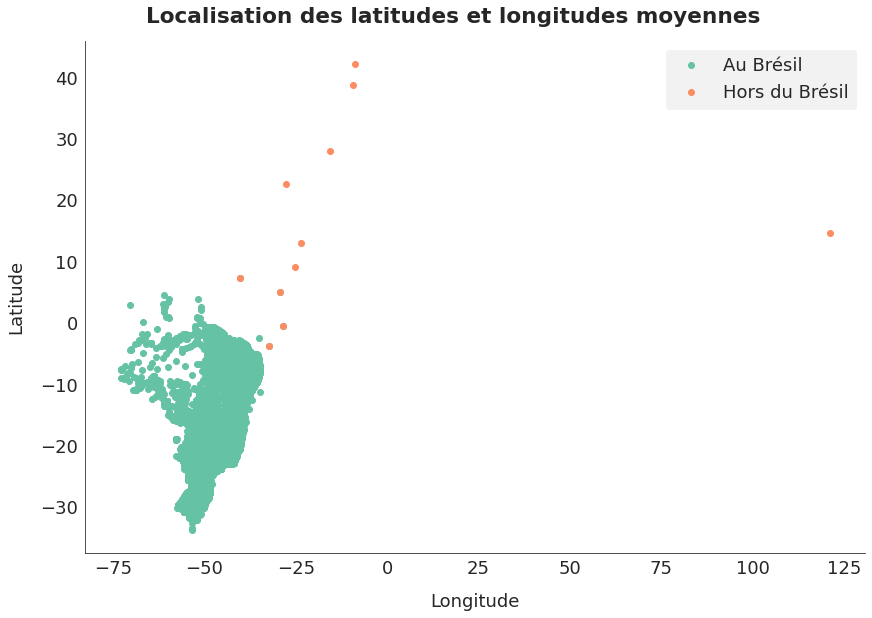

In [ ]:
okloc = geolocation[(geolocation.geolocation_lat < 6)
                    | (geolocation.geolocation_lng < -33)]
badloc = geolocation[(geolocation.geolocation_lat >= 6)
                     | (geolocation.geolocation_lng >= -33)]
graph = sfg.MyGraph("Localisation des latitudes et longitudes moyennes")
graph.add_plot(okloc.geolocation_lng, okloc.geolocation_lat,
               marker="o", linestyle="", label="Au Brésil")
graph.add_plot(badloc.geolocation_lng, badloc.geolocation_lat,
               marker="o", linestyle="", label="Hors du Brésil", legend=True)
graph.set_axe_x(label="Longitude")
graph.set_axe_y(label="Latitude")
fig, ax = graph.fig, graph.ax
save_fig("ML04_part1_nettoyage_geo")
plt.show()

Il y a 11 points mal géolocalisés, sur 19023 combinaisons zipcode/état. Il faut les enlever pour ne pas fausser le calcul des distances.

In [ ]:
def remove_wrong_geolocation(df):
    index_to_remove = df[(df.geolocation_lat >= 6)
                         | (df.geolocation_lng >= -33)].index
    return df.drop(index_to_remove)

In [ ]:
geolocation = remove_wrong_geolocation(geolocation)
geolocation.describe()

geolocation_lat  geolocation_lng
count     19012.000000     19012.000000
mean        -19.076266       -46.078832
std           7.239849         5.199193
min         -33.689948       -72.916069
25%         -23.564214       -49.008101
50%         -22.420364       -46.632389
75%         -15.617684       -43.261941
max           4.478955       -34.725130

<a id='2_2'></a>

### 2.2. Nettoyage de Customers

Il faut intégrer l'index de localisation des clients. Il faut aussi vérifier si les clients commandent toujours du même index de localisation.

In [ ]:
def prepare_customers(df):
    transformed = add_geolocation_id(df, "customer")
    return transformed.drop(columns=["customer_zip_code_prefix",
                                     "customer_city", "customer_state"])

In [ ]:
def add_latitude_longitude(df, prefix, geolocation):
    transformed = df.merge(geolocation, how="left", on="geolocation_id")
    col_names = list(transformed.columns)
    for i in [-1, -2]:
        col_names[i] = prefix + "_" + col_names[i]
    transformed.columns = col_names
    return transformed.drop(columns="geolocation_id")

In [ ]:
customers = prepare_customers(customers)
customers = add_latitude_longitude(customers, "customer", geolocation)
customers.head()

customer_id  ... customer_geolocation_lng
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...               -47.396929
1  18955e83d337fd6b2def6b18a428ac77  ...               -46.542848
2  4e7b3e00288586ebd08712fdd0374a03  ...               -46.656289
3  b2b6027bc5c5109e529d4dc6358b12c3  ...               -46.185233
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...               -47.142925

[5 rows x 4 columns]

In [ ]:
customers.groupby("customer_unique_id").nunique().describe()

customer_id  ...  customer_geolocation_lng
count  96096.000000  ...              96096.000000
mean       1.034809  ...                  0.999750
std        0.214384  ...                  0.074824
min        1.000000  ...                  0.000000
25%        1.000000  ...                  1.000000
50%        1.000000  ...                  1.000000
75%        1.000000  ...                  1.000000
max       17.000000  ...                  3.000000

[8 rows x 4 columns]

Quelques acheteurs ont plusieurs géo-localisations. Il se peut qu'ils aient déménagé pendant la période.  
Les clients ont fait entre une seule commande (très majoritaire : plus de 75%) et 17 commandes.

<a id='2_3'></a>

### 2.3. Nettoyage des dataframes liés à Products

Je vérifie les catégories dont la traduction manque en anglais. Puis je remplace la description en portugais par la description en anglais.  
Ensuite, je vérifie si l'absence de description textuelle et photographique concerne les mêmes lignes. Idem pour l'absence de description physique.  
Enfin, je convertis les dimensions du produit en une seule variable : son volume.

**Vérification des traductions en anglais**

In [ ]:
transformed = products.merge(product_category,
                             how="left", on="product_category_name")
transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


In [ ]:
transformed[transformed.product_category_name_english.isna()
            & transformed.product_category_name.notna()]

product_id  ... product_category_name_english
1628   0105b5323d24fc655f73052694dbbb3a  ...                           NaN
5821   6fd83eb3e0799b775e4f946bd66657c0  ...                           NaN
7325   5d923ead886c44b86845f69e50520c3e  ...                           NaN
7478   6727051471a0fc4a0e7737b57bff2549  ...                           NaN
8819   bed164d9d628cf0593003389c535c6e0  ...                           NaN
11039  1220978a08a6b29a202bc015b18250e9  ...                           NaN
14266  ae62bb0f95af63d64eae5f93dddea8d3  ...                           NaN
16182  1954739d84629e7323a4295812a3e0ec  ...                           NaN
16930  dbe520fb381ad695a7e1f2807d20c765  ...                           NaN
17800  c7a3f1a7f9eef146cc499368b578b884  ...                           NaN
18610  7afdd65f79f63819ff5bee328843fa37  ...                           NaN
26890  a4756663d007b0cd1af865754d08d968  ...                           NaN
29919  cb9d764f38ee4d0c00af64d5c388f837  ...                           NaN

[13 rows x 10 columns]

Il manque la traduction pour 2 catégories :
- portateis_cozinha_e_preparadores_de_alimentos : portable_cooking_device ;
- pc_gamer : pc_gamer.

**Vérification des données manquantes par type (textuelles/photo et quantitatives)**

In [ ]:
products[products.product_name_lenght.isna()].describe(include="all")

product_id  ... product_width_cm
count                                610  ...       609.000000
unique                               610  ...              NaN
top     c09d788af5101df1f542712d2968d4df  ...              NaN
freq                                   1  ...              NaN
mean                                 NaN  ...        22.566502
std                                  NaN  ...        12.087371
min                                  NaN  ...        11.000000
25%                                  NaN  ...        13.000000
50%                                  NaN  ...        20.000000
75%                                  NaN  ...        30.000000
max                                  NaN  ...        80.000000

[11 rows x 9 columns]

Il y a 610 produits sans description textuelle et photographique. Les valeurs absentes pour product_nale_lenght, product_description_lenght et product_photos_qty concernent bien les mêmes produits.

In [ ]:
products[products.product_weight_g.isna()].describe(include="all")

product_id  ... product_width_cm
count                                  2  ...              0.0
unique                                 2  ...              NaN
top     09ff539a621711667c43eba6a3bd8466  ...              NaN
freq                                   1  ...              NaN
mean                                 NaN  ...              NaN
std                                  NaN  ...              NaN
min                                  NaN  ...              NaN
25%                                  NaN  ...              NaN
50%                                  NaN  ...              NaN
75%                                  NaN  ...              NaN
max                                  NaN  ...              NaN

[11 rows x 9 columns]

Il y a 2 produits sans description physique. L'absence de description physique concerne bien les mêmes produits.

Dans les deux cas, les valeurs manquantes pourront être imputées.

**Transformation du dataframe products**

In [ ]:
def add_missing_product_category(df):
    newlines = pd.DataFrame(
        {"product_category_name":
            ["portateis_cozinha_e_preparadores_de_alimentos", "pc_gamer"],
         "product_category_name_english":
            ["portable_cooking_device", "pc_gamer"]})
    return df.append(newlines, ignore_index=True)

In [ ]:
def prepare_products(df, product_cat):
    transformed = df.merge(add_missing_product_category(product_cat),
                           how="left", on="product_category_name")
    transformed["product_volume_cm3"] = transformed.product_length_cm\
        * transformed.product_height_cm * transformed.product_width_cm
    return transformed.drop(columns=["product_category_name",
                                     "product_length_cm",
                                     "product_height_cm",
                                     "product_width_cm"])

In [ ]:
products = prepare_products(products, product_category)
products.describe(include="all")

product_id  ...  product_volume_cm3
count                              32951  ...        32949.000000
unique                             32951  ...                 NaN
top     5ef5cddf0ad1c5140b02c2255109c31a  ...                 NaN
freq                                   1  ...                 NaN
mean                                 NaN  ...        16564.096695
std                                  NaN  ...        27057.041650
min                                  NaN  ...          168.000000
25%                                  NaN  ...         2880.000000
50%                                  NaN  ...         6840.000000
75%                                  NaN  ...        18480.000000
max                                  NaN  ...       296208.000000

[11 rows x 7 columns]

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_name_lenght            32341 non-null  float64
 2   product_description_lenght     32341 non-null  float64
 3   product_photos_qty             32341 non-null  float64
 4   product_weight_g               32949 non-null  float64
 5   product_category_name_english  32341 non-null  object 
 6   product_volume_cm3             32949 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.0+ MB


<a id='2_4'></a>

### 2.4. Nettoyage de Sellers

Il suffit de créer le geolocation ID des sellers et de les localiser avec leurs latitude et longitude.

In [ ]:
def prepare_sellers(df):
    transformed = add_geolocation_id(df, "seller")
    return transformed.drop(columns=["seller_zip_code_prefix",
                                     "seller_city",
                                     "seller_state"])

In [ ]:
sellers = prepare_sellers(sellers)
sellers = add_latitude_longitude(sellers, "seller", geolocation)
sellers.head()

seller_id  ...  seller_geolocation_lng
0  3442f8959a84dea7ee197c632cb2df15  ...              -47.061337
1  d1b65fc7debc3361ea86b5f14c68d2e2  ...              -46.947927
2  ce3ad9de960102d0677a81f5d0bb7b2d  ...              -43.177703
3  c0f3eea2e14555b6faeea3dd58c1b1c3  ...              -46.612831
4  51a04a8a6bdcb23deccc82b0b80742cf  ...              -46.534419

[5 rows x 3 columns]

<a id='2_5'></a>

### 2.5. Nettoyage des dataframes liés à Orders

#### 2.5.1. Vérification de Orders

Les données manquantes concernent les colonnes de date d'approbation de la commande, de date d'expédition et de date de livraison. Je vérifie si ces données manquantes sont liées au statut de la commande.

In [ ]:
orders[orders.order_approved_at.isna()].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

In [ ]:
orders[orders.order_delivered_carrier_date.isna()].order_status.unique()

array(['invoiced', 'processing', 'unavailable', 'canceled', 'created',
       'approved', 'delivered'], dtype=object)

In [ ]:
orders[orders.order_delivered_customer_date.isna()].order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

Dans les 3 cas, le statut 'delivered' est suspect. Si le colis est livré, il devrait y avoir une date d'approbation, une date d'expédition et une date de livraison. Sinon, les autres statuts sont logiques au vu de l'évolution du traitement de la commande.

In [ ]:
len(orders[(orders.order_status == "delivered")
           & (orders.order_approved_at.isna()
              | orders.order_delivered_carrier_date.isna()
              | orders.order_delivered_customer_date.isna())])

23

23 lignes sont concernées. Je vais les étudier une à une, en passant en revue les différents cas où la colonne de la donnée absente varie.

In [ ]:
orders[(orders.order_status == "delivered") & orders.order_approved_at.isna()]

order_id  ... order_estimated_delivery_date
5323   e04abd8149ef81b95221e88f6ed9ab6a  ...           2017-03-17 00:00:00
16567  8a9adc69528e1001fc68dd0aaebbb54a  ...           2017-03-21 00:00:00
19031  7013bcfc1c97fe719a7b5e05e61c12db  ...           2017-03-17 00:00:00
22663  5cf925b116421afa85ee25e99b4c34fb  ...           2017-03-31 00:00:00
23156  12a95a3c06dbaec84bcfb0e2da5d228a  ...           2017-03-20 00:00:00
26800  c1d4211b3dae76144deccd6c74144a88  ...           2017-03-01 00:00:00
38290  d69e5d356402adc8cf17e08b5033acfb  ...           2017-03-27 00:00:00
39334  d77031d6a3c8a52f019764e68f211c69  ...           2017-03-22 00:00:00
48401  7002a78c79c519ac54022d4f8a65e6e8  ...           2017-03-16 00:00:00
61743  2eecb0d85f281280f79fa00f9cec1a95  ...           2017-03-20 00:00:00
63052  51eb2eebd5d76a24625b31c33dd41449  ...           2017-03-29 00:00:00
67697  88083e8f64d95b932164187484d90212  ...           2017-03-21 00:00:00
72407  3c0b8706b065f9919d0505d3b3343881  ...           2017-03-23 00:00:00
84999  2babbb4b15e6d2dfe95e2de765c97bce  ...           2017-03-31 00:00:00

[14 rows x 8 columns]

Il manque la date d'approbation pour des commandes passées à quelques dates : le 19 janvier 2017, les 17 et 18 février 2017. Cela doit être dû à une erreur temporaire du système. **Les durées d'approbation manquantes pourront être imputées par la moyenne ou la médiane.**

In [ ]:
orders[(orders.order_status == "delivered")
       & orders.order_delivered_carrier_date.isna()]

order_id  ... order_estimated_delivery_date
73222  2aa91108853cecb43c84a5dc5b277475  ...           2017-11-14 00:00:00
92643  2d858f451373b04fb5c984a1cc2defaf  ...           2017-06-23 00:00:00

[2 rows x 8 columns]

In [ ]:
orders[(orders.order_status == "delivered")
       & orders.order_delivered_customer_date.isna()]

order_id  ... order_estimated_delivery_date
3002   2d1e2d5bf4dc7227b3bfebb81328c15f  ...           2017-12-18 00:00:00
20618  f5dd62b788049ad9fc0526e3ad11a097  ...           2018-07-16 00:00:00
43834  2ebdfc4f15f23b91474edf87475f108e  ...           2018-07-30 00:00:00
79263  e69f75a717d64fc5ecdfae42b2e8e086  ...           2018-07-30 00:00:00
82868  0d3268bad9b086af767785e3f0fc0133  ...           2018-07-24 00:00:00
92643  2d858f451373b04fb5c984a1cc2defaf  ...           2017-06-23 00:00:00
97647  ab7c89dc1bf4a1ead9d6ec1ec8968a84  ...           2018-06-26 00:00:00
98038  20edc82cf5400ce95e1afacc25798b31  ...           2018-07-19 00:00:00

[8 rows x 8 columns]

**Les délais d'expédition et de livraison pourront également être imputés à partir des valeurs moyennes ou médianes.**

Les commandes qui ne sont pas livrées ne nous intéressent pas. Je les supprime. Au préalable, je vérifie les différents statuts qui existent.

In [ ]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Il n'y a pas d'autres statuts que ceux déjà vus. Je peux supprimer les statuts qui ne sont pas 'delivered'. Je vérifie le nombre de commandes concernées.

In [ ]:
len(orders[orders.order_status != "delivered"])

2963

Il y a 2963 commandes non livrées, que je supprime.

In [ ]:
inter_orders = orders[orders.order_status == "delivered"].copy()
inter_orders.describe(include="all")

order_id  ... order_estimated_delivery_date
count                              96478  ...                         96478
unique                             96478  ...                           445
top     0a383b731ceafec6fe7047720b1ea52e  ...           2017-12-20 00:00:00
freq                                   1  ...                           507

[4 rows x 8 columns]

Il faut vérifier que les dates sont bien dans l'ordre chronologique, excepté pour la date de livraison estimée qui peut être antérieure à la date réelle de livraison. Par contre, elle ne peut pas être antérieure à la date d'achat.

In [ ]:
list_date_cols = ["order_purchase_timestamp", "order_approved_at",
                  "order_delivered_carrier_date",
                  "order_delivered_customer_date",
                  "order_estimated_delivery_date"]
for col in np.arange(1, len(list_date_cols)):
    if col < len(list_date_cols) - 1:
        errors = inter_orders[list_date_cols[col]]\
            < inter_orders[list_date_cols[col - 1]]
    else:
        errors = inter_orders[list_date_cols[col]]\
            < inter_orders[list_date_cols[0]]
    print("Nombre d'erreurs pour la colonne {} : {}"
          .format(list_date_cols[col], errors.sum()))

Nombre d'erreurs pour la colonne order_approved_at : 0
Nombre d'erreurs pour la colonne order_delivered_carrier_date : 1350
Nombre d'erreurs pour la colonne order_delivered_customer_date : 23
Nombre d'erreurs pour la colonne order_estimated_delivery_date : 0


Il y a 1350 commandes qui sont expédiées avant d'être approuvées, et 23 livrées au client avant d'être expédiées. Je supprime les commandes avec des incohérences dans les dates.

Les dates d'approbation, d'expédition, de livraison et de livraison estimée ne sont pas intéressantes en soi. Je les transforme en délai d'approbation, d'expédition, de livraison et en une mesure de respect de la date de livraison estimée.  
J'ajoute donc les variables suivantes :
- order_purchase_year_month, order_purchase_day_of_month, order_purchase_day_of_week, order_purchase_hour ;
- approbation_time : délai d'approbation de la commande ;
- shipping_time : délai d'expédition après l'approbation ;
- delivery_days : nombre de jours entre l'expédition et la livraison ;
- delivery_lag : nombre de jours de retard (ou d'avance si la valeur est négative) par rapport à la date prévue de livraison.

In [ ]:
def remove_wrong_orders_dates(df):
    transformed = df.copy()
    list_date_cols = ["order_purchase_timestamp", "order_approved_at",
                      "order_delivered_carrier_date",
                      "order_delivered_customer_date",
                      "order_estimated_delivery_date"]
    for col in np.arange(1, len(list_date_cols)):
        if col < len(list_date_cols) - 1:
            errors = transformed[list_date_cols[col]]\
                < transformed[list_date_cols[col - 1]]
        else:
            errors = transformed[list_date_cols[col]]\
                < transformed[list_date_cols[0]]
        index_to_remove = transformed[errors].index
        transformed.drop(index_to_remove, inplace=True)
    return transformed

In [ ]:
def prepare_orders(df):
    transformed = df[df.order_status == "delivered"].copy()
    transformed = remove_wrong_orders_dates(transformed)
    transformed["order_purchase_year_month"] = pd.to_datetime(
        transformed.order_purchase_timestamp).dt.strftime("%Y%m")
    transformed["order_purchase_day_of_month"] = pd.to_datetime(
        transformed.order_purchase_timestamp).dt.strftime("%d")
    transformed["order_purchase_day_of_week"] = pd.to_datetime(
        transformed.order_purchase_timestamp).dt.strftime("%A")
    transformed["order_purchase_hour"] = pd.to_datetime(
        transformed.order_purchase_timestamp).dt.strftime("%H")
    transformed["approbation_time"] = (pd.to_datetime(
        transformed.order_approved_at) - pd.to_datetime(
        transformed.order_purchase_timestamp)).dt.total_seconds() / 86400.0
    transformed["shipping_time"] = (pd.to_datetime(
        transformed.order_delivered_carrier_date) - pd.to_datetime(
        transformed.order_approved_at)).dt.total_seconds() / 86400.0
    transformed["delivery_days"] = (pd.to_datetime(
        transformed.order_delivered_customer_date).dt.date - pd.to_datetime(
        transformed.order_delivered_carrier_date).dt.date).dt.days
    transformed["delivery_lag"] = (pd.to_datetime(
        transformed.order_delivered_customer_date).dt.date - pd.to_datetime(
        transformed.order_estimated_delivery_date).dt.date).dt.days
    return transformed.drop(columns=["order_approved_at",
                                     "order_delivered_carrier_date",
                                     "order_delivered_customer_date",
                                     "order_estimated_delivery_date"])

In [ ]:
orders = prepare_orders(orders)

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95105 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   order_id                     95105 non-null  object 
 1   customer_id                  95105 non-null  object 
 2   order_status                 95105 non-null  object 
 3   order_purchase_timestamp     95105 non-null  object 
 4   order_purchase_year_month    95105 non-null  object 
 5   order_purchase_day_of_month  95105 non-null  object 
 6   order_purchase_day_of_week   95105 non-null  object 
 7   order_purchase_hour          95105 non-null  object 
 8   approbation_time             95091 non-null  float64
 9   shipping_time                95089 non-null  float64
 10  delivery_days                95096 non-null  float64
 11  delivery_lag                 95097 non-null  float64
dtypes: float64(4), object(8)
memory usage: 9.4+ MB


In [ ]:
orders.describe(include="all")

order_id  ...  delivery_lag
count                              95105  ...  95097.000000
unique                             95105  ...           NaN
top     0a383b731ceafec6fe7047720b1ea52e  ...           NaN
freq                                   1  ...           NaN
mean                                 NaN  ...    -11.825568
std                                  NaN  ...     10.199320
min                                  NaN  ...   -147.000000
25%                                  NaN  ...    -17.000000
50%                                  NaN  ...    -12.000000
75%                                  NaN  ...     -7.000000
max                                  NaN  ...    188.000000

[11 rows x 12 columns]

#### 2.5.2. Vérification de Order Reviews

J'ai constaté qu'il y a plus de lignes de reviews que de nombre d'ordres. Je regarde combien j'ai de commentaires par ordre.

In [ ]:
list_order_id = orders[orders.order_status == "delivered"].order_id
order_reviews[order_reviews.order_id.isin(list_order_id)]\
    .groupby("order_id").count().describe()

review_id  ...  review_answer_timestamp
count  95105.000000  ...             95105.000000
mean       1.005625  ...                 1.005625
std        0.075352  ...                 0.075352
min        1.000000  ...                 1.000000
25%        1.000000  ...                 1.000000
50%        1.000000  ...                 1.000000
75%        1.000000  ...                 1.000000
max        3.000000  ...                 3.000000

[8 rows x 6 columns]

Il y a entre 1 et 3 commentaires par ordre. La très grande majorité des ordres n'a qu'un commentaire. Les ordres avec plusieurs commentaires doivent être liés dû aux paniers avec plusieurs produits. Je vais calculer des valeurs moyennes par ordre.

Le review_id ne sert à rien. Je peux le supprimer. Je calcule la longueur du titre, la longueur du message et le délai de réponse. Puis le calcul de la moyenne des valeurs par commande permet de ne garder que les valeurs numériques.  
Si un titre ou ou commentaire n'est pas renseigné, sa longueur vaut 0. Je remplace donc les valeurs manquentes par des 0.

In [ ]:
def prepare_order_reviews(df):
    checked = df.copy()
    checked["comment_title_length"] = checked["review_comment_title"].str.len()
    checked["comment_message_length"] = \
        checked["review_comment_message"].str.len()
    checked["review_response_days"] = (pd.to_datetime(
        checked.review_answer_timestamp) - pd.to_datetime(
        checked.review_creation_date)).dt.days
    transformed = checked.groupby("order_id").mean().reset_index()
    return transformed.fillna(0)

In [ ]:
order_reviews = prepare_order_reviews(order_reviews)

In [ ]:
order_reviews.describe()

review_score  ...  review_response_days
count  99441.000000  ...          99441.000000
mean       4.071235  ...              2.581330
std        1.358410  ...              9.871479
min        1.000000  ...              0.000000
25%        4.000000  ...              1.000000
50%        5.000000  ...              1.000000
75%        5.000000  ...              3.000000
max        5.000000  ...            518.000000

[8 rows x 4 columns]

#### 2.5.3. Vérification de Order Payments

In [ ]:
order_payments[order_payments.order_id.isin(list_order_id)]\
    .describe(include="all")

order_id  ...  payment_value
count                              99332  ...   99332.000000
unique                             95104  ...            NaN
top     ccf804e764ed5650cd8759557269dc13  ...            NaN
freq                                  26  ...            NaN
mean                                 NaN  ...     153.170770
std                                  NaN  ...     214.865259
min                                  NaN  ...       0.000000
25%                                  NaN  ...      56.780000
50%                                  NaN  ...     100.000000
75%                                  NaN  ...     171.320000
max                                  NaN  ...   13664.080000

[11 rows x 5 columns]

Parmi les ordres livrés, il y en un pour lequel le mode de paiement n'est pas renseigné. Vérifions lequel. **Je le supprimerai**.

In [ ]:
list_payments = order_payments.order_id.unique()
orders[~orders.order_id.isin(list_payments)]

order_id  ... delivery_lag
30710  bfbd0f9bdef84302105ad712db648a6c  ...         36.0

[1 rows x 12 columns]

Il y a également des commandes livrées qui ont des valeurs égales à 0 pour 'payment_installments' et 'payments_value'. Je vérifie d'abord si ce sont les mêmes commandes qui sont concernées, ainsi que le nombre de colonnes.

In [ ]:
order_payments[(order_payments.payment_installments == 0)
               & (order_payments.payment_value == 0)]

Empty DataFrame
Columns: [order_id, payment_sequential, payment_type, payment_installments, payment_value]
Index: []

Ce ne sont pas les mêmes commandes qui sont concernées. Je regarde déjà les commandes pour lesquelles payment_installments est égale à 0.

In [ ]:
list_payments = order_payments[order_payments.payment_installments == 0]\
    .order_id.unique()
orders[orders.order_id.isin(list_payments)]

order_id  ... delivery_lag
66368  1a57108394169c0b47d8f876acc9ba2d  ...        -13.0

[1 rows x 12 columns]

In [ ]:
delivered_order_id = orders[orders.order_id.isin(list_payments)].order_id
order_payments[order_payments.order_id.isin(delivered_order_id)]

order_id  ...  payment_value
79014  1a57108394169c0b47d8f876acc9ba2d  ...         129.94

[1 rows x 5 columns]

Il semble y avoir des aberrations dans cette ligne pour laquelle payment_installments est égal à 0. En effet, payment_sequential est égal à 2 alors qu'il n'y a qu'un seul moyen de paiement. **Je supprime cette ligne.**

In [ ]:
list_payments = order_payments[order_payments.payment_value == 0]\
    .order_id.unique()
orders[orders.order_id.isin(list_payments)]

order_id  ... delivery_lag
423    45ed6e85398a87c253db47c2d9f48216  ...        -18.0
32287  6ccb433e00daae1283ccc956189c82ae  ...        -14.0
85786  b23878b3e8eb4d25a158f57d96331b18  ...        -22.0
96970  8bcbe01d44d147f901cd3192671144db  ...        -19.0

[4 rows x 12 columns]

In [ ]:
delivered_order_id = orders[orders.order_id.isin(list_payments)].order_id
order_payments[order_payments.order_id.isin(delivered_order_id)]\
    .sort_values(by=["order_id", "payment_sequential"])

order_id  ...  payment_value
33781   45ed6e85398a87c253db47c2d9f48216  ...          21.13
11755   45ed6e85398a87c253db47c2d9f48216  ...          50.01
62674   45ed6e85398a87c253db47c2d9f48216  ...           0.00
40546   6ccb433e00daae1283ccc956189c82ae  ...          84.67
93478   6ccb433e00daae1283ccc956189c82ae  ...          14.65
92318   6ccb433e00daae1283ccc956189c82ae  ...          22.72
43744   6ccb433e00daae1283ccc956189c82ae  ...           0.00
20963   8bcbe01d44d147f901cd3192671144db  ...          36.21
63762   8bcbe01d44d147f901cd3192671144db  ...          31.70
5163    8bcbe01d44d147f901cd3192671144db  ...           6.25
19922   8bcbe01d44d147f901cd3192671144db  ...           0.00
44891   b23878b3e8eb4d25a158f57d96331b18  ...          35.98
55494   b23878b3e8eb4d25a158f57d96331b18  ...         122.79
72011   b23878b3e8eb4d25a158f57d96331b18  ...          12.80
100766  b23878b3e8eb4d25a158f57d96331b18  ...           0.00

[15 rows x 5 columns]

Les payment_value égaux à 0 correspondent à chaque fois à un bon utilisé comme dernier moyen de paiement. Deux possibilités : soit le total des paiements n'est pas égal au montant total du panier, dans quel cas payment_value doit être corrigé, soit le bon n'était pas nécessaire pour compléter le paiement de l'achat. Je garde les lignes avec payment_value égal à 0.

Je vérifie les moyens de paiements utilisés.

In [ ]:
order_payments.payment_type.unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

Je remplace 'boleto' par 'cash' pour avoir toutes mes données en anglais.

In [ ]:
test = order_payments.payment_type.str.replace("boleto", "cash")
test.unique()

array(['credit_card', 'cash', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

Il faut transformer les données pour avoir un résumé par order_id : nombre de séquences de paiements, payment_type égal à la valeur unique pour chaque order_id ou 'multiple' s'il y en a plusieurs, le maximum de payment_installments pour savoir si le paiement comporte plusieurs échéances, et la somme des valeurs des paiements.

In [ ]:
test = order_payments.groupby("order_id")[["payment_sequential"]].nunique()
test.describe()

payment_sequential
count        99440.000000
mean             1.044710
std              0.381166
min              1.000000
25%              1.000000
50%              1.000000
75%              1.000000
max             29.000000

In [ ]:
test = order_payments.groupby("order_id")["payment_type"].unique()
test.head()

order_id
00010242fe8c5a6d1ba2dd792cb16214    [credit_card]
00018f77f2f0320c557190d7a144bdd3    [credit_card]
000229ec398224ef6ca0657da4fc703e    [credit_card]
00024acbcdf0a6daa1e931b038114c75    [credit_card]
00042b26cf59d7ce69dfabb4e55b4fd9    [credit_card]
Name: payment_type, dtype: object

In [ ]:
test = order_payments.groupby("order_id")["payment_installments"].max()
test.describe()

count    99440.000000
mean         2.930521
std          2.715685
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         24.000000
Name: payment_installments, dtype: float64

In [ ]:
test = order_payments.groupby("order_id")["payment_value"].sum()
test.describe()

count    99440.000000
mean       160.990267
std        221.951257
min          0.000000
25%         62.010000
50%        105.290000
75%        176.970000
max      13664.080000
Name: payment_value, dtype: float64

In [ ]:
def remove_order_payments_zero_installments(df):
    index_to_remove = df[df.payment_installments == 0].index
    return df.drop(index_to_remove)

In [ ]:
def prepare_order_payments(df):
    checked = remove_order_payments_zero_installments(df)
    checked["payment_type"] = \
        checked.payment_type.str.replace("boleto", "cash")
    transformed = checked.groupby("order_id")[["payment_sequential"]].nunique()
    inter = checked.groupby("order_id")["payment_type"].unique()
    transformed["payment_types"] = [i[0] if len(i) == 1 else "multiple"
                                    for i in inter]
    transformed["payment_types_number"] = [len(i) for i in inter]
    transformed["payment_installments"] = \
        checked.groupby("order_id")["payment_installments"].max()
    transformed["payment_value"] = \
        checked.groupby("order_id")["payment_value"].sum()
    return transformed.reset_index()

In [ ]:
order_payments = prepare_order_payments(order_payments)

In [ ]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99438 entries, 0 to 99437
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              99438 non-null  object 
 1   payment_sequential    99438 non-null  int64  
 2   payment_types         99438 non-null  object 
 3   payment_types_number  99438 non-null  int64  
 4   payment_installments  99438 non-null  int64  
 5   payment_value         99438 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [ ]:
order_payments.describe(include="all")

order_id  ...  payment_value
count                              99438  ...   99438.000000
unique                             99438  ...            NaN
top     722d538cc82ebbe96084de19ed6f7fad  ...            NaN
freq                                   1  ...            NaN
mean                                 NaN  ...     160.991608
std                                  NaN  ...     221.953230
min                                  NaN  ...       0.000000
25%                                  NaN  ...      62.010000
50%                                  NaN  ...     105.290000
75%                                  NaN  ...     176.970000
max                                  NaN  ...   13664.080000

[11 rows x 6 columns]

#### 2.5.4. Vérification de Order Items

Je vérifie si order items est renseigné pour tous les ordres livrés.

In [ ]:
order_items[order_items.order_id.isin(list_order_id)].describe(include="all")

order_id  ...  freight_value
count                             108605  ...  108605.000000
unique                             95105  ...            NaN
top     8272b63d03f5f79c56e9e4120aec44ef  ...            NaN
freq                                  21  ...            NaN
mean                                 NaN  ...      19.941410
std                                  NaN  ...      15.706879
min                                  NaN  ...       0.000000
25%                                  NaN  ...      13.080000
50%                                  NaN  ...      16.250000
75%                                  NaN  ...      21.150000
max                                  NaN  ...     409.680000

[11 rows x 7 columns]

Order_id est bien renseigné pour tous les ordres livrés.

Je calcule pour chaque ligne :
- le pourcentage représenté par les frais de port = freight_value / (freight_value + price) ; remarque : ne peut pas être nul car le prix n'est jamais égal à 0.
- le prix total = nombre de biens * (prix unitaire + frais de port unitaire) = order_item_id * (price + freight_value).

In [ ]:
def prepare_order_items(df):
    transformed = df.copy()
    transformed["items_percent_freight_price"] = transformed.freight_value\
        / (transformed.price + transformed.freight_value)
    transformed["items_total_price"] = transformed.order_item_id\
        * (transformed.price + transformed.freight_value)
    return transformed

In [ ]:
order_items = prepare_order_items(order_items)

---
<a id='3_0'></a>

## <font color=blue>3. Analyse univariée des données</font>

Je vérifie les distributions des variables quantitatives. La normalité n'est pas un pré-requis pour les algorithmes de clustering. Je ne fais donc pas les tests de normalité.  
Pour les variables catégorielles, je regarde les valeurs possibles et leurs répartitions.  
Je ferai les analyses bi-variées après avoir créé mon dataframe agrégé, pour voir les interactions entre les variables de différentes origines.

### 3.1. Customers

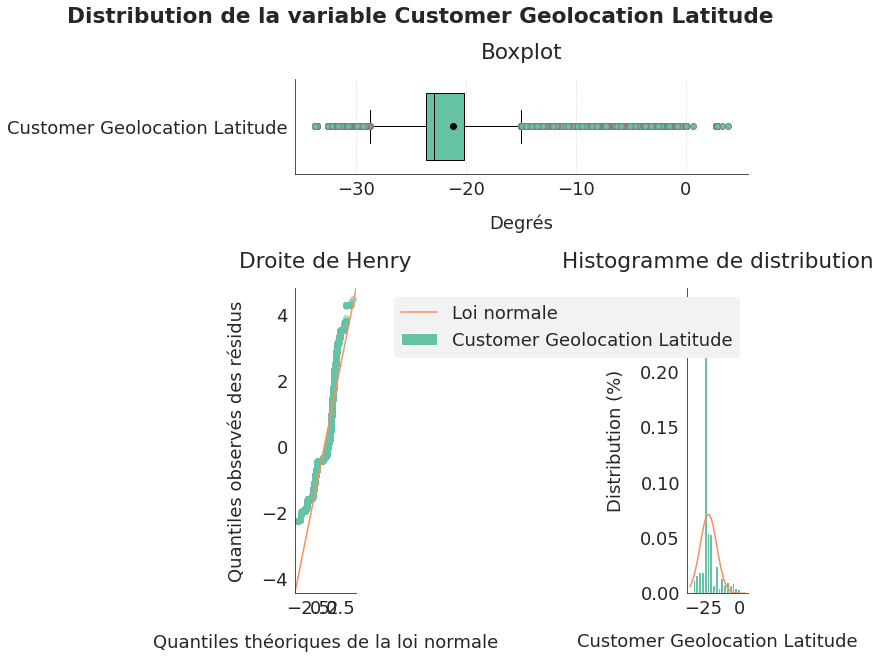

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    customers.customer_geolocation_lat.dropna(),
    "Customer Geolocation Latitude", "Degrés")
plt.show()

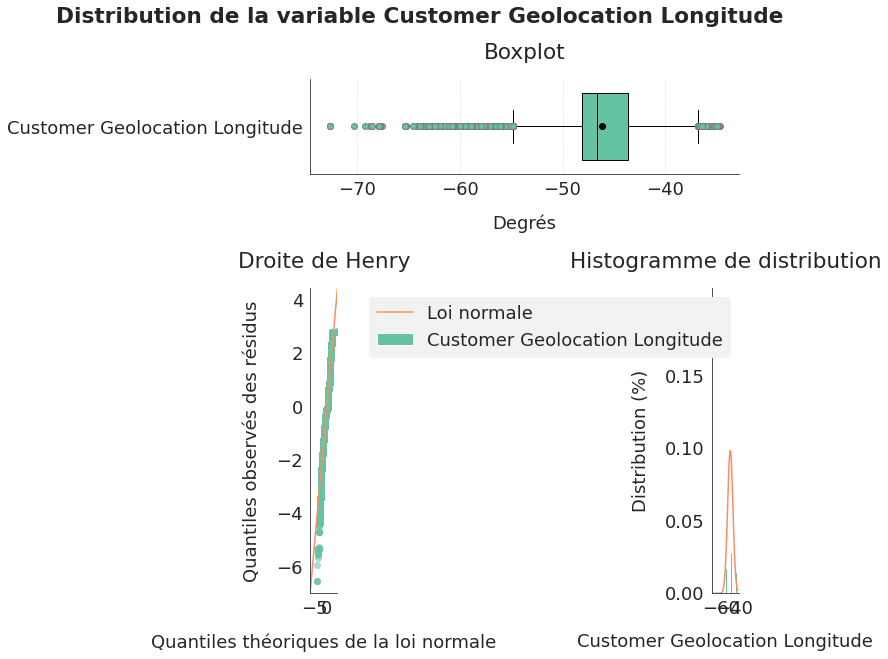

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    customers.customer_geolocation_lng.dropna(),
    "Customer Geolocation Longitude", "Degrés")
plt.show()

Les variables de Latitude et Longitude montrent que les consommateurs sont plus représentés (concentrés) dans certaines régions du Brésil. Mais il n'y a pas de skewness.

<a id='3_2'></a>

### 3.2. Sellers

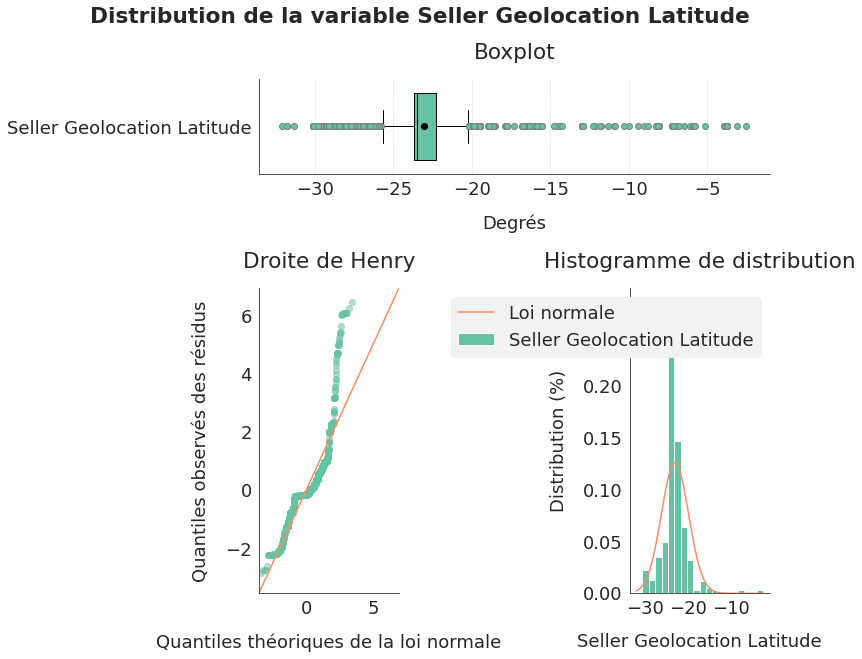

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    sellers.seller_geolocation_lat.dropna(),
    "Seller Geolocation Latitude", "Degrés")
plt.show()

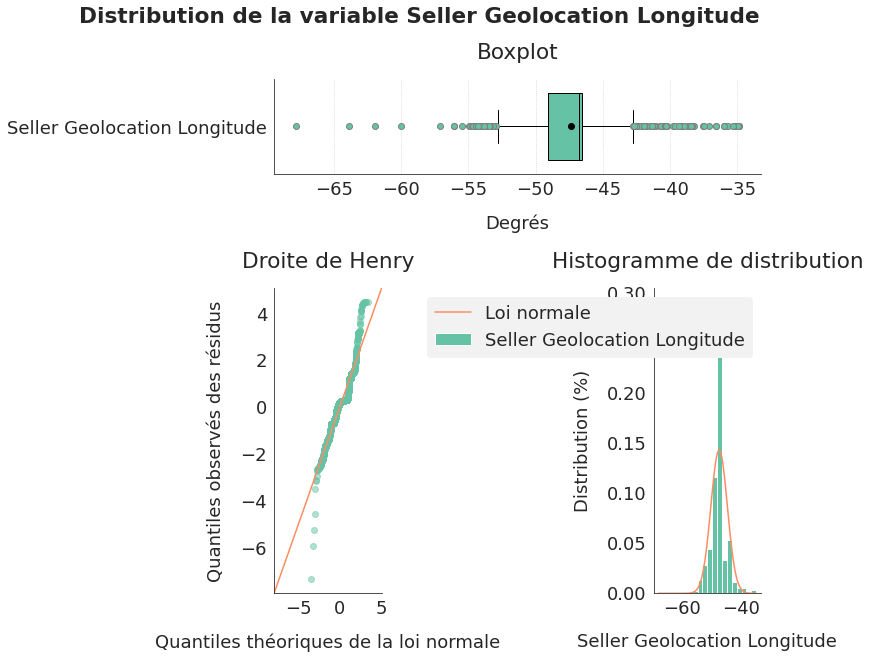

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    sellers.seller_geolocation_lng.dropna(),
    "Seller Geolocation Longitude", "Degrés")
plt.show()

Comme pour les consommateurs, les vendeurs ne sont pas uniformément répartis mais aucun skewness n'apparaît.

<a id='3_3'></a>

### 3.3. Products

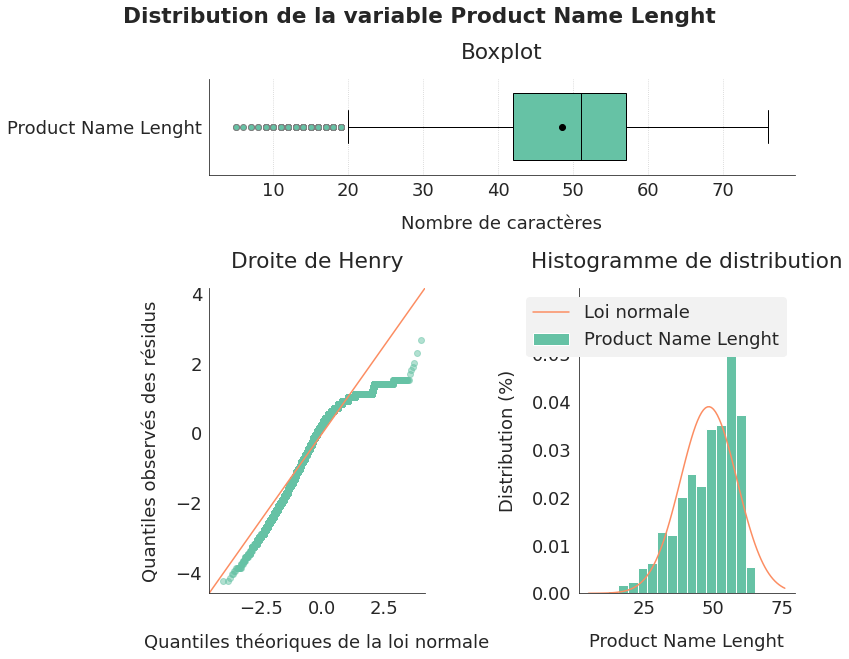

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    products.product_name_lenght.dropna(),
    "Product Name Lenght", "Nombre de caractères")
plt.show()

La longueur des noms des produits présente un skew négatif : une majorité utilise une grande partie des caractères disponibles pour le titre, et il y a des outliers avec des noms très courts.

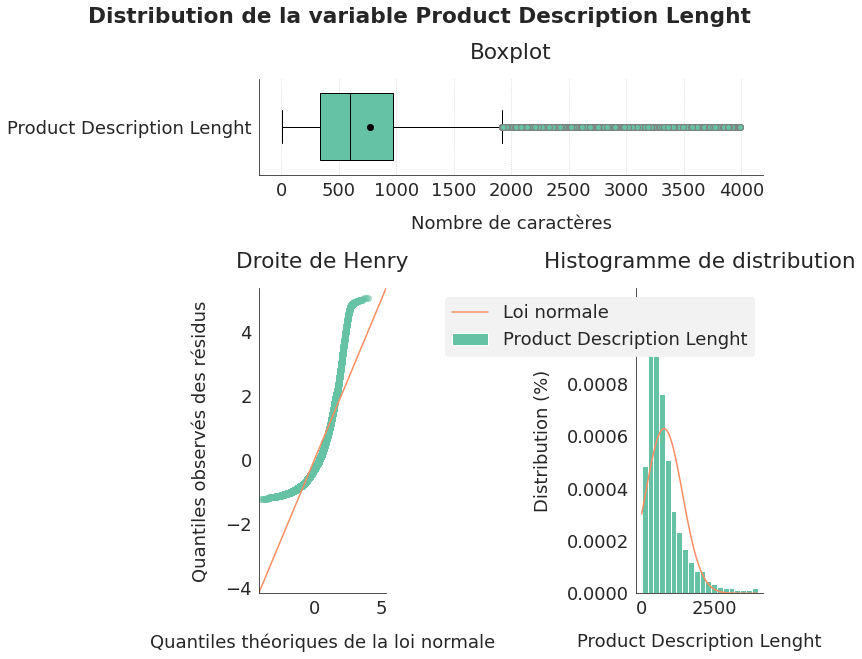

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    products.product_description_lenght.dropna(),
    "Product Description Lenght", "Nombre de caractères")
plt.show()

La longueur des descriptions des produits présente un skew positif : plus des trois-quarts des produits ont une description de moins de 1000 caractères, mais il y a des outliers avec des descriptions très longues (jusqu'à 4000 caractères).

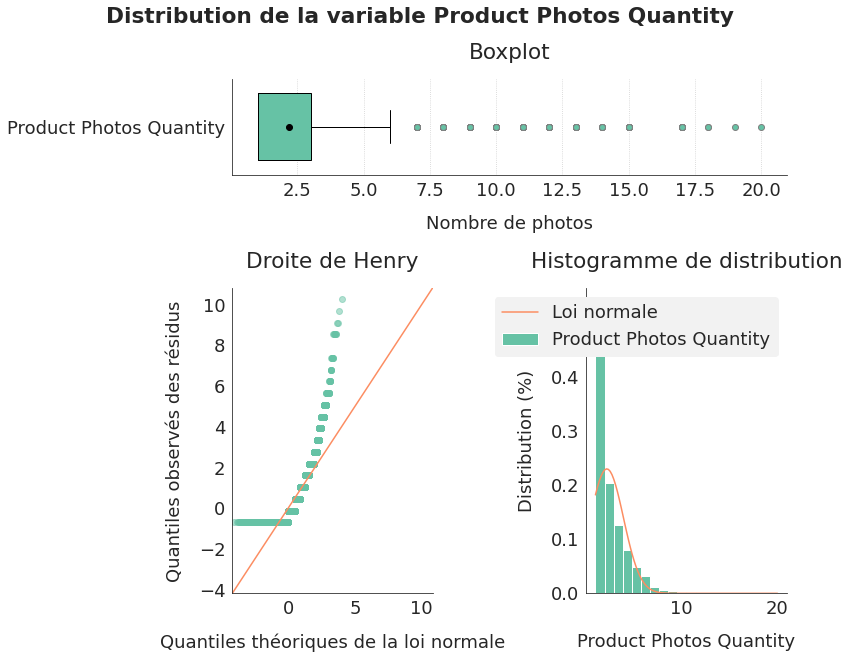

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    products.product_photos_qty.dropna(),
    "Product Photos Quantity", "Nombre de photos")
plt.show()

Le même skew positif apparaît pour le nombre de photos : plus des trois-quarts des produits ont 3 photos ou moins, mais il y a des outliers avec beaucoup plus de photos (jusqu'à 20).

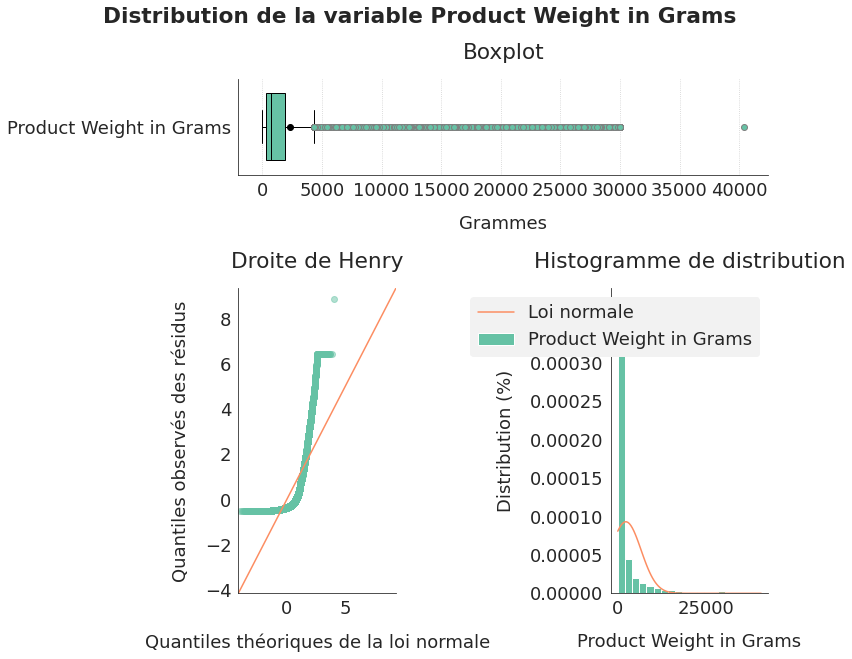

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    products.product_weight_g.dropna(),
    "Product Weight in Grams", "Grammes")
plt.show()

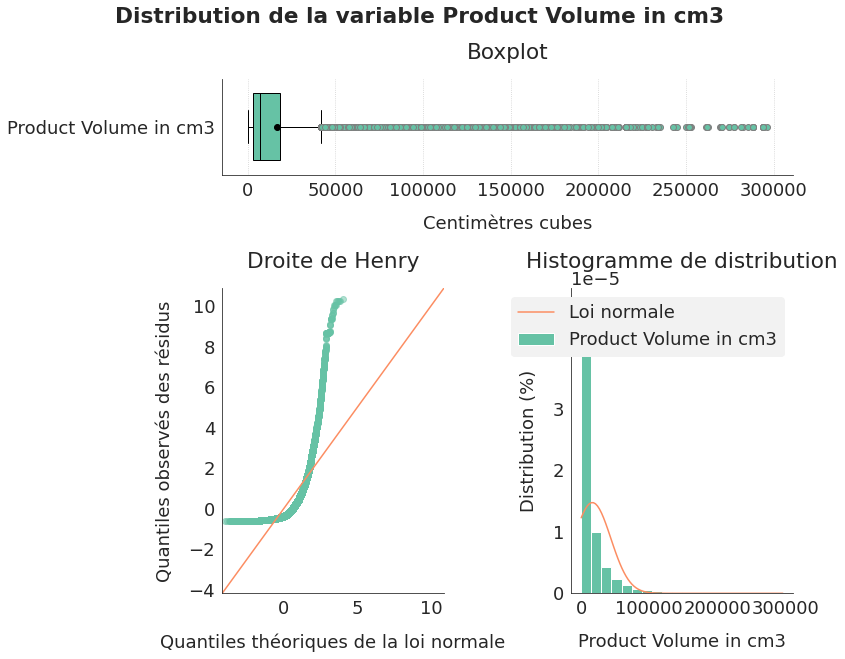

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    products.product_volume_cm3.dropna(),
    "Product Volume in cm3", "Centimètres cubes")
plt.show()

La plupart des produits vendus sont légers et peu volumineux mais quelques produits sont lourds et volumineux. Une fois de plus nous avons un skew positif et de nombreux outliers.

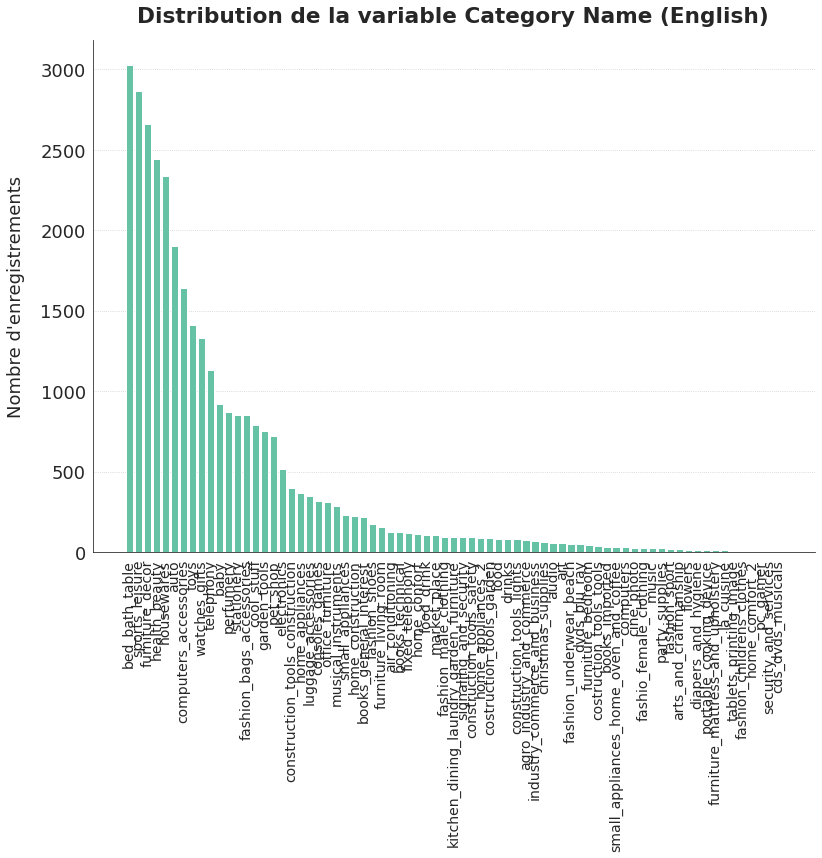

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(
    products.product_category_name_english,
    "Category Name (English)",
    ticklabels_rotation=90, ticklabels_fontsize=14)
plt.show()

Il y a beaucoup de catégories différentes. Il faut analyser ces catégories pour voir si on ne peut pas les regrouper.

In [ ]:
products.product_category_name_english.unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', nan, 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
       'hom

Il y a des catégories qui concernent les mêmes activités. Je regroupe :
- hygiene and beauty : perfumery, health_beauty, diapers_and_hygiene ;
- home appliances : home_appliances, home_appliances_2 ;
- small appliances : housewares, small_appliances, small_appliances_home_oven_and_coffee, portable_cooking_device ;
- home comfort : home_confort, home_comfort_2, air_conditioning ;
- construction tools : construction_tools_safety, home_construction, construction_tools_construction, construction_tools_lights, costruction_tools_tools ;
- garden tools : costruction_tools_garden, garden_tools ;
- office_furniture : office_furniture, stationery ;
- telephony : telephony, fixed_telephony ;
- security : signaling_and_security, security_and_services ;
- books : books_general_interest, books_technical, books_imported ;
- kitchen : kitchen_dining_laundry_garden_furniture, la_cuisine ;
- industry and commerce : industry_commerce_and_business, agro_industry_and_commerce ;
- luggage : luggage_accessories, fashion_bags_accessories ;
- computers : tablets_printing_image, computers_accessories, computers, pc_gamer, consoles_games ;
- electronics: electronics, cine_photo, audio ;
- music and videos : cds_dvds_musicals, dvds_blu_ray, music ;
- party supplies : christmas_supplies, party_supplies ;
- arts : arts_and_craftmanship, art ;
- furnitures : bed_bath_table, furniture_living_room, furniture_bedroom, furniture_mattress_and_upholstery ;
- food and drinks : food, food_drink, drinks ;
- fashion : fashion_male_clothing, fashio_female_clothing, fashion_shoes, fashion_sport, fashion_childrens_clothes, fashion_underwear_beach ;
- furniture_decor ;
- musical_instruments
- cool_stuff ;
- toys ;
- auto ;
- flowers ;
- watches_gifts ;
- pet_shop ;
- sports_leisure ;
- market_place ;
- baby ;
- nan.

In [ ]:
grouped_categories = pd.DataFrame({
    "product_category_name_english": [
        "perfumery", "health_beauty", "diapers_and_hygiene",
        "home_appliances", "home_appliances_2",
        "housewares", "small_appliances",
        "small_appliances_home_oven_and_coffee", "portable_cooking_device",
        "home_confort", "home_comfort_2", "air_conditioning",
        "construction_tools_safety", "home_construction",
        "construction_tools_construction", "construction_tools_lights",
        "costruction_tools_tools", "costruction_tools_garden", "garden_tools",
        "office_furniture", "stationery",
        "telephony", "fixed_telephony",
        "signaling_and_security", "security_and_services",
        "books_general_interest", "books_technical", "books_imported",
        "kitchen_dining_laundry_garden_furniture", "la_cuisine",
        "industry_commerce_and_business", "agro_industry_and_commerce",
        "luggage_accessories", "fashion_bags_accessories",
        "tablets_printing_image", "computers_accessories", "computers",
        "pc_gamer", "consoles_games",
        "electronics", "cine_photo", "audio",
        "cds_dvds_musicals", "dvds_blu_ray", "music",
        "christmas_supplies", "party_supplies",
        "arts_and_craftmanship", "art",
        "bed_bath_table", "furniture_living_room", "furniture_bedroom",
        "furniture_mattress_and_upholstery",
        "food", "food_drink", "drinks",
        "fashion_male_clothing", "fashio_female_clothing", "fashion_shoes",
        "fashion_sport", "fashion_childrens_clothes",
        "fashion_underwear_beach",
        "furniture_decor", "musical_instruments", "cool_stuff",
        "toys", "auto", "flowers", "watches_gifts", "pet_shop",
        "sports_leisure", "market_place", "baby"],
    "product_category_global": [
        "hygiene_and_beauty", "hygiene_and_beauty", "hygiene_and_beauty",
        "home_appliances", "home_appliances",
        "small_appliances", "small_appliances", "small_appliances",
        "small_appliances",
        "home_comfort", "home_comfort", "home_comfort",
        "construction_tools", "construction_tools", "construction_tools",
        "construction_tools", "construction_tools",
        "garden_tools", "garden_tools",
        "office_furniture", "office_furniture",
        "telephony", "telephony",
        "security", "security",
        "books", "books", "books",
        "kitchen", "kitchen",
        "industry_and_commerce", "industry_and_commerce",
        "luggage", "luggage",
        "computers", "computers", "computers", "computers", "computers",
        "electronics", "electronics", "electronics",
        "music_and_videos", "music_and_videos", "music_and_videos",
        "party_supplies", "party_supplies",
        "arts", "arts",
        "furnitures", "furnitures", "furnitures", "furnitures",
        "food_and_drinks", "food_and_drinks", "food_and_drinks",
        "fashion", "fashion", "fashion", "fashion", "fashion", "fashion",
        "furniture_decor", "musical_instruments", "cool_stuff",
        "toys", "auto", "flowers", "watches_gifts", "pet_shop",
        "sports_leisure", "market_place", "baby"]})
grouped_categories

product_category_name_english product_category_global
0                      perfumery      hygiene_and_beauty
1                  health_beauty      hygiene_and_beauty
2            diapers_and_hygiene      hygiene_and_beauty
3                home_appliances         home_appliances
4              home_appliances_2         home_appliances
..                           ...                     ...
68                 watches_gifts           watches_gifts
69                      pet_shop                pet_shop
70                sports_leisure          sports_leisure
71                  market_place            market_place
72                          baby                    baby

[73 rows x 2 columns]

In [ ]:
def products_group_categories(df, df_groups):
    transformed = df.merge(df_groups,
                           how="left", on="product_category_name_english")
    return transformed.drop(columns="product_category_name_english")

In [ ]:
products = products_group_categories(products, grouped_categories)

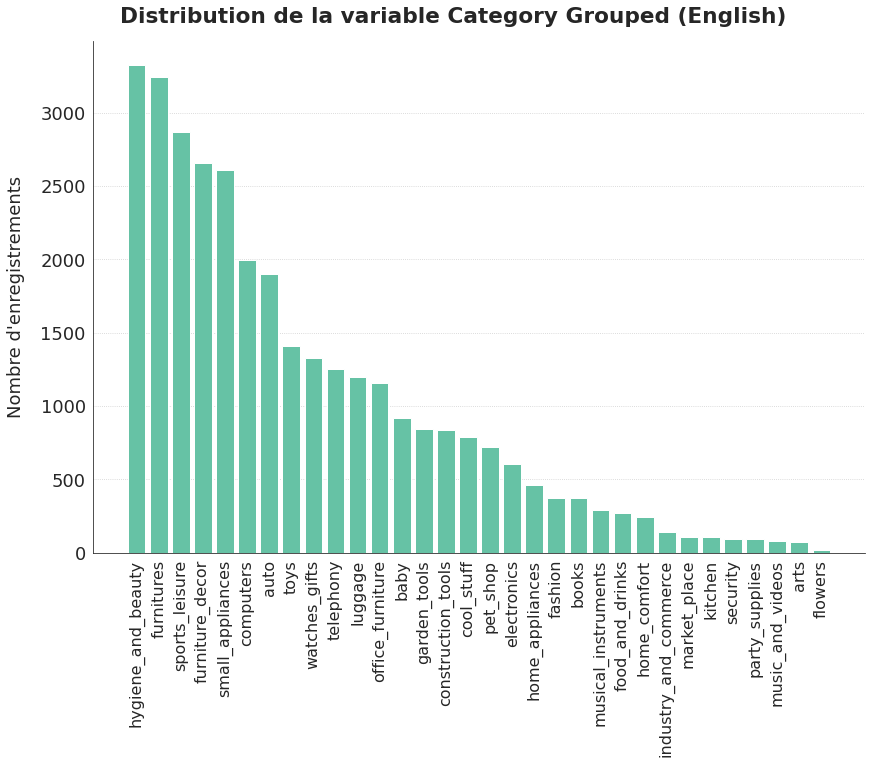

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(
    products.product_category_global,
    "Category Grouped (English)",
    ticklabels_rotation=90, ticklabels_fontsize=16)
plt.show()

<a id='3_4'></a>

### 3.4. Orders

#### 3.4.1. Orders

Je commence par analyser la répartition des commandes dans le temps, par jour du mois, par jour de la semaine, par heure de commande.

In [ ]:
pd.to_datetime(orders.order_purchase_timestamp).dt.date.min()

datetime.date(2016, 9, 15)

In [ ]:
pd.to_datetime(orders.order_purchase_timestamp).dt.date.max()

datetime.date(2018, 8, 29)

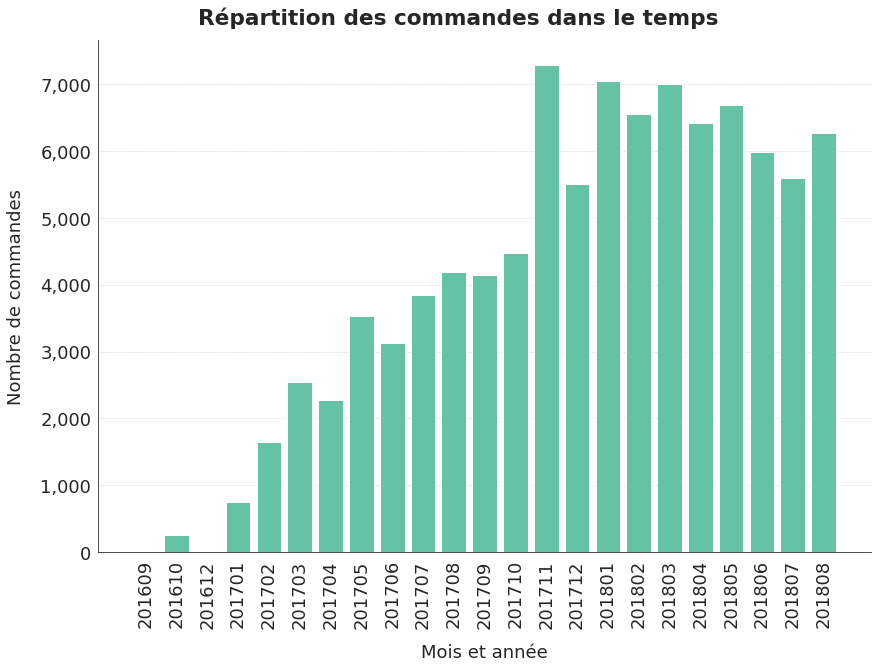

In [ ]:
values = pd.DataFrame(orders.order_purchase_year_month.value_counts())\
    .reset_index()
values.columns = ["year_month", "orders_number"]
values.sort_values(by="year_month", inplace=True)

graph = sfg.MyGraph("Répartition des commandes dans le temps")
graph.add_barv(values.year_month, values.orders_number)
graph.set_axe_x(label="Mois et année", rotation=90)
graph.set_axe_y(label="Nombre de commandes", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
plt.show()

Les ordres se répartissent entre septembre 2016 et août 2018. Le nombre de commandes mensuelles a augmenté à partir de fin 2016 pour arriver à maturité et atteindre un plafond fin 2017.

In [ ]:
current_date = pd.to_datetime(orders.order_purchase_timestamp).dt.date.min()
max_date = pd.to_datetime(orders.order_purchase_timestamp).dt.date.max()
nb_days = np.zeros(31)
while current_date <= max_date:
    nb_days[current_date.day - 1] = nb_days[current_date.day - 1] + 1
    current_date += pd.DateOffset(days=1)

In [ ]:
values = pd.DataFrame(orders.order_purchase_day_of_month.value_counts())\
    .reset_index()
values.columns = ["day_of_month", "orders_number"]
values.sort_values(by="day_of_month", inplace=True)
for i in np.arange(len(values)):
    values.iloc[i, 1] = values.iloc[i, 1] / nb_days[int(values.iloc[i, 0]) - 1]

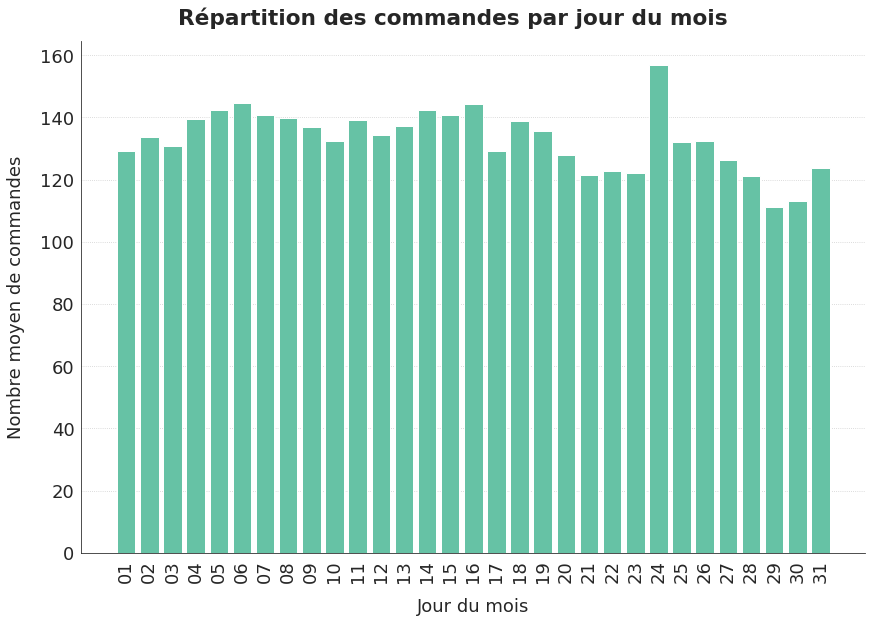

In [ ]:
graph = sfg.MyGraph("Répartition des commandes par jour du mois")
graph.add_barv(values.day_of_month, values.orders_number)
graph.set_axe_x(label="Jour du mois", rotation=90, ha="center")
graph.set_axe_y(label="Nombre moyen de commandes", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
plt.show()

On remarque quelques pics de commande dans le mois : autour du 6, du 15 et du 24 de chaque mois.

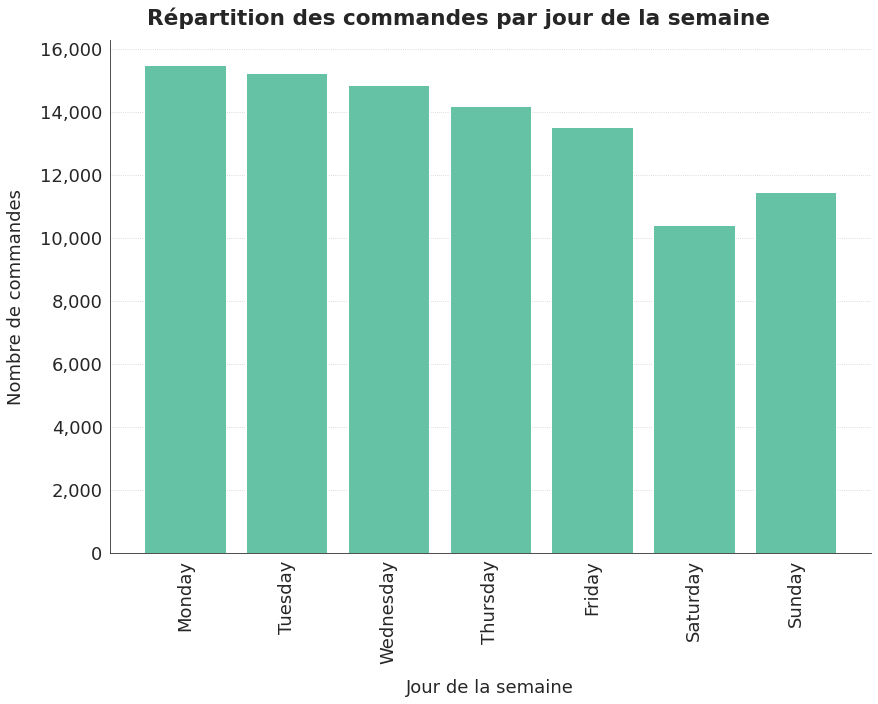

In [ ]:
values = pd.DataFrame(orders.order_purchase_day_of_week.value_counts())\
    .reset_index()
values.columns = ["day_of_week", "orders_number"]
values["day_of_week"] = pd.Categorical(
    values["day_of_week"], ["Monday", "Tuesday", "Wednesday", "Thursday",
                            "Friday", "Saturday", "Sunday"])
values.sort_values(by="day_of_week", inplace=True)

graph = sfg.MyGraph("Répartition des commandes par jour de la semaine")
graph.add_barv(values.day_of_week, values.orders_number)
graph.set_axe_x(label="Jour de la semaine", rotation=90)
graph.set_axe_y(label="Nombre de commandes", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
plt.show()

Il y a plus de commandes en début de semaine et sensiblement moins le week-end.

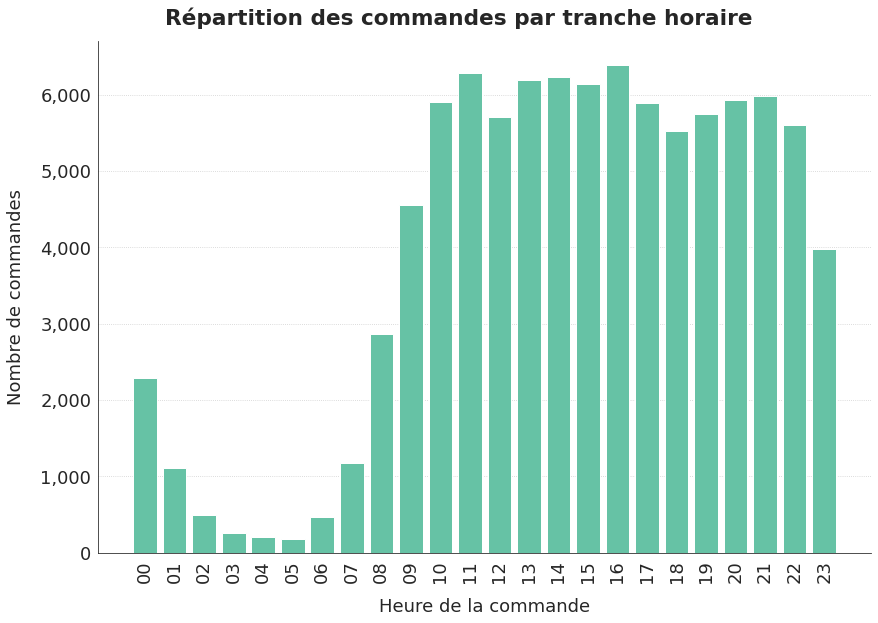

In [ ]:
values = pd.DataFrame(orders.order_purchase_hour.value_counts()).reset_index()
values.columns = ["purchase_hour", "orders_number"]
values.sort_values(by="purchase_hour", inplace=True)

graph = sfg.MyGraph("Répartition des commandes par tranche horaire")
graph.add_barv(values.purchase_hour, values.orders_number)
graph.set_axe_x(label="Heure de la commande", rotation=90)
graph.set_axe_y(label="Nombre de commandes", tick_labels_format=":,.0f")
fig, ax = graph.fig, graph.ax
plt.show()

Les commandes ont lieu essentiellement en journée et soirée, à partir de 10h et jusqu'à 23h.

J'analyse désormais les variables que j'ai créées autour des délais d'approbation, d'expédition, de livraison et de retard de la livraison.

In [ ]:
orders.describe()

approbation_time  shipping_time  delivery_days  delivery_lag
count      95091.000000   95089.000000   95096.000000  95097.000000
mean           0.402067       2.851772       9.316890    -11.825568
std            0.796507       3.482888       8.785848     10.199320
min            0.000000       0.000174       0.000000   -147.000000
25%            0.008935       0.900521       4.000000    -17.000000
50%            0.014074       1.848866       7.000000    -12.000000
75%            0.563958       3.616134      12.000000     -7.000000
max           30.893484     125.762569     205.000000    188.000000

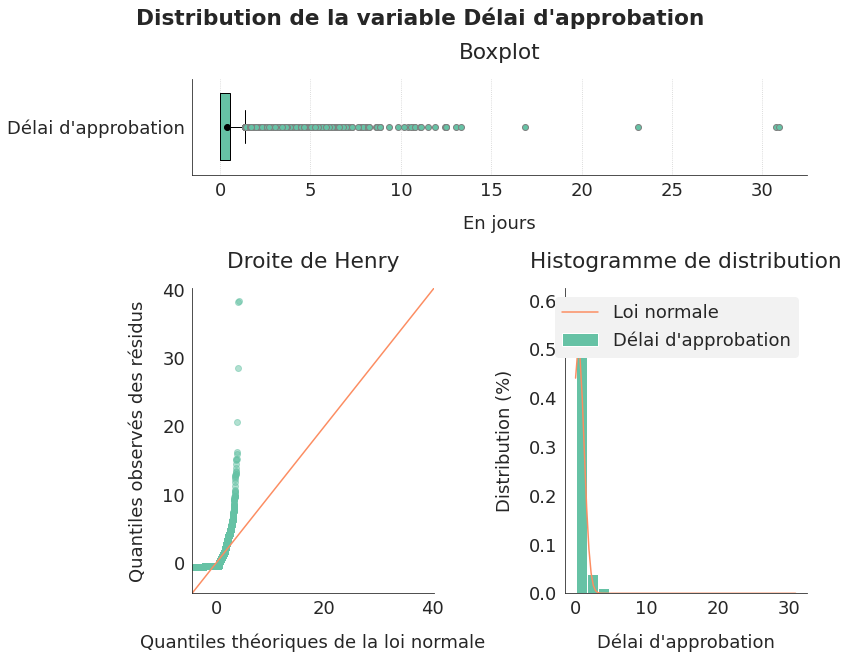

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(orders.approbation_time.dropna(),
                                           "Délai d'approbation", "En jours")
plt.show()

La très grande majorité des commandes est approuvée en moins d'une journée, et la quasi-totalité en moins de 2 jours.

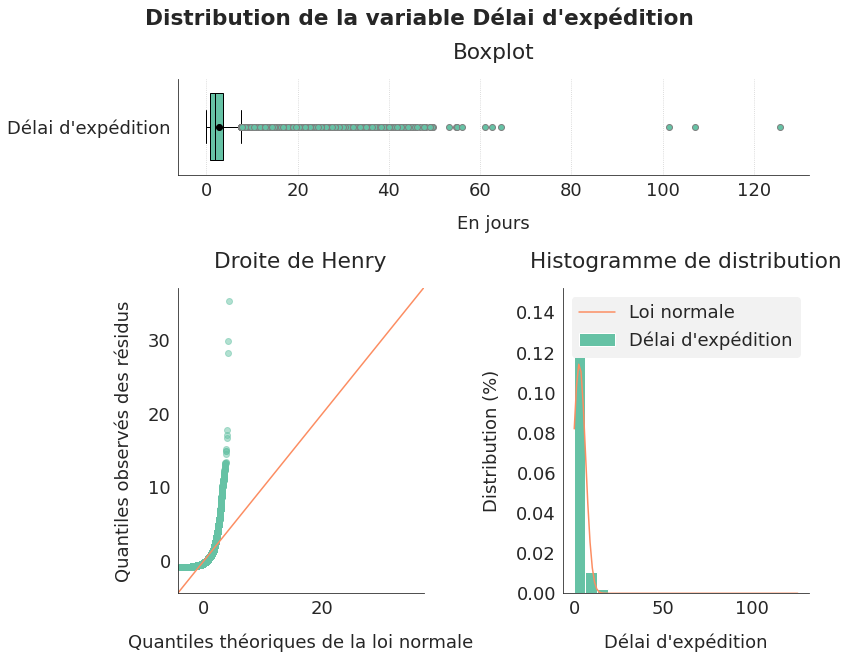

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(orders.shipping_time.dropna(),
                                           "Délai d'expédition", "En jours")
plt.show()

Plus de la moitié des commandes est expédiée dans les deux jours qui suivent leur approbation.

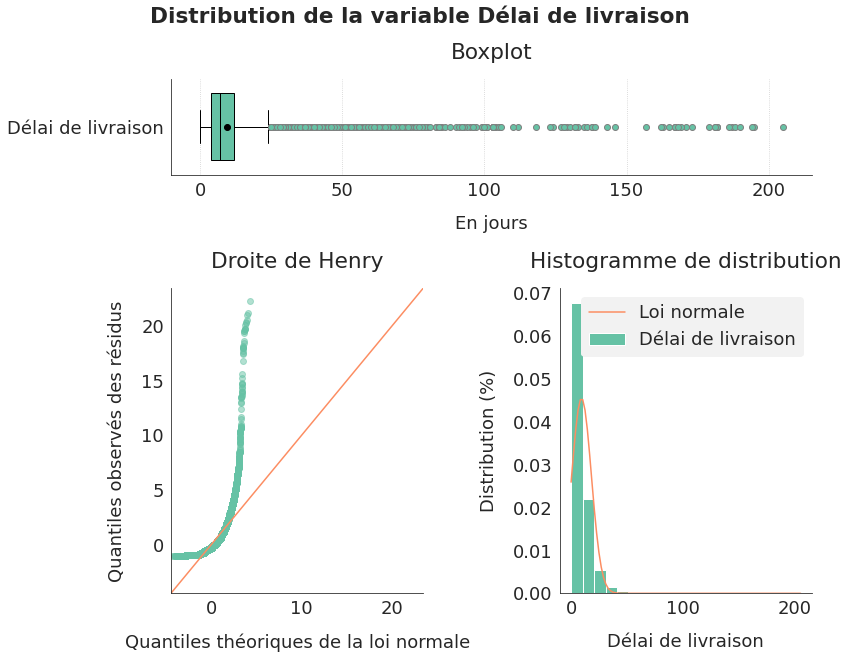

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(orders.delivery_days.dropna(),
                                           "Délai de livraison", "En jours")
plt.show()

La livraison est assez lente : elle dure plus au moins 7 jours pour plus de la moitié des commandes.

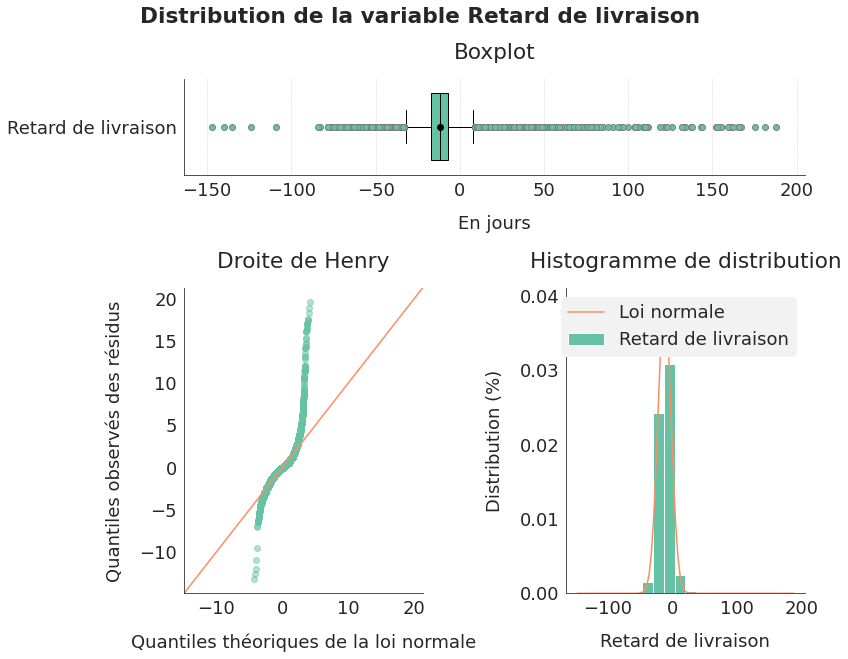

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(orders.delivery_lag.dropna(),
                                           "Retard de livraison", "En jours")
plt.show()

Cependant, la livraison est plus rapide que l'estimation initiale dans plus de trois-quart des commandes.

#### 3.4.2. Order Reviews

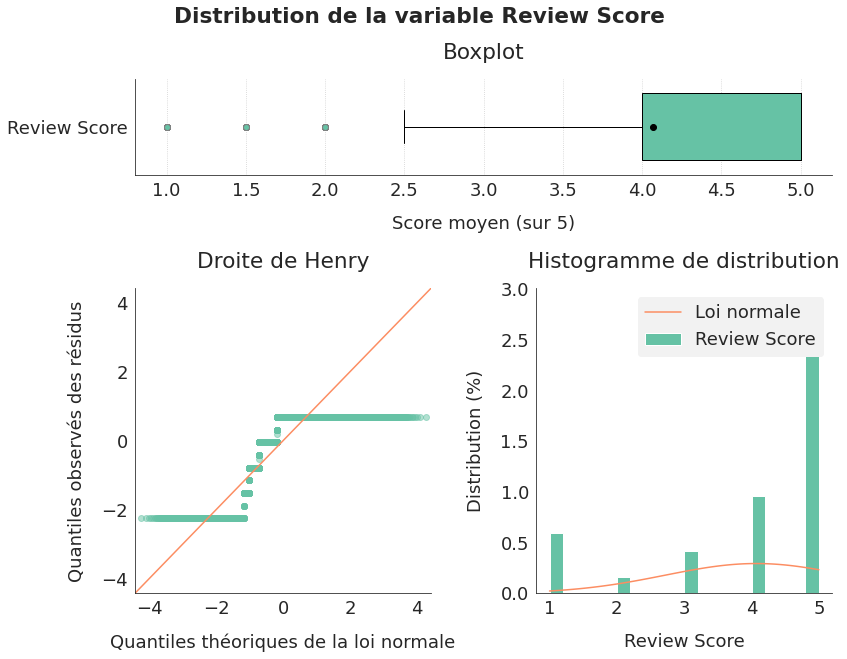

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_reviews.review_score.dropna(),
                                           "Review Score",
                                           "Score moyen (sur 5)")
plt.show()

La majorité des scores moyens est supérieure ou égale à 4. La majorité des consommateurs est satisfaite des produits reçus.

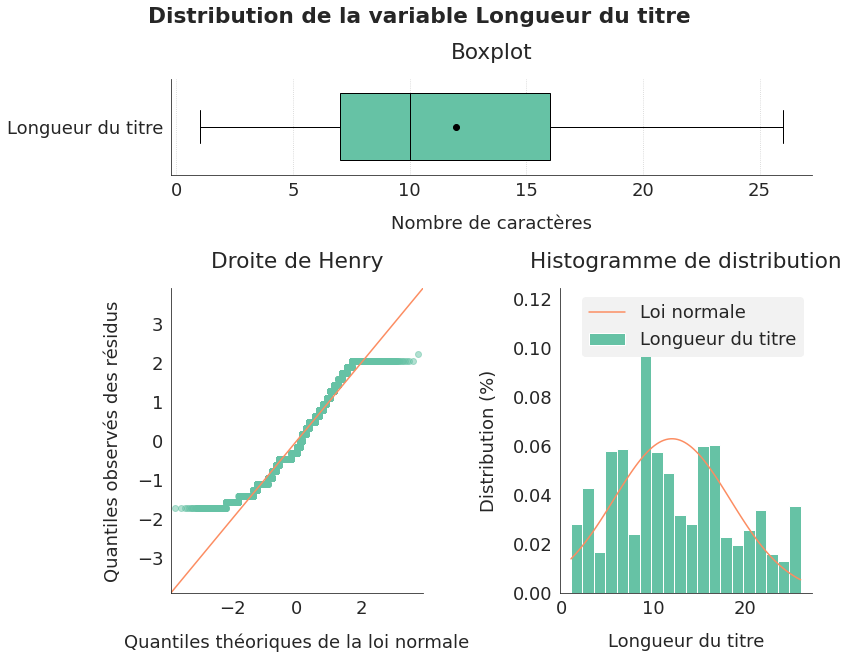

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    order_reviews[order_reviews.comment_title_length > 0].comment_title_length,
    "Longueur du titre", "Nombre de caractères")
plt.show()

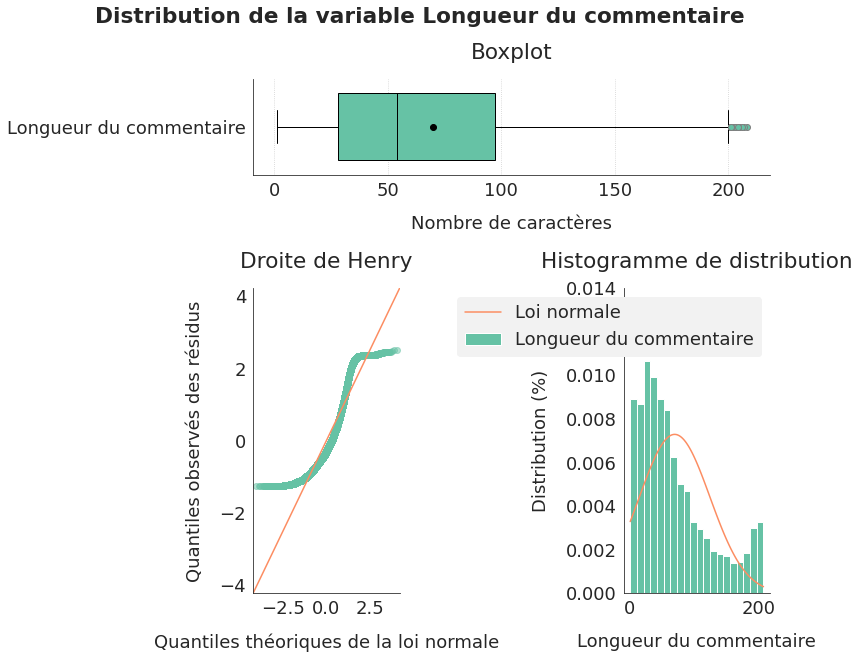

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    order_reviews[order_reviews.comment_message_length > 0]
    .comment_message_length, "Longueur du commentaire", "Nombre de caractères")
ax[2].set_ylim([0, 0.014])
plt.show()

Lorsqu'ils sont présents, les titres ont des longueurs assez diverses (distribution multimodale). Les messages des commentaires sont pour la plupart assez courts, mais quelques consommateurs prennent le temps de rédiger des commentaires plus longs.

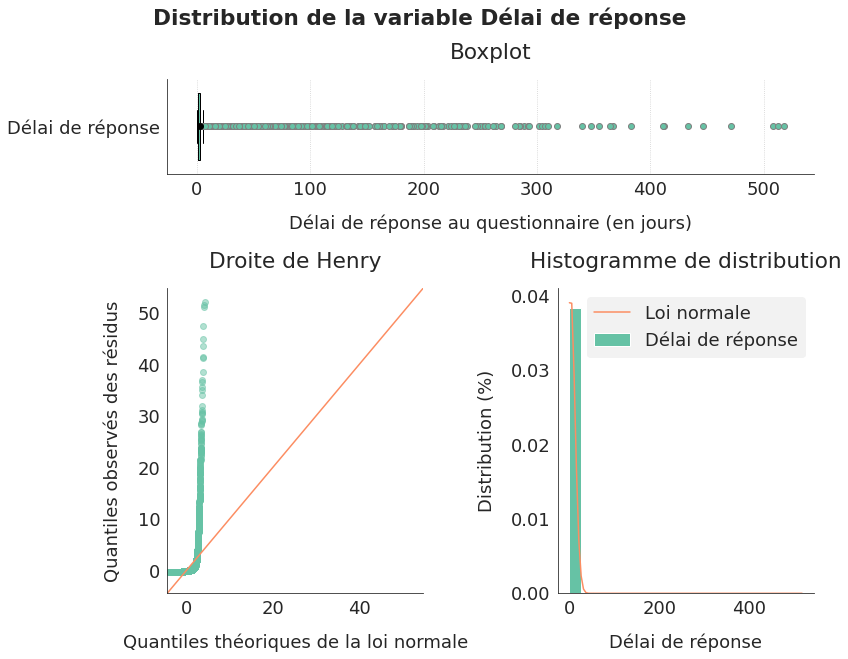

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    order_reviews.review_response_days,
    "Délai de réponse", "Délai de réponse au questionnaire (en jours)")
plt.show()

Plus de la moitié des commentaires sont remplis le jour ou le lendemain de l'envoi de la demande de revue. Il y a de nombreux outliers avec des délais de réponse qui vont parfois au-delà d'un an.

#### 3.4.3. Order Payments

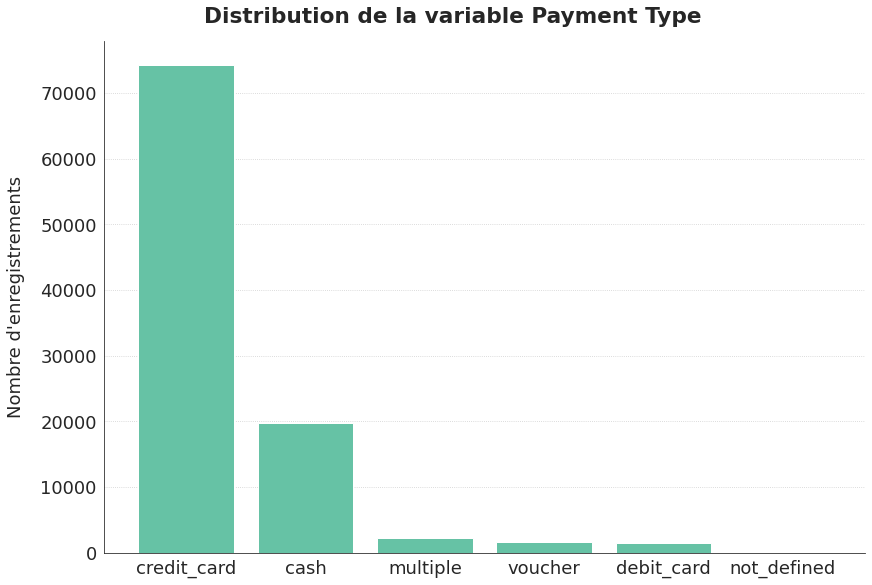

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(
    order_payments.payment_types.dropna(),
    "Payment Type", ticklabels_rotation=0)
plt.show()

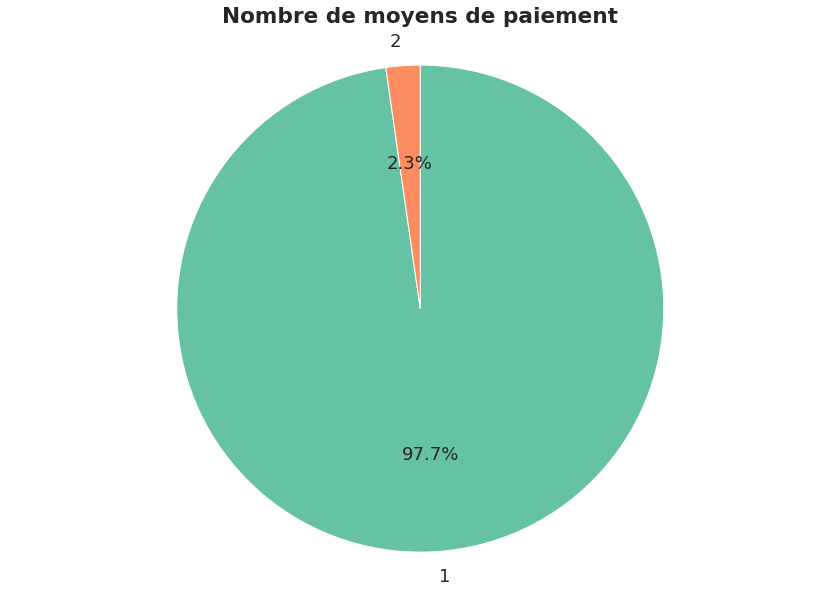

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(
    order_payments.payment_types_number.dropna(),
    "Payment Types Number", "Nombre de moyens de paiement")
plt.show()

Une majorité des paiements se fait par carte de crédit. Peu de consommateurs ont recours à plusieurs types de paiement.

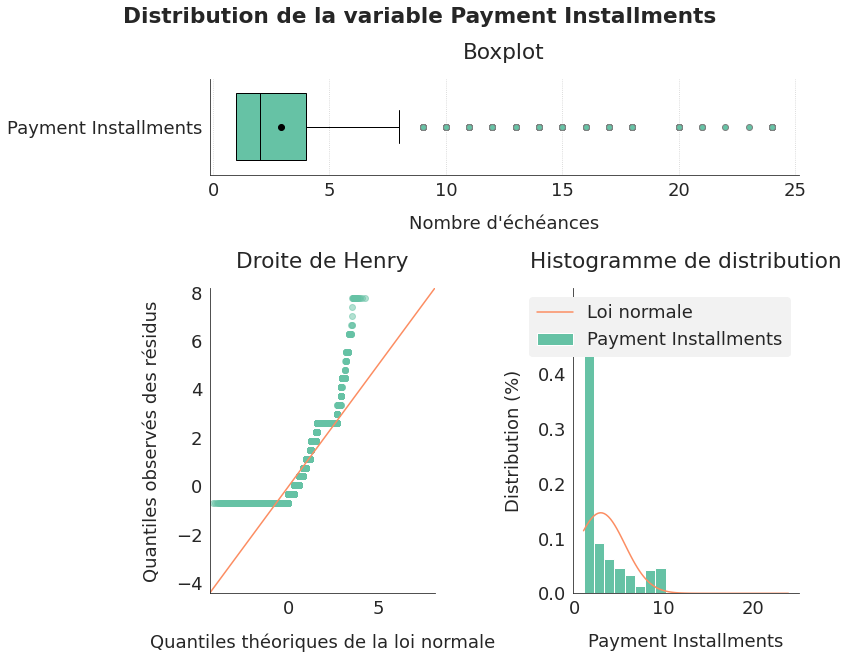

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_payments.payment_installments,
                                           "Payment Installments",
                                           "Nombre d'échéances")
plt.show()

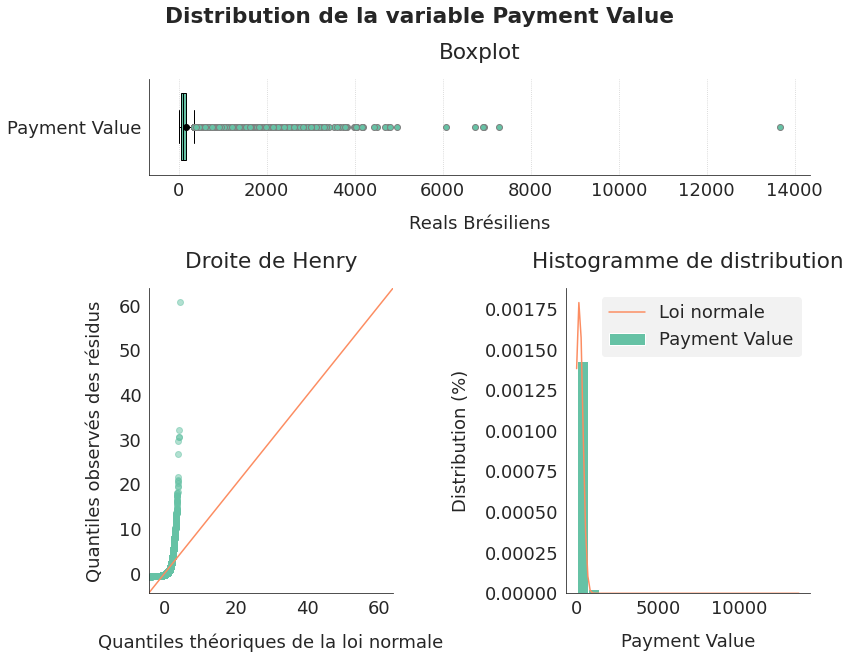

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_payments.payment_value,
                                           "Payment Value", "Reals Brésiliens")
plt.show()

Beaucoup d'achats concernent des paniers au montant contenu et sont payés en une seule échéance ou en peu d'échéances.

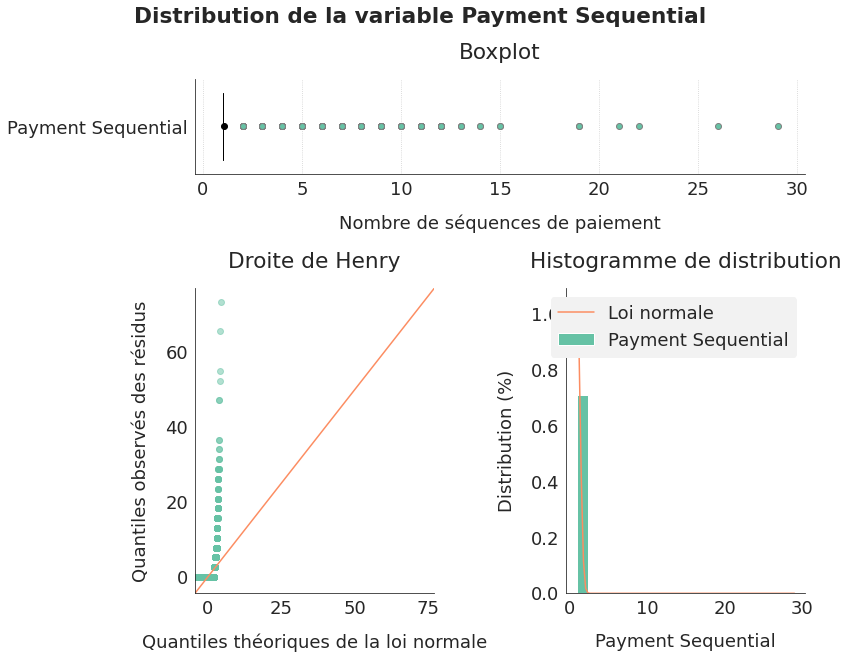

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_payments.payment_sequential,
                                           "Payment Sequential",
                                           "Nombre de séquences de paiement")
plt.show()

#### 3.4.4. Order Items

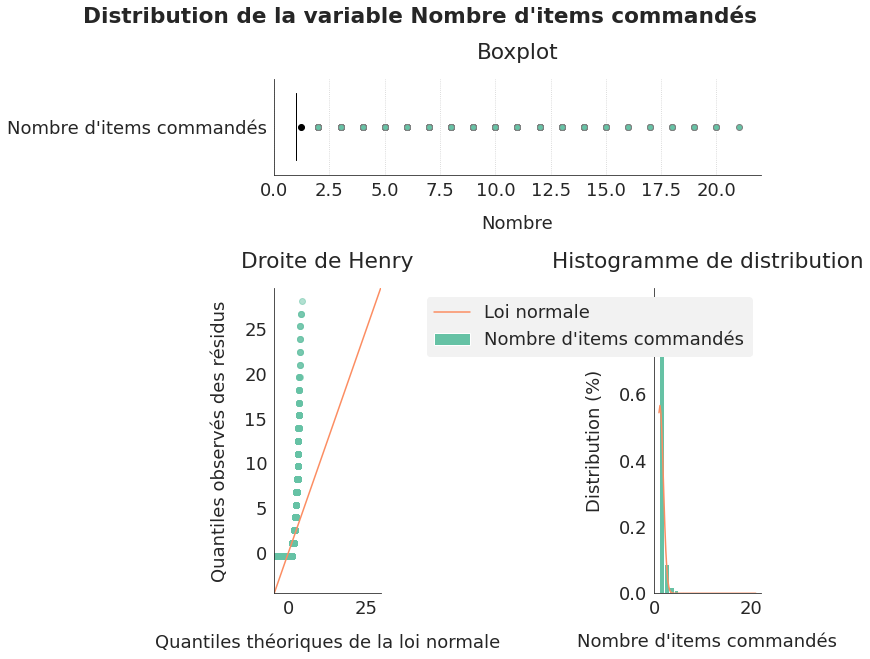

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_items.order_item_id,
                                           "Nombre d'items commandés",
                                           "Nombre")
plt.show()

En général, les clients ne commandent qu'une seule fois le même bien.

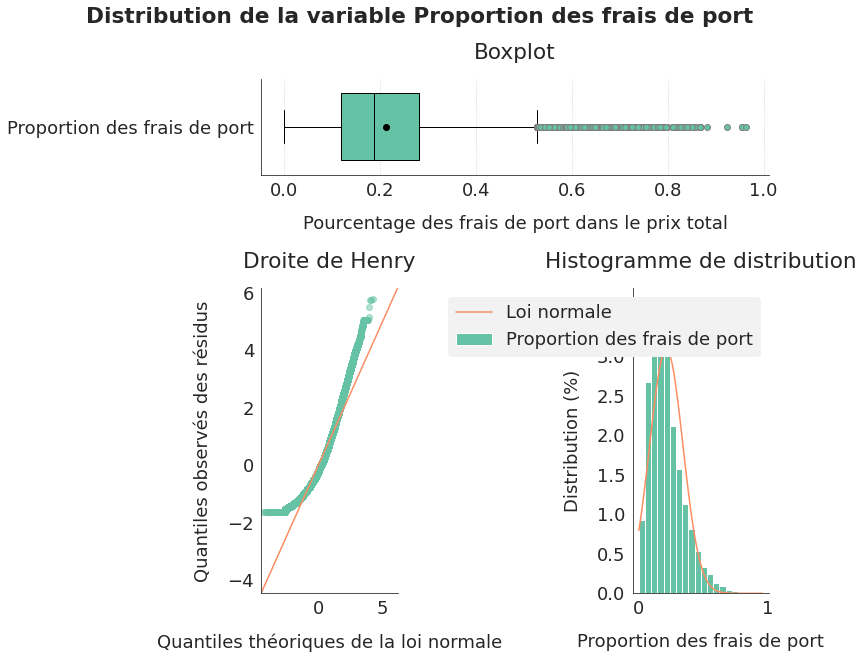

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    order_items.items_percent_freight_price,
    "Proportion des frais de port",
    "Pourcentage des frais de port dans le prix total")
plt.show()

Les frais de port sont assez élevés, avec une mmédiane et une moyenne proches de 20% du prix total.

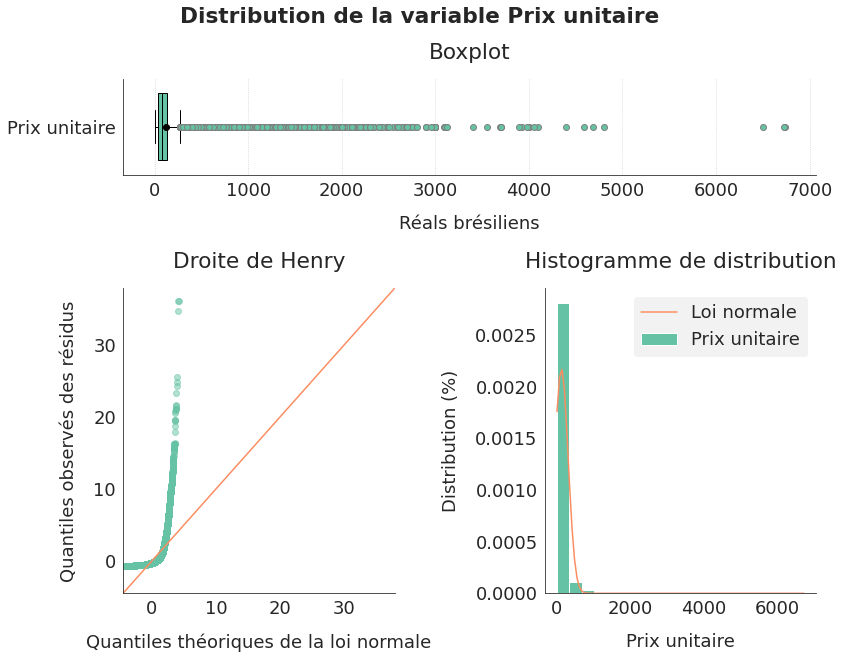

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_items.price,
                                           "Prix unitaire", "Réals brésiliens")
plt.show()

La plupart des biens vendus ont un prix contenu.

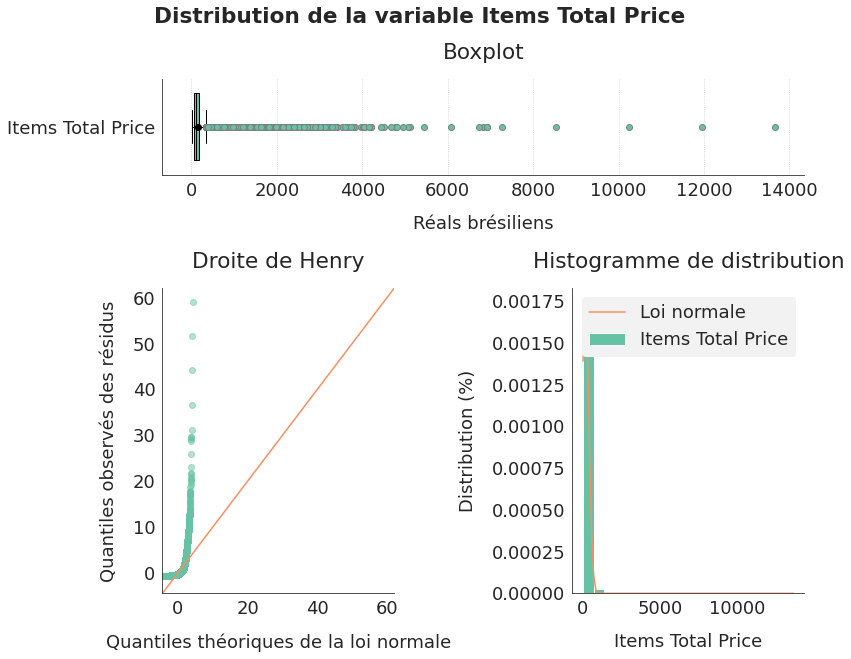

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(order_items.items_total_price,
                                           "Items Total Price",
                                           "Réals brésiliens")
plt.show()

On retrouve le même genre de distribution que pour les montants payés de order_payments.

---
<a id='4_0'></a>

## <font color=blue>4. Création du dataframe agrégé</font>

### 4.1. Order Items comme base

Le dataframe agrégé se base sur order_items. Il ne faut garder que les commandes qui ont le statut 'delivered'. On se base donc sur les order_id de la la base orders dont les commandes sont livrées.

In [ ]:
list_order_id = orders[orders.order_status == "delivered"].order_id
data = order_items[order_items.order_id.isin(list_order_id)].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108605 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     108605 non-null  object 
 1   order_item_id                108605 non-null  int64  
 2   product_id                   108605 non-null  object 
 3   seller_id                    108605 non-null  object 
 4   shipping_limit_date          108605 non-null  object 
 5   price                        108605 non-null  float64
 6   freight_value                108605 non-null  float64
 7   items_percent_freight_price  108605 non-null  float64
 8   items_total_price            108605 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 8.3+ MB


<a id='4_2'></a>

### 4.2. Ajout des informations sur l'acheteur (via orders), le vendeur et le produit

In [ ]:
data = data.merge(
    orders[["order_id", "customer_id", "order_purchase_timestamp"]],
    how="left", on="order_id")
data = data.merge(customers, how="left", on="customer_id")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108605 entries, 0 to 108604
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     108605 non-null  object 
 1   order_item_id                108605 non-null  int64  
 2   product_id                   108605 non-null  object 
 3   seller_id                    108605 non-null  object 
 4   shipping_limit_date          108605 non-null  object 
 5   price                        108605 non-null  float64
 6   freight_value                108605 non-null  float64
 7   items_percent_freight_price  108605 non-null  float64
 8   items_total_price            108605 non-null  float64
 9   customer_id                  108605 non-null  object 
 10  order_purchase_timestamp     108605 non-null  object 
 11  customer_unique_id           108605 non-null  object 
 12  customer_geolocation_lat     108316 non-null  float64
 13 

In [ ]:
data = data.merge(sellers, how="left", on="seller_id")
data = data.merge(products, how="left", on="product_id")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108605 entries, 0 to 108604
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     108605 non-null  object 
 1   order_item_id                108605 non-null  int64  
 2   product_id                   108605 non-null  object 
 3   seller_id                    108605 non-null  object 
 4   shipping_limit_date          108605 non-null  object 
 5   price                        108605 non-null  float64
 6   freight_value                108605 non-null  float64
 7   items_percent_freight_price  108605 non-null  float64
 8   items_total_price            108605 non-null  float64
 9   customer_id                  108605 non-null  object 
 10  order_purchase_timestamp     108605 non-null  object 
 11  customer_unique_id           108605 non-null  object 
 12  customer_geolocation_lat     108316 non-null  float64
 13 

Je peux ajouter deux informations intéressantes :
- distance entre l'acheteur et le vendeur ;
- délai maximum de livraison.

Je peux supprimer des informations dont je n'ai plus besoin :
- customer_id, customer_geolocation_lat, customer_geolocation_lng ;
- seller_geolocation_lat, seller_geolocation_lng ;
- shipping_limit_date.

In [ ]:
def calcul_distance_customer_seller(df):
    transformed = df.copy()
    R = 6371.0  # rayon de la terre
    inter_radians = np.radians(
        transformed[["customer_geolocation_lat", "customer_geolocation_lng",
                     "seller_geolocation_lat", "seller_geolocation_lng"]]
        .values)
    distance_lat = inter_radians[:, 0] - inter_radians[:, 2]
    distance_lng = inter_radians[:, 1] - inter_radians[:, 3]
    inter_distance = np.power(np.sin(distance_lat / 2), 2) \
        + np.cos(inter_radians[:, 0]) \
        * np.cos(inter_radians[:, 2]) \
        * np.power(np.sin(distance_lng / 2), 2)
    transformed["distance_customer_seller"] = R * 2 \
        * np.arctan2(np.sqrt(inter_distance), np.sqrt(1 - inter_distance))
    return transformed

In [ ]:
def data_prepare_items(df):
    transformed = calcul_distance_customer_seller(df)
    transformed["maximum_shipping_days"] = (pd.to_datetime(
        transformed.shipping_limit_date) - pd.to_datetime(
        transformed.order_purchase_timestamp)).dt.total_seconds() / 86400
    return transformed.drop(columns=["customer_id", "customer_geolocation_lat",
                                     "customer_geolocation_lng",
                                     "seller_geolocation_lat",
                                     "seller_geolocation_lng",
                                     "shipping_limit_date"])

In [ ]:
data = data_prepare_items(data)
data.head()

order_id  ...  maximum_shipping_days
0  00010242fe8c5a6d1ba2dd792cb16214  ...               6.032326
1  00018f77f2f0320c557190d7a144bdd3  ...               7.008414
2  000229ec398224ef6ca0657da4fc703e  ...               4.010405
3  00024acbcdf0a6daa1e931b038114c75  ...               7.006748
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...               9.000000

[5 rows x 18 columns]

Je regarde la distribution des variables créées.

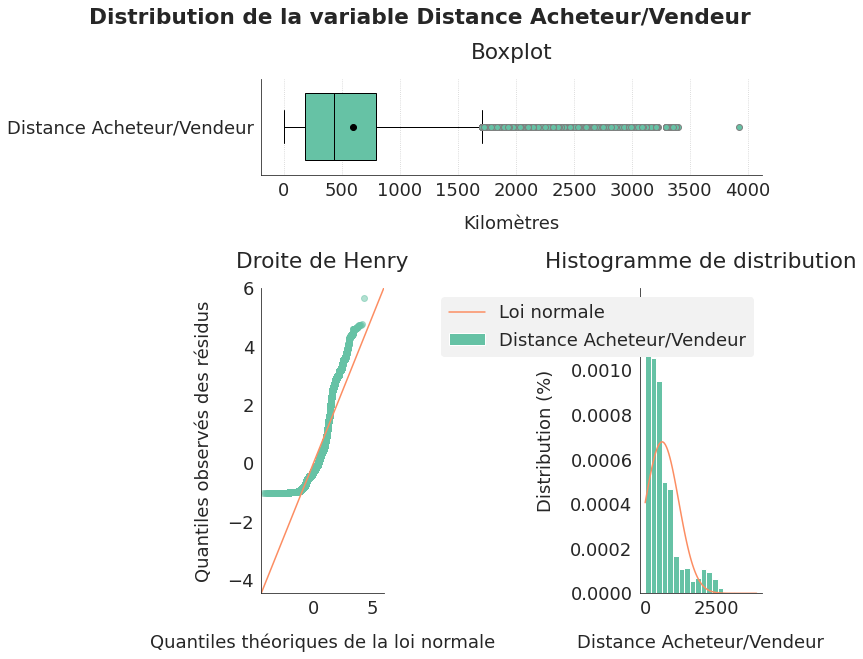

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data.distance_customer_seller.dropna(),
    "Distance Acheteur/Vendeur", "Kilomètres")
plt.show()

La plupart des commandes sont effectuées à des vendeurs proches. Attention, cela peut être biaisé par une grande concentration d'acheteurs et de vendeurs dans les grandes métropoles.

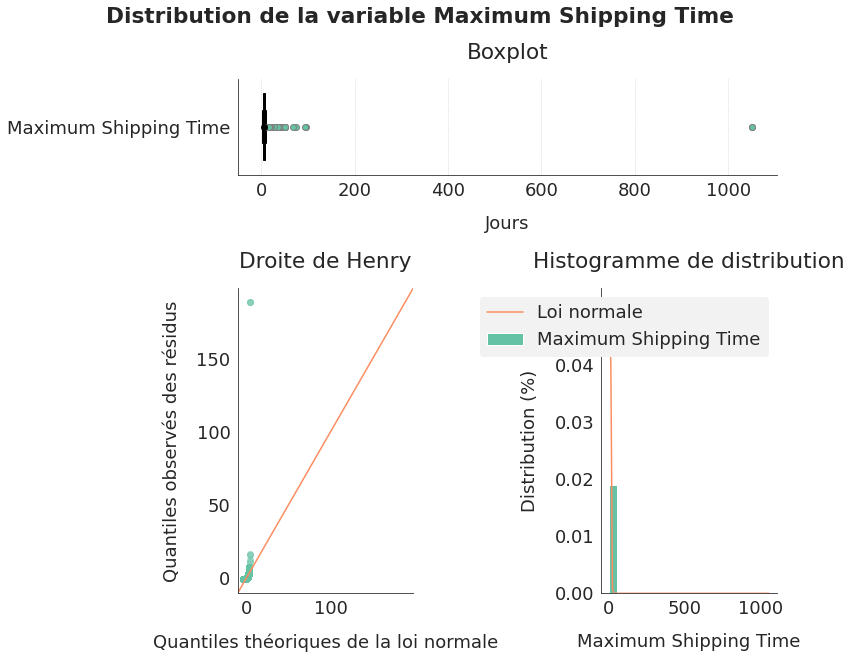

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data.maximum_shipping_days,
                                           "Maximum Shipping Time", "Jours")
plt.show()

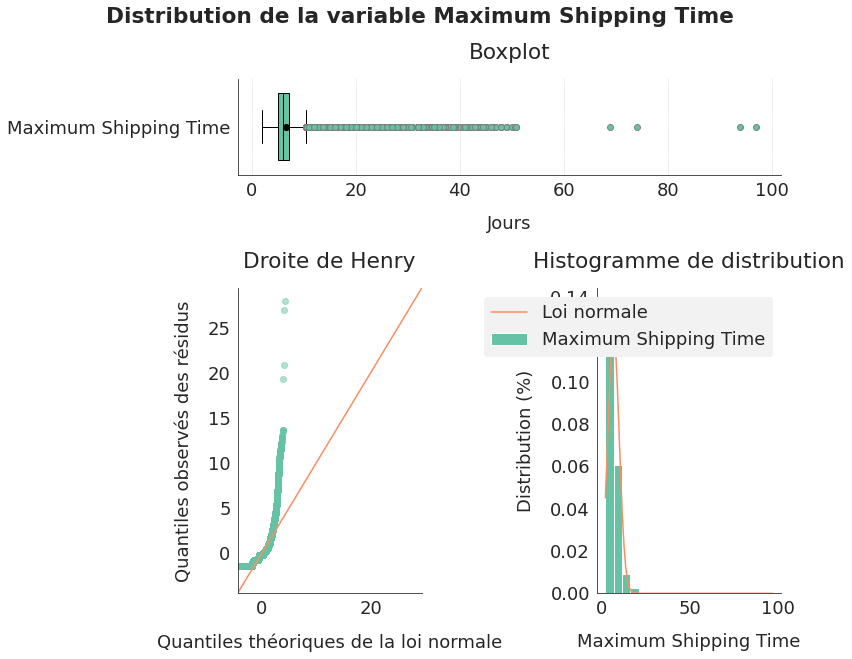

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data[data.maximum_shipping_days < 1000].maximum_shipping_days,
    "Maximum Shipping Time", "Jours")
plt.show()

Quasiment toutes les commandes se concentrent sur des biens disponibles rapidement (moins de 10 jours).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108605 entries, 0 to 108604
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     108605 non-null  object 
 1   order_item_id                108605 non-null  int64  
 2   product_id                   108605 non-null  object 
 3   seller_id                    108605 non-null  object 
 4   price                        108605 non-null  float64
 5   freight_value                108605 non-null  float64
 6   items_percent_freight_price  108605 non-null  float64
 7   items_total_price            108605 non-null  float64
 8   order_purchase_timestamp     108605 non-null  object 
 9   customer_unique_id           108605 non-null  object 
 10  product_name_lenght          107078 non-null  float64
 11  product_description_lenght   107078 non-null  float64
 12  product_photos_qty           107078 non-null  float64
 13 

Il y a très peu de valeurs manquantes. Je peux les imputer. Etant donné les déséquilibres dans la distribution des variables, j'impute par la médiane pour les variables quantitatives et par la classe la plus fréquente pour les variables qualitatives.

In [ ]:
def impute_data_items(df):
    transformed = df.copy()
    num_cols = ["product_name_lenght", "product_description_lenght",
                "product_photos_qty", "product_weight_g",
                "product_volume_cm3", "distance_customer_seller"]
    imp_median = \
        SimpleImputer(strategy="median").fit(transformed[num_cols].values)
    transformed.loc[:, num_cols] = \
        imp_median.transform(transformed[num_cols].values)
    categ_cols = ["product_category_global"]
    imp_mostfreq = SimpleImputer(strategy="most_frequent")\
        .fit(transformed[categ_cols].values)
    transformed.loc[:, categ_cols] = \
        imp_mostfreq.transform(transformed[categ_cols].values)
    return transformed

In [ ]:
data = impute_data_items(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108605 entries, 0 to 108604
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     108605 non-null  object 
 1   order_item_id                108605 non-null  int64  
 2   product_id                   108605 non-null  object 
 3   seller_id                    108605 non-null  object 
 4   price                        108605 non-null  float64
 5   freight_value                108605 non-null  float64
 6   items_percent_freight_price  108605 non-null  float64
 7   items_total_price            108605 non-null  float64
 8   order_purchase_timestamp     108605 non-null  object 
 9   customer_unique_id           108605 non-null  object 
 10  product_name_lenght          108605 non-null  float64
 11  product_description_lenght   108605 non-null  float64
 12  product_photos_qty           108605 non-null  float64
 13 

Il n'y a plus de valeurs manquantes. Je sauvegarde les données à ce stade dans data_items, pour avoir la possibilité de faire des analyses par client basées sur les articles plutôt que sur les commandes.

In [ ]:
data_items = data.copy()

<a id='4_3'></a>

### 4.3. Agrégation par commande

J'agrège les données par commandes :
- nombre d'articles dans le panier (somme des order_item_id)
- nombre de produits différents dans le panier (décompte des products_id)
- nombre de vendeurs différents dans le panier (décompte des sellers_id)
- prix total du panier (somme des items_total_price)
- pourcentage des frais de port du panier (somme des freight_value * order_item_id / prix total du panier)
- prix unitaire moyen des articles (basé sur price) ;  (min et max ?)
- pourcentage moyen des frais de port des articles (basé sur items_percent_freight_price) ;  (min et max ?)
- dépense moyenne pour chaque produit (basé sur items_total_price) ;  (min et max ?)
- dépense moyenne pour chaque vendeur (basé sur items_total_price) ;  (min et max ?)
- longueur moyenne des noms des produits ;  (min et max ?)
- longueur moyenne des descriptions des produits ;  (min et max ?)
- nombre moyen de photos des produits ;  (min et max ?)
- poids moyen des produits ;  (min et max ?)
- volume moyen des produits ;  (min et max ?)
- distance moyenne entre l'acheteur et le vendeur ;  (min et max ?)
- moyenne du délai maximum de livraison ;
- catégorie des produits (la catégorie du produit s'il n'y a qu'une catégorie, multiple sinon) ;
- nombre de catégories différentes de produits.

In [ ]:
# nombre d'articles et prix total du panier
data_orders = data[["order_id", "order_item_id",
                    "items_total_price"]].groupby("order_id").sum()
columns_names = ["items_number", "order_total_price"]

# nombre de produits et de vendeurs dans le panier
interdata = data[["order_id", "product_id",
                  "seller_id"]].groupby("order_id").count()
data_orders = data_orders.merge(interdata, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["products_number", "sellers_number"])

In [ ]:
# pourcentage des frais de port dans le prix total du panier
interdata = data[["order_id", "order_item_id",
                  "freight_value", "items_total_price"]].copy()
interdata["total_freight_value"] = \
    interdata.order_item_id * interdata.freight_value
interdata = interdata[["order_id", "total_freight_value",
                       "items_total_price"]].groupby("order_id").sum()
interdata["percent_freight_price"] = \
    interdata.total_freight_value / interdata.items_total_price
data_orders = data_orders.merge(interdata.percent_freight_price, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["percent_freight_price"])

In [ ]:
# prix unitaire moyen et pourcentage moyen des frais de port par article
interdata = data[["order_id", "price",
                  "items_percent_freight_price"]].groupby("order_id").mean()
data_orders = data_orders.merge(interdata, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["average_item_price", "average_item_percent_freight"])

In [ ]:
# dépense moyenne par produit et par vendeur
interdata = data[["order_id", "items_total_price"]].groupby("order_id").mean()
data_orders = data_orders.merge(interdata, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["average_product_expense"])
interdata = data[["order_id", "seller_id", "items_total_price"]]\
    .groupby(["order_id", "seller_id"]).sum().reset_index()
interdata = interdata.groupby("order_id").mean()
data_orders = data_orders.merge(interdata, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["average_seller_expense"])

In [ ]:
# longueur moyenne des noms et descriptions des produits,
# nombre moyen de photos, poids moyen et volume moyen,
# distance acheteur/vendeur moyenne
interdata = \
    data[["order_id", "product_name_lenght", "product_description_lenght",
          "product_photos_qty", "product_weight_g", "product_volume_cm3",
          "distance_customer_seller", "maximum_shipping_days"]]\
    .groupby("order_id").mean()
data_orders = data_orders.merge(interdata, how="left",
                                left_index=True, right_index=True)
columns_names.extend(["average_name_lenght", "average_description_lenght",
                      "average_photos_qty", "average_weight_g",
                      "average_volume_cm3", "average_distance_customer_seller",
                      "average_maximum_shipping_days"])

In [ ]:
# catégorie des produits achetés, ou multiple s'il y en a plusieurs
interdata = data[["order_id", "product_category_global"]]\
    .groupby("order_id").product_category_global.unique()
data_orders["products_category"] = [i[0] if len(i) == 1 else "multiple"
                                    for i in interdata]
data_orders["products_category_number"] = [len(i) for i in interdata]
columns_names.extend(["products_category", "products_category_number"])
data_orders.columns = columns_names
data_orders.reset_index()
data_orders.head()

items_number  ...  products_category_number
order_id                                        ...                          
00010242fe8c5a6d1ba2dd792cb16214             1  ...                         1
00018f77f2f0320c557190d7a144bdd3             1  ...                         1
000229ec398224ef6ca0657da4fc703e             1  ...                         1
00024acbcdf0a6daa1e931b038114c75             1  ...                         1
00042b26cf59d7ce69dfabb4e55b4fd9             1  ...                         1

[5 rows x 18 columns]

J'ajoute les informations de orders, orders_reviews et order_payments.

In [ ]:
data_orders = data_orders.merge(orders.drop(columns="order_status"),
                                how="left", on="order_id")
data_orders = \
    data_orders.merge(customers[["customer_id", "customer_unique_id"]],
                      how="left", on="customer_id")
data_orders = data_orders.merge(order_payments, how="left", on="order_id")
data_orders = data_orders.merge(order_reviews, how="left", on="order_id")
data_orders.drop(columns="customer_id", inplace=True)
data_orders.head()

order_id  ...  review_response_days
0  00010242fe8c5a6d1ba2dd792cb16214  ...                   1.0
1  00018f77f2f0320c557190d7a144bdd3  ...                   2.0
2  000229ec398224ef6ca0657da4fc703e  ...                   0.0
3  00024acbcdf0a6daa1e931b038114c75  ...                   0.0
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...                   1.0

[5 rows x 38 columns]

In [ ]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95105 entries, 0 to 95104
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   order_id                          95105 non-null  object 
 1   items_number                      95105 non-null  int64  
 2   order_total_price                 95105 non-null  float64
 3   products_number                   95105 non-null  int64  
 4   sellers_number                    95105 non-null  int64  
 5   percent_freight_price             95105 non-null  float64
 6   average_item_price                95105 non-null  float64
 7   average_item_percent_freight      95105 non-null  float64
 8   average_product_expense           95105 non-null  float64
 9   average_seller_expense            95105 non-null  float64
 10  average_name_lenght               95105 non-null  float64
 11  average_description_lenght        95105 non-null  float64
 12  aver

Il y a quelques valeurs manquantes sur les délais et les paiements. J'impute ces valeurs manquantes par la médiane, car il y a de forts outliers pour ces variables.

In [ ]:
def impute_data_orders(df):
    transformed = df.copy()
    num_cols = ["approbation_time", "shipping_time", "delivery_days",
                "delivery_lag", "payment_sequential", "payment_types_number",
                "payment_installments", "payment_value"]
    imp_median = \
        SimpleImputer(strategy="median").fit(transformed[num_cols].values)
    transformed.loc[:, num_cols] = \
        imp_median.transform(transformed[num_cols].values)
    categ_cols = ["payment_types"]
    imp_mostfreq = SimpleImputer(strategy="most_frequent")\
        .fit(transformed[categ_cols].values)
    transformed.loc[:, categ_cols] = \
        imp_mostfreq.transform(transformed[categ_cols].values)
    return transformed

In [ ]:
data_orders = impute_data_orders(data_orders)
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95105 entries, 0 to 95104
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   order_id                          95105 non-null  object 
 1   items_number                      95105 non-null  int64  
 2   order_total_price                 95105 non-null  float64
 3   products_number                   95105 non-null  int64  
 4   sellers_number                    95105 non-null  int64  
 5   percent_freight_price             95105 non-null  float64
 6   average_item_price                95105 non-null  float64
 7   average_item_percent_freight      95105 non-null  float64
 8   average_product_expense           95105 non-null  float64
 9   average_seller_expense            95105 non-null  float64
 10  average_name_lenght               95105 non-null  float64
 11  average_description_lenght        95105 non-null  float64
 12  aver

Il n'y a plus de données manquantes. Je peux maintenant regrouper par client en calculant les valeurs moyennes.

<a id='4_4'></a>

### 4.4. Agrégation par client

Je commence par calculer le nombre de commandes différentes par client.  
Je calcule aussi le nombre de mois différents où un client a fait une commande sur les 12 derniers mois complets, pour connaître sa fréquence de commande sur la dernière année. Cette fréquence sera donc au maximum égale à 13 (12 mois complets + le mois en cours).

In [ ]:
data_customers = data_orders[["customer_unique_id", "order_id"]]\
    .groupby("customer_unique_id").count()
columns_names = ["orders_number"]

In [ ]:
max_date = pd.to_datetime(data_orders.order_purchase_timestamp).dt.date.max()
min_date = datetime.date(max_date.year - 1, max_date.month, 1)
interdata = \
    data_orders[pd.to_datetime(data_orders.order_purchase_timestamp)
                >= pd.Timestamp(min_date)][["customer_unique_id",
                                            "order_purchase_year_month"]]\
    .groupby("customer_unique_id").order_purchase_year_month.nunique()
data_customers = data_customers.merge(interdata, how="left",
                                      left_index=True, right_index=True)
columns_names.extend(["last_year_orders_frequency"])

In [ ]:
interdata = \
    data_orders[["customer_unique_id", "items_number", "order_total_price",
                 "products_number", "sellers_number", "percent_freight_price",
                 "average_item_price", "average_product_expense",
                 "average_seller_expense", "average_name_lenght",
                 "average_description_lenght", "average_photos_qty",
                 "average_weight_g", "average_volume_cm3",
                 "average_distance_customer_seller",
                 "average_maximum_shipping_days", "products_category_number",
                 "approbation_time", "shipping_time", "delivery_days",
                 "delivery_lag", "payment_sequential", "payment_types_number",
                 "payment_installments", "payment_value", "review_score",
                 "comment_title_length", "comment_message_length",
                 "review_response_days"]].groupby("customer_unique_id").mean()
data_customers = data_customers.merge(interdata, how="left",
                                      left_index=True, right_index=True)
columns_names.extend(
    ["average_items_number", "average_total_price", "average_products_number",
     "average_sellers_number", "average_order_percent_freight",
     "average_item_price", "average_product_expense", "average_seller_expense",
     "average_name_lenght", "average_description_lenght", "average_photos_qty",
     "average_weight_g", "average_volume_cm3",
     "average_distance_customer_seller", "average_maximum_shipping_days",
     "average_products_category_number", "average_approbation_time",
     "average_shipping_time", "average_delivery_days", "average_delivery_lag",
     "average_payment_sequential", "average_payment_types_number",
     "average_payment_installments", "average_payment_value",
     "average_review_score", "average_comment_title_length",
     "average_comment_message_length", "average_review_response_days"])

In [ ]:
data_customers.columns = columns_names
data_customers.reset_index()
data_customers.head()

orders_number  ...  average_review_response_days
customer_unique_id                               ...                              
0000366f3b9a7992bf8c76cfdf3221e2              1  ...                           4.0
0000b849f77a49e4a4ce2b2a4ca5be3f              1  ...                           0.0
0000f46a3911fa3c0805444483337064              1  ...                           1.0
0000f6ccb0745a6a4b88665a16c9f078              1  ...                           1.0
0004aac84e0df4da2b147fca70cf8255              1  ...                           4.0

[5 rows x 30 columns]

In [ ]:
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92047 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   orders_number                     92047 non-null  int64  
 1   last_year_orders_frequency        74978 non-null  float64
 2   average_items_number              92047 non-null  float64
 3   average_total_price               92047 non-null  float64
 4   average_products_number           92047 non-null  float64
 5   average_sellers_number            92047 non-null  float64
 6   average_order_percent_freight     92047 non-null  float64
 7   average_item_price                92047 non-null  float64
 8   average_product_expense           92047 non-null  float64
 9   average_seller_expense            92047 non-null  float64
 10  average_name_lenght               92047 non-null  float64
 11  average_descri

Une valeur manquante pour la variable "last_year_orders_frequency" signifie que le client n'a pas commandé lors des 12 derniers mois complets. Je remplace donc les valeurs manquantes par 0.

In [ ]:
def impute_data_customers(df):
    transformed = df.copy()
    num_cols = ["last_year_orders_frequency"]
    imp_median = SimpleImputer(strategy="constant", fill_value=0)\
        .fit(transformed[num_cols].values)
    transformed.loc[:, num_cols] = \
        imp_median.transform(transformed[num_cols].values)
    return transformed

In [ ]:
data_customers = impute_data_customers(data_customers)

In [ ]:
data_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92047 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   orders_number                     92047 non-null  int64  
 1   last_year_orders_frequency        92047 non-null  float64
 2   average_items_number              92047 non-null  float64
 3   average_total_price               92047 non-null  float64
 4   average_products_number           92047 non-null  float64
 5   average_sellers_number            92047 non-null  float64
 6   average_order_percent_freight     92047 non-null  float64
 7   average_item_price                92047 non-null  float64
 8   average_product_expense           92047 non-null  float64
 9   average_seller_expense            92047 non-null  float64
 10  average_name_lenght               92047 non-null  float64
 11  average_descri

In [ ]:
data_customers.describe()

orders_number  ...  average_review_response_days
count   92047.000000  ...                  92047.000000
mean        1.033222  ...                      2.584597
std         0.208681  ...                      9.795304
min         1.000000  ...                      0.000000
25%         1.000000  ...                      1.000000
50%         1.000000  ...                      1.000000
75%         1.000000  ...                      3.000000
max        15.000000  ...                    518.000000

[8 rows x 30 columns]

<a id='4_5'></a>

### 4.5. Analyse univariée des variables agrégées par client

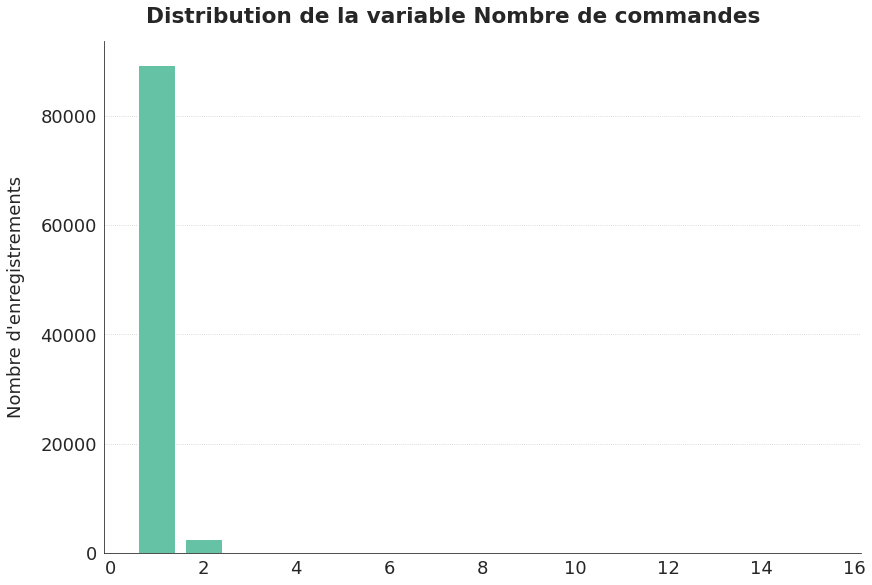

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(data_customers.orders_number,
                                           "Nombre de commandes",
                                           ticklabels_rotation=0)
save_fig("ML04_part1_univarie01_nb_commandes")
plt.show()

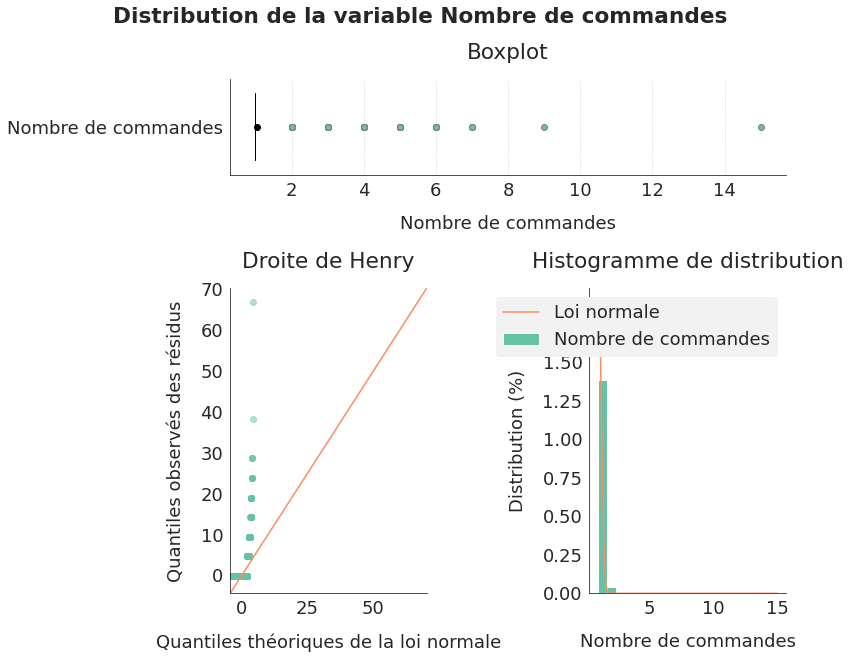

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.orders_number,
                                           "Nombre de commandes",
                                           "Nombre de commandes")
save_fig("ML04_part1_univarie01bis_nb_commandes")
plt.show()

La très grande majorité des clients n'a commandé qu'une fois. Quelques autres ont commandé 2 fois. Parmi les très rares qui ont commandé plus de 2 fois, certains ont commandé jusqu'à 16 fois.

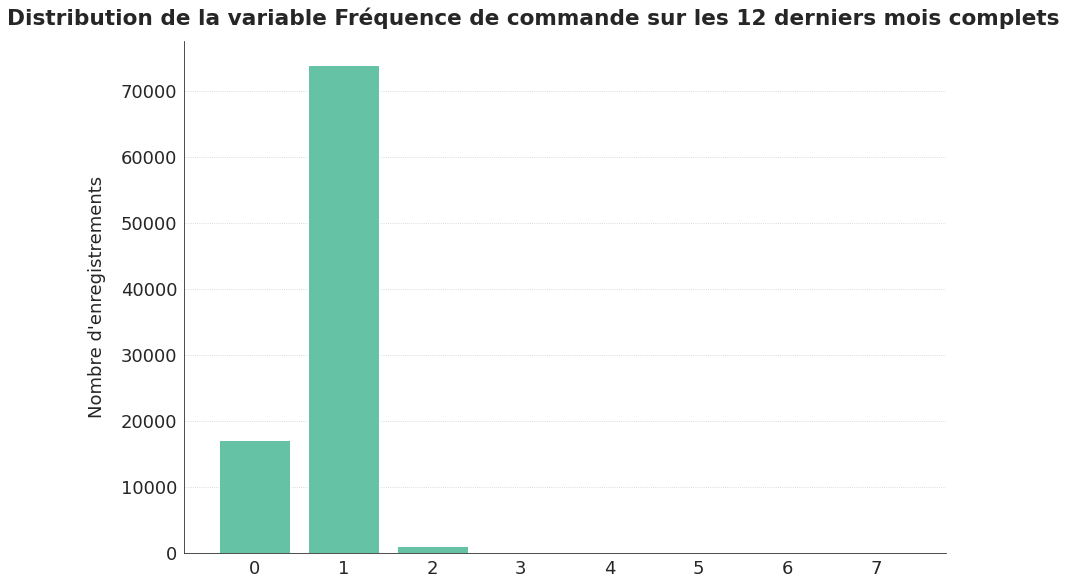

In [ ]:
fig, ax = sfg.graph_analyse_variable_categ(
    data_customers.last_year_orders_frequency,
    "Fréquence de commande sur les 12 derniers mois complets",
    ticklabels_rotation=0)
save_fig("ML04_part1_univarie02_frequence_commandes")
plt.show()

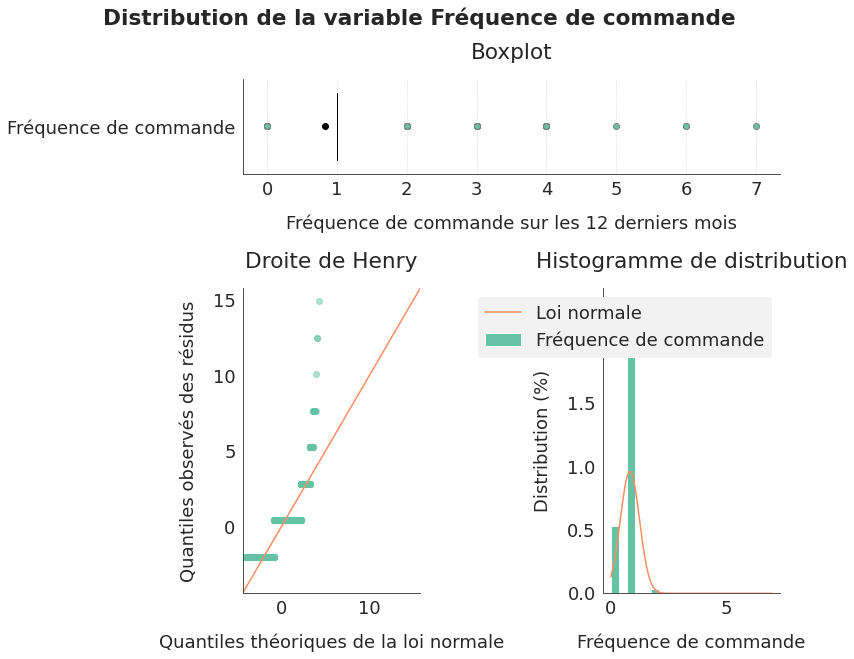

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.last_year_orders_frequency,
    "Fréquence de commande", "Fréquence de commande sur les 12 derniers mois")
save_fig("ML04_part1_univarie02bis_frequence_commandes")
plt.show()

Aucun client n'a commandé tous les mois lors des 12 derniers mois.

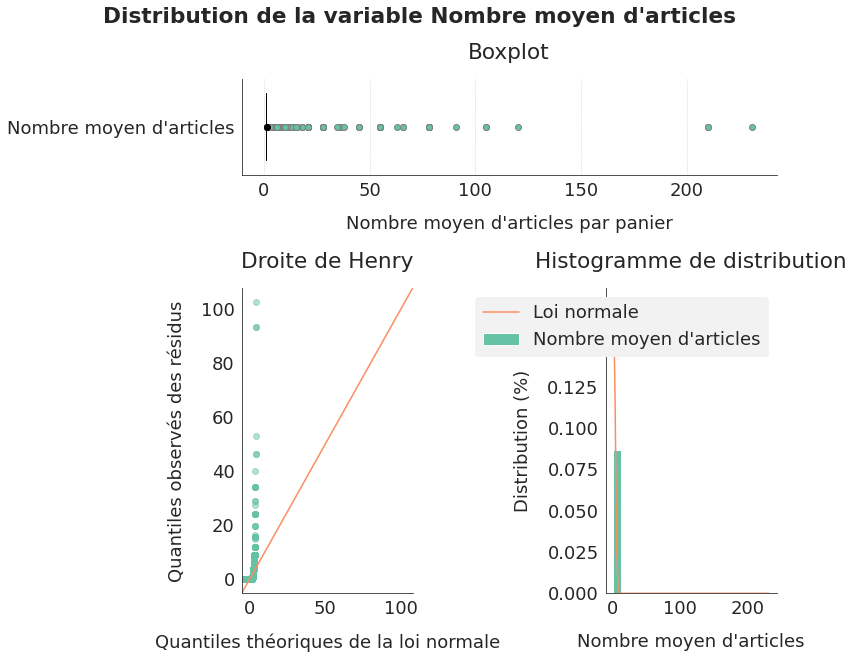

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_items_number,
    "Nombre moyen d'articles", "Nombre moyen d'articles par panier")
save_fig("ML04_part1_univarie03_nb_moyen_articles")
plt.show()

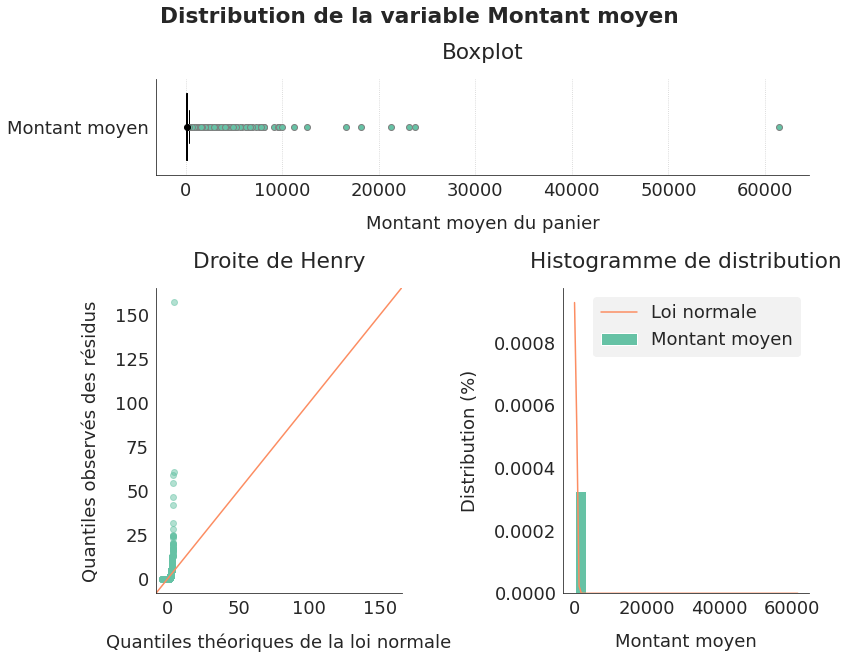

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_total_price,
                                           "Montant moyen",
                                           "Montant moyen du panier")
save_fig("ML04_part1_univarie04_montant_moyen")
plt.show()

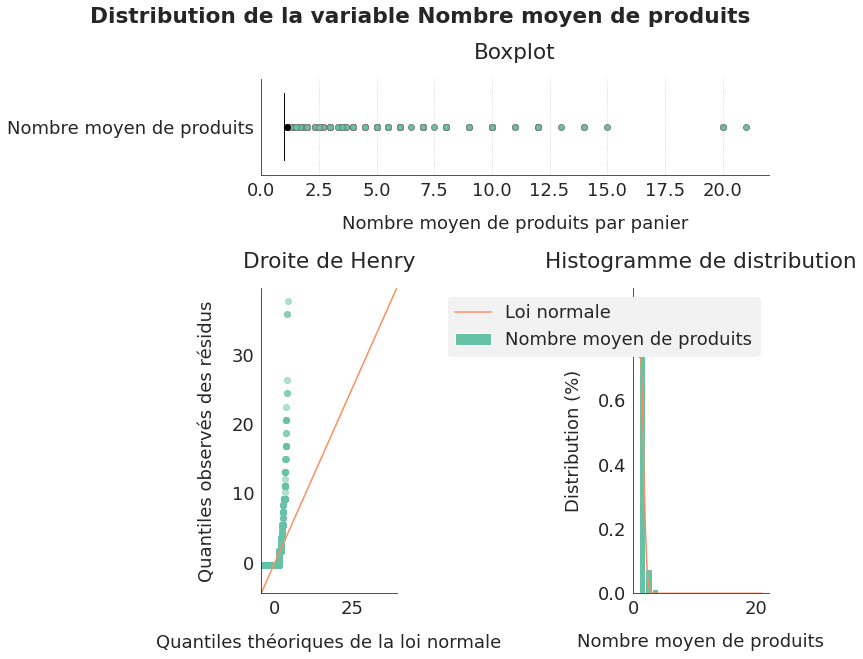

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_products_number,
    "Nombre moyen de produits", "Nombre moyen de produits par panier")
save_fig("ML04_part1_univarie05_nb_moyen_produits")
plt.show()

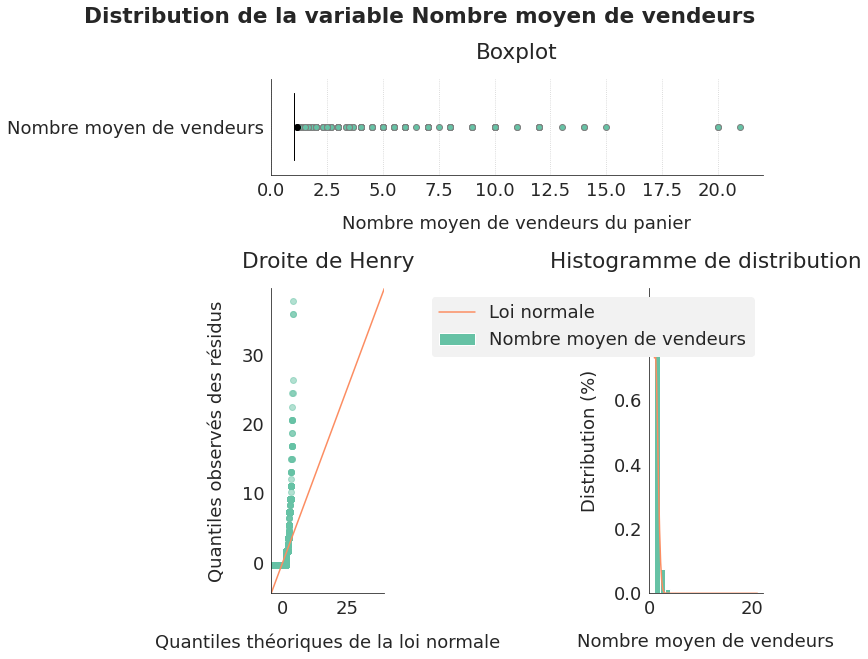

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_sellers_number,
    "Nombre moyen de vendeurs", "Nombre moyen de vendeurs du panier")
save_fig("ML04_part1_univarie06_nb_moyen_vendeurs")
plt.show()

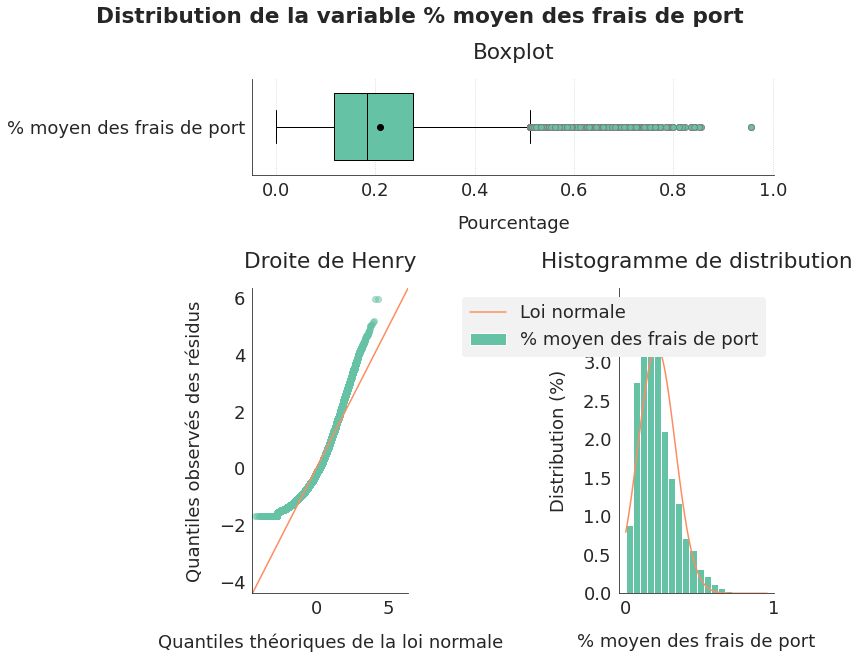

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_order_percent_freight,
    "% moyen des frais de port", "Pourcentage")
save_fig("ML04_part1_univarie07_percent_frais_port")
plt.show()

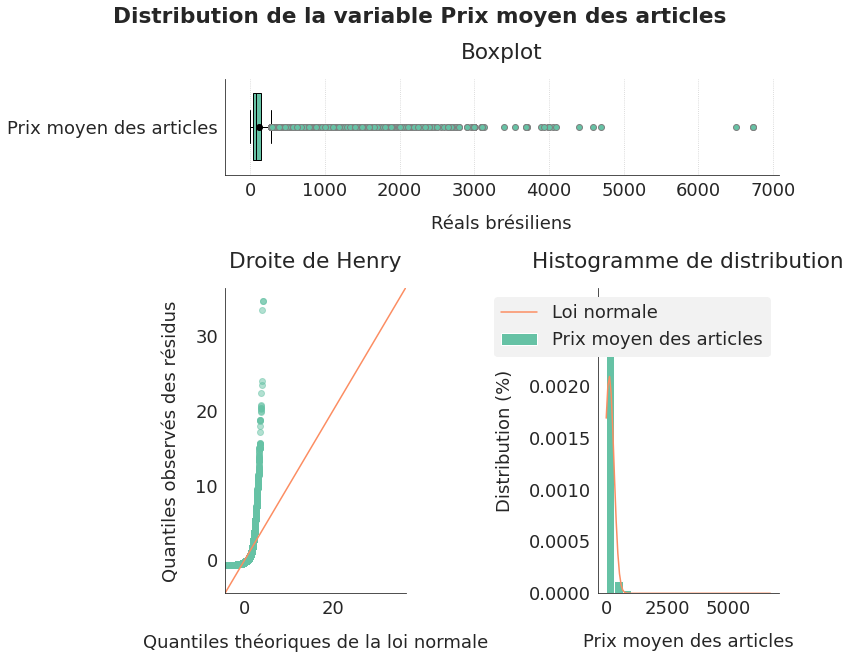

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_item_price,
                                           "Prix moyen des articles",
                                           "Réals brésiliens")
save_fig("ML04_part1_univarie08_prix_moyen_articles")
plt.show()

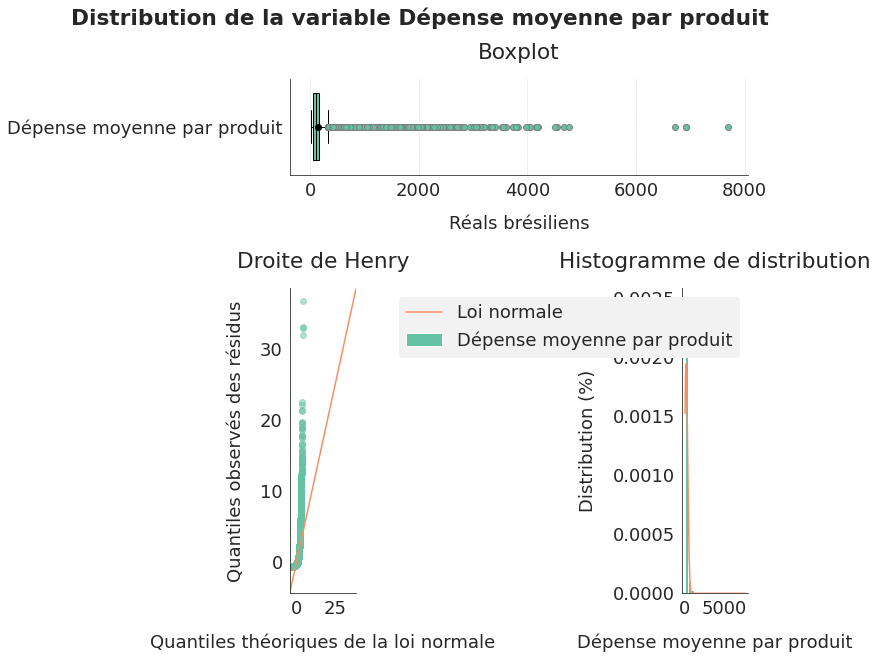

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_product_expense,
    "Dépense moyenne par produit", "Réals brésiliens")
save_fig("ML04_part1_univarie09_depense_moyenne_produit")
plt.show()

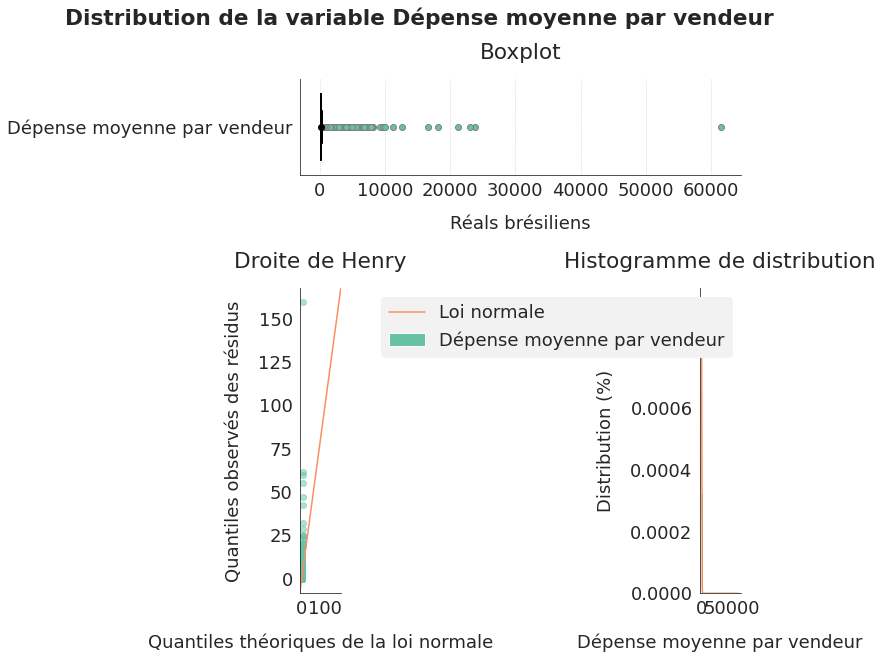

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_seller_expense,
    "Dépense moyenne par vendeur", "Réals brésiliens")
save_fig("ML04_part1_univarie10_depense_moyenne_vendeur")
plt.show()

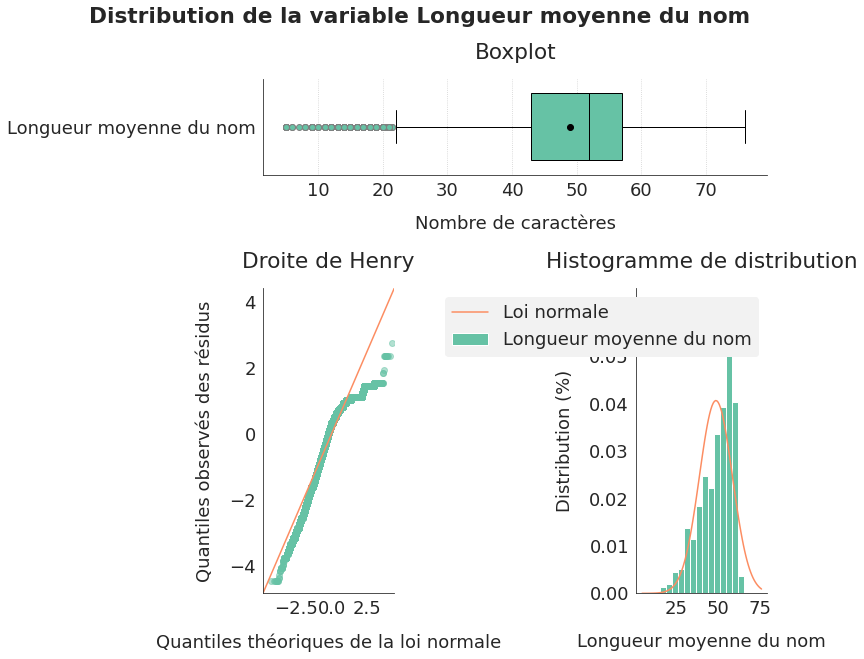

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_name_lenght,
                                           "Longueur moyenne du nom",
                                           "Nombre de caractères")
save_fig("ML04_part1_univarie11_longueur_moyenne_nom")
plt.show()

/content/drive/My Drive/MachineLearning/ML04/sf_graphiques.py:420: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


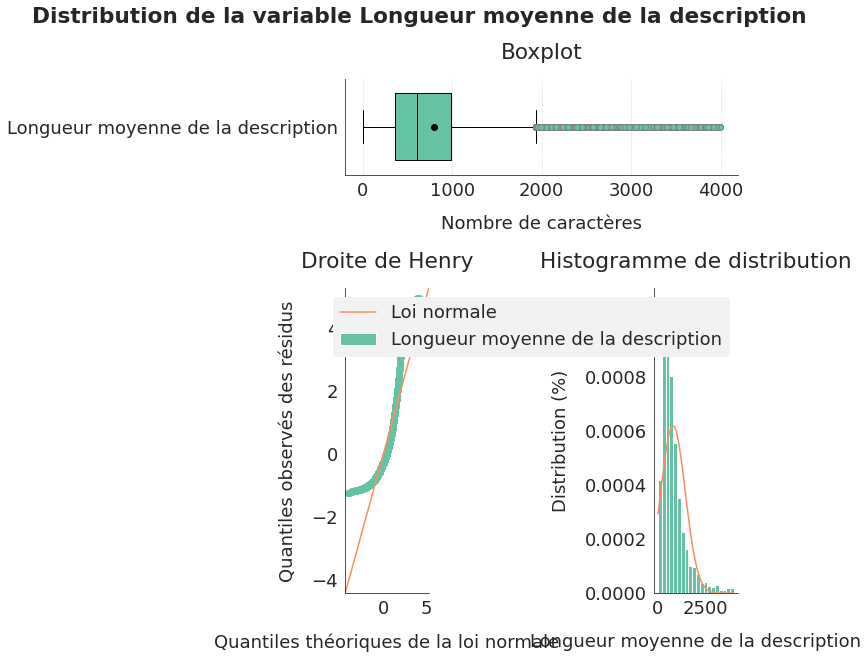

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_description_lenght,
    "Longueur moyenne de la description", "Nombre de caractères")
save_fig("ML04_part1_univarie12_longueur_moyenne_description")
plt.show()

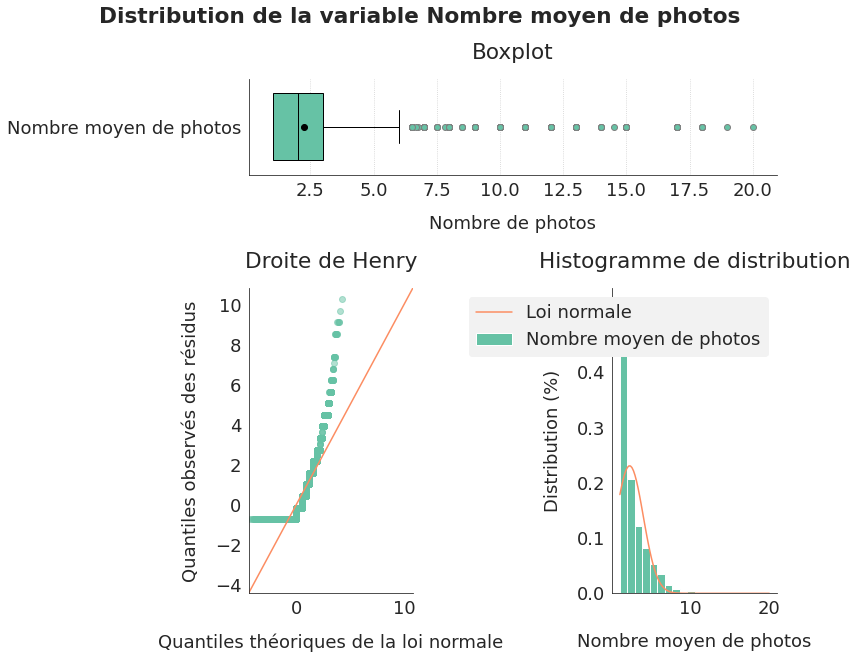

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_photos_qty,
                                           "Nombre moyen de photos",
                                           "Nombre de photos")
save_fig("ML04_part1_univarie13_nb_moyen_photos")
plt.show()

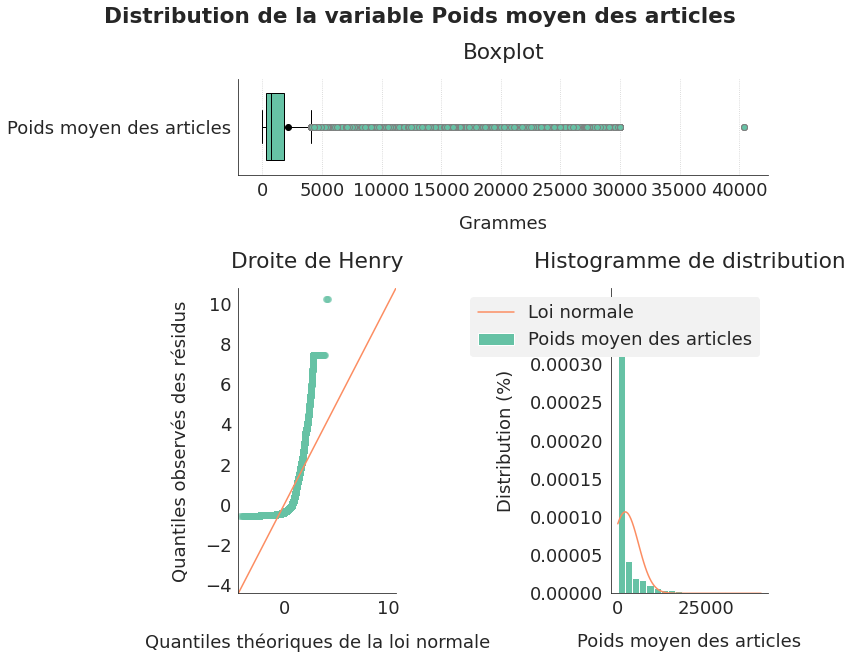

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_weight_g,
                                           "Poids moyen des articles",
                                           "Grammes")
save_fig("ML04_part1_univarie14_poids_moyen_articles")
plt.show()

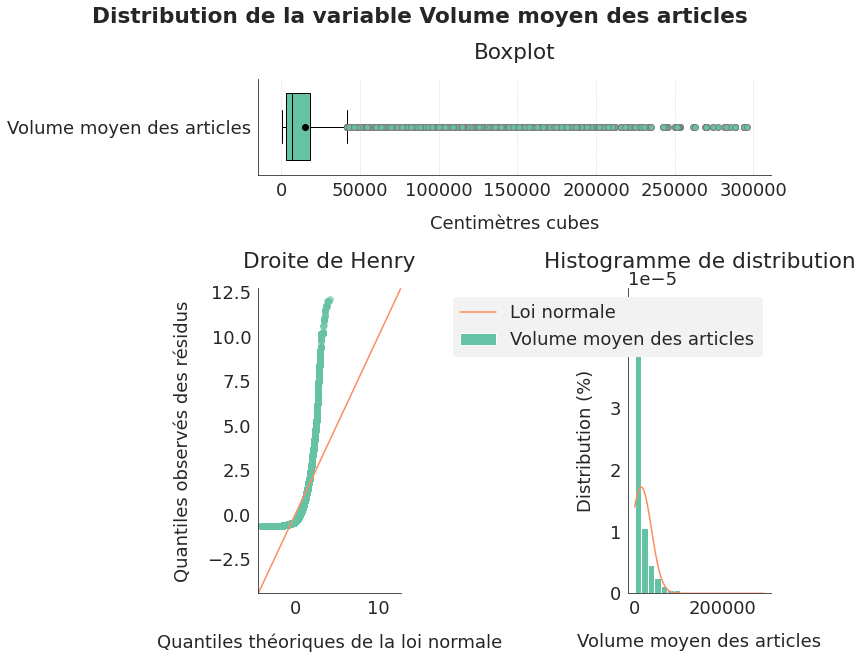

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_volume_cm3,
                                           "Volume moyen des articles",
                                           "Centimètres cubes")
save_fig("ML04_part1_univarie15_volume_moyen_articles")
plt.show()

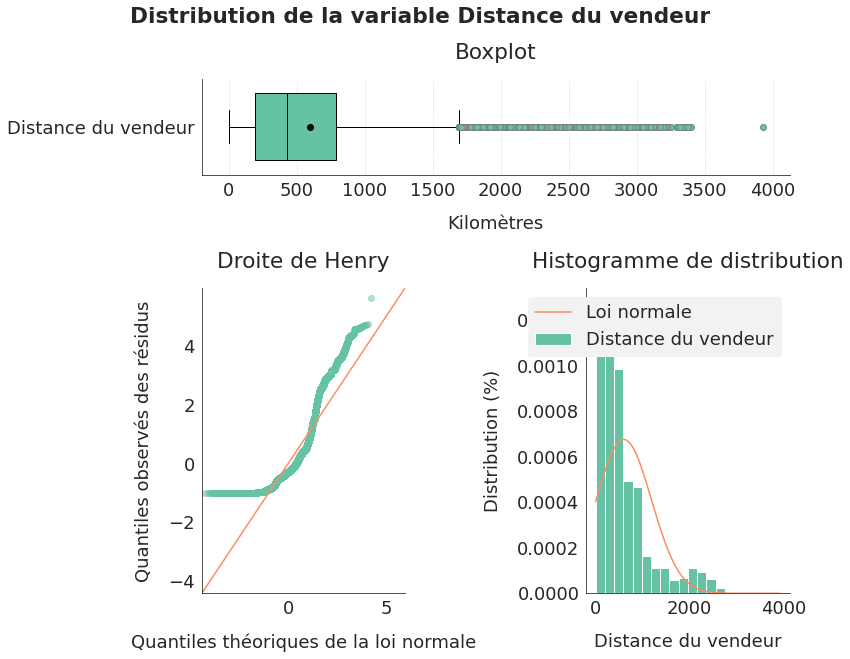

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_distance_customer_seller,
    "Distance du vendeur", "Kilomètres")
save_fig("ML04_part1_univarie16_distance_vendeur")
plt.show()

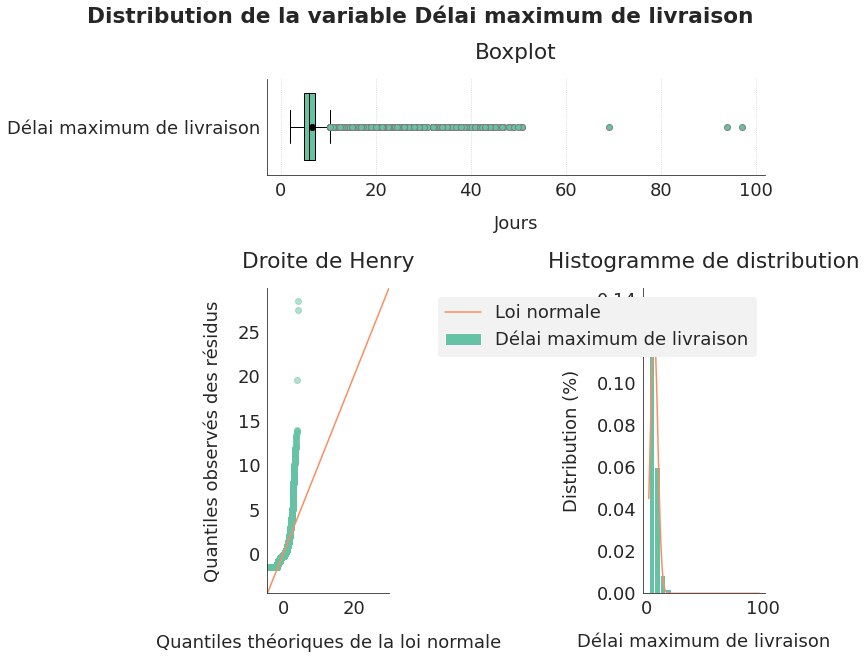

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers[data_customers.average_maximum_shipping_days < 500]
    .average_maximum_shipping_days,
    "Délai maximum de livraison", "Jours")
save_fig("ML04_part1_univarie17_delai_max_livraison")
plt.show()

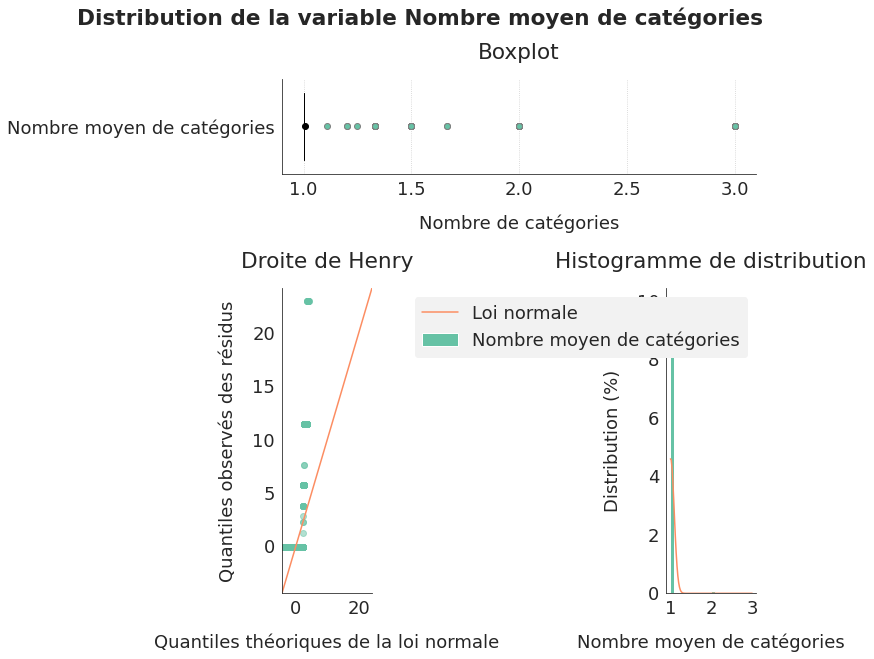

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_products_category_number,
    "Nombre moyen de catégories", "Nombre de catégories")
save_fig("ML04_part1_univarie18_nb_moyen_categories")
plt.show()

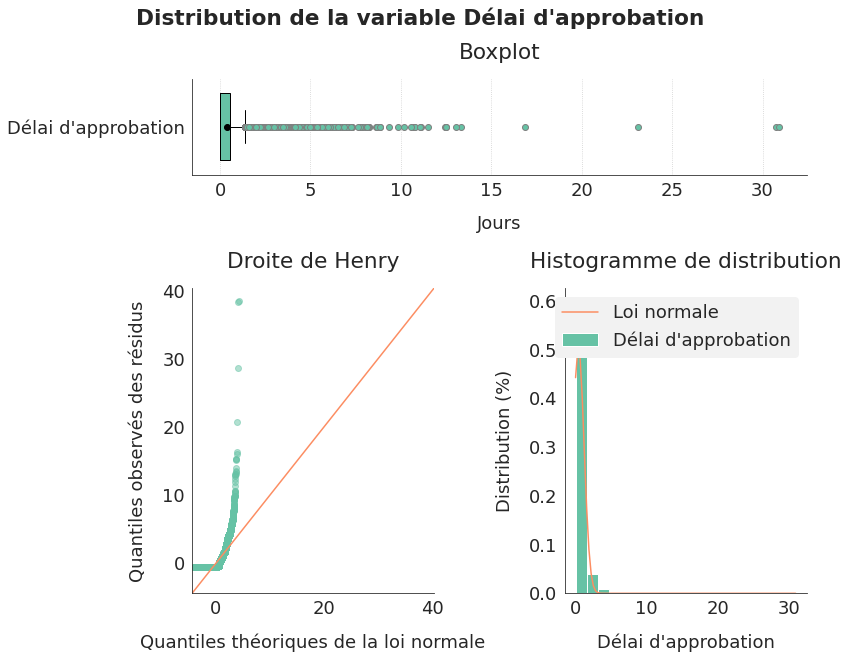

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_approbation_time,
    "Délai d'approbation", "Jours")
save_fig("ML04_part1_univarie19_delai_approbation")
plt.show()

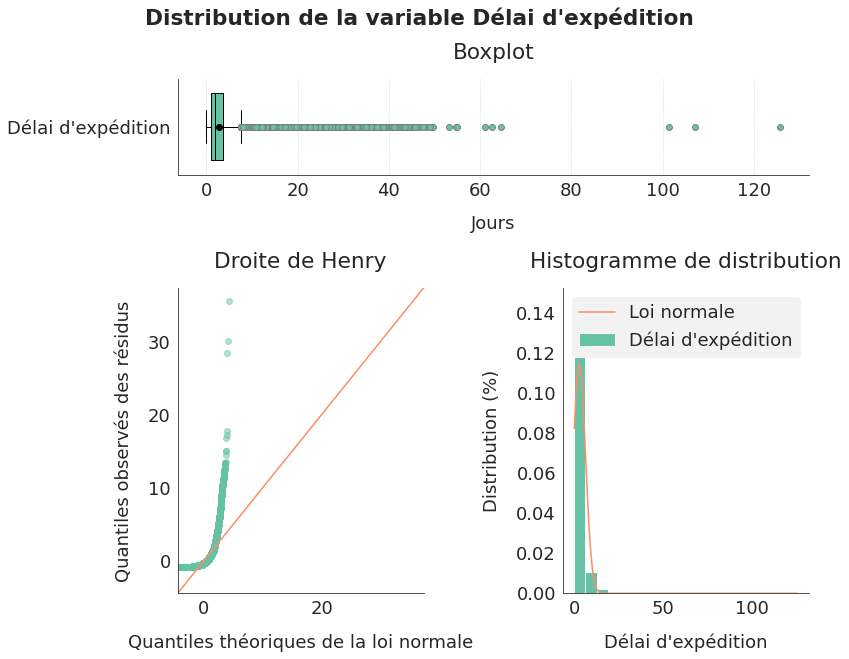

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_shipping_time,
    "Délai d'expédition", "Jours")
save_fig("ML04_part1_univarie20_delai_expedition")
plt.show()

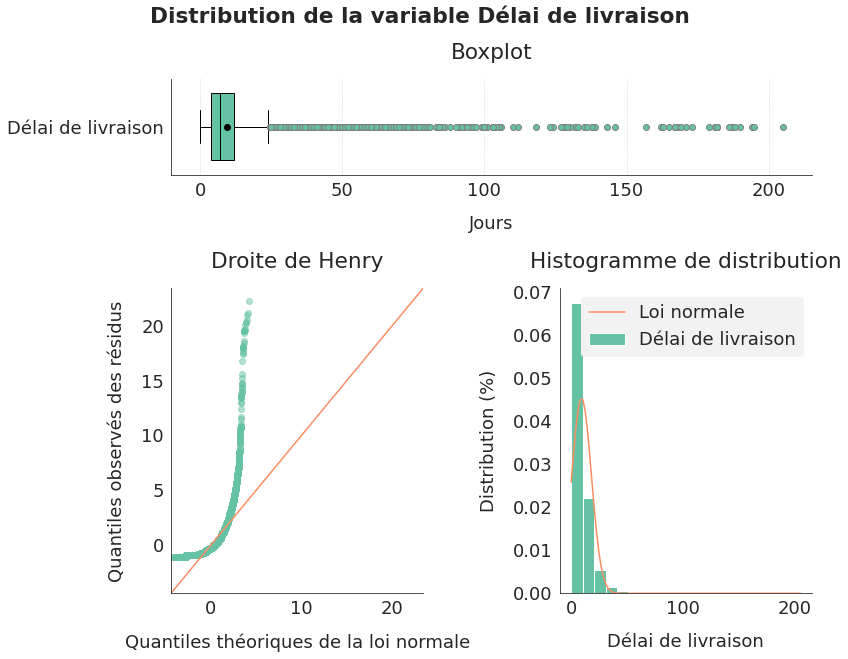

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_delivery_days,
    "Délai de livraison", "Jours")
save_fig("ML04_part1_univarie21_delai_livraison")
plt.show()

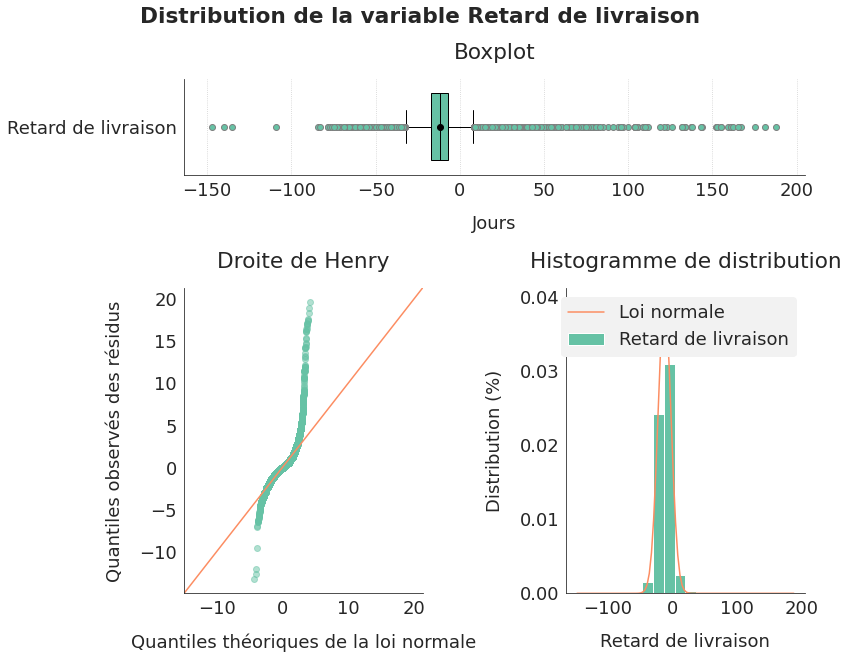

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_delivery_lag,
    "Retard de livraison", "Jours")
save_fig("ML04_part1_univarie22_retard_livraison")
plt.show()

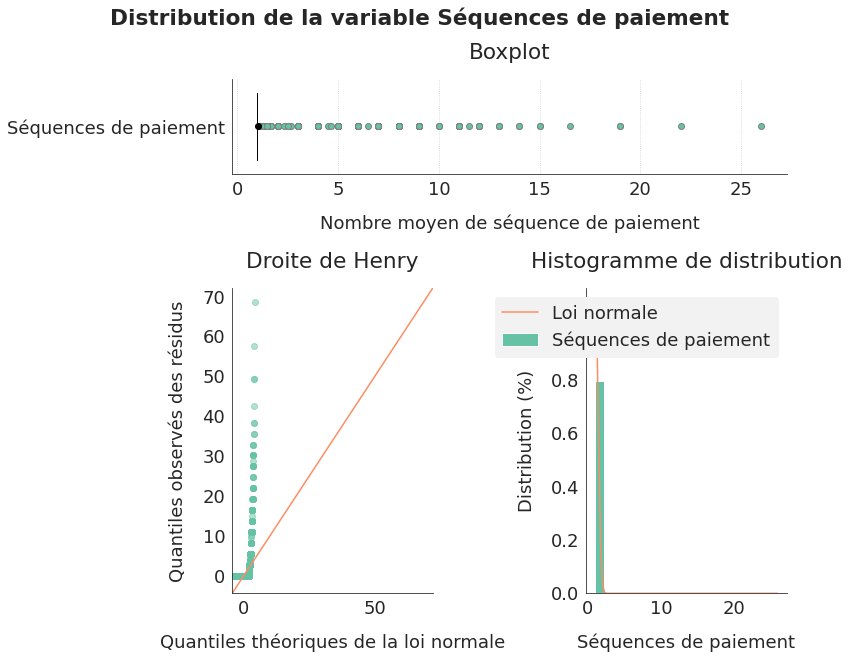

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_payment_sequential,
    "Séquences de paiement", "Nombre moyen de séquence de paiement")
save_fig("ML04_part1_univarie23_sequences_paiement")
plt.show()

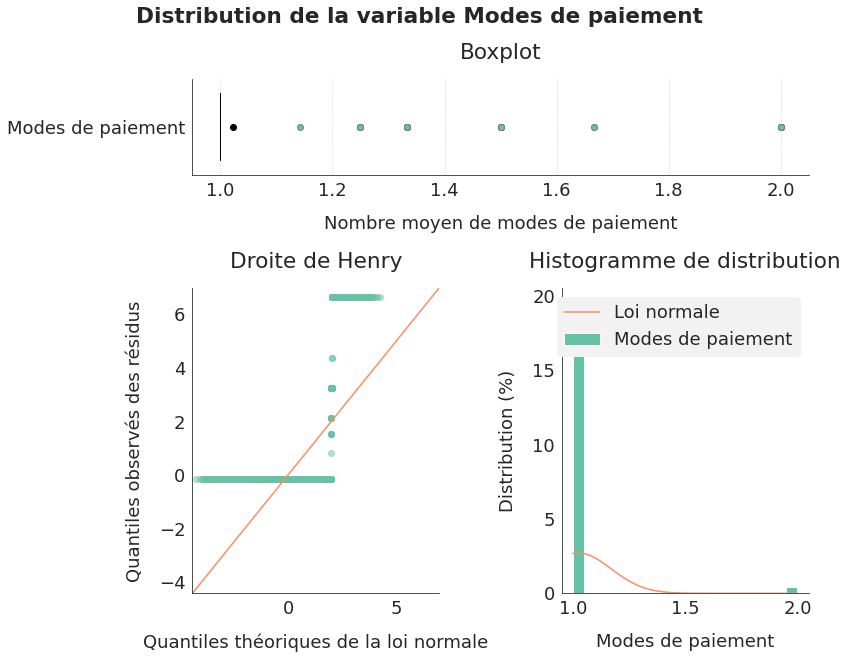

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_payment_types_number,
    "Modes de paiement", "Nombre moyen de modes de paiement")
save_fig("ML04_part1_univarie24_moyens_paiement")
plt.show()

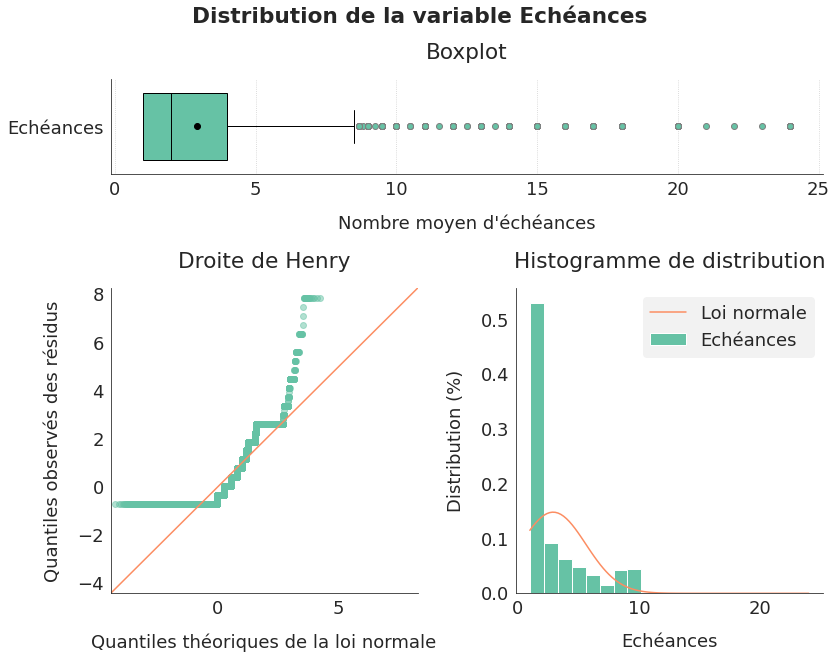

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_payment_installments,
    "Echéances", "Nombre moyen d'échéances")
save_fig("ML04_part1_univarie25_echeances")
plt.show()

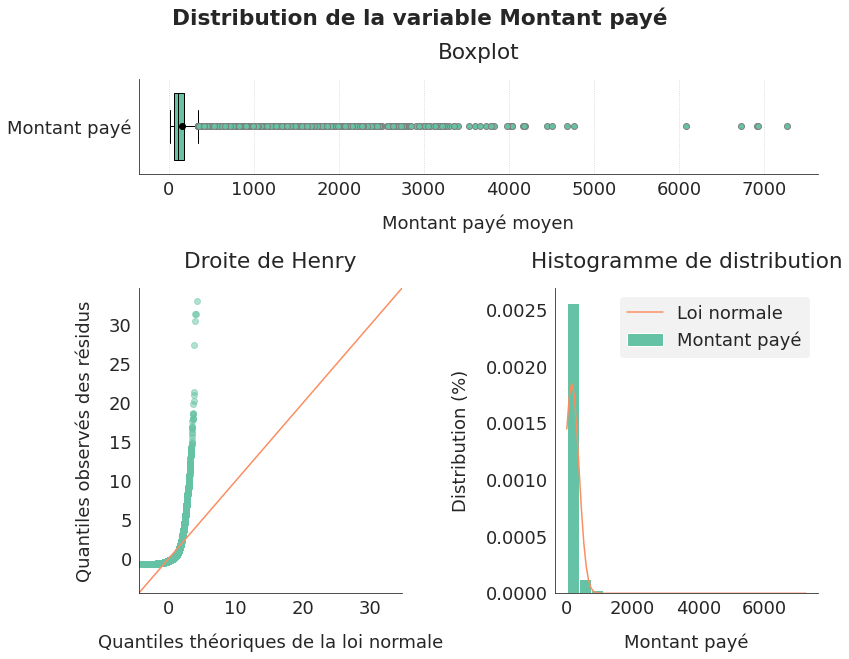

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers[data_customers.average_payment_value < 10000]
    .average_payment_value, "Montant payé", "Montant payé moyen")
save_fig("ML04_part1_univarie26_montant_paye")
plt.show()

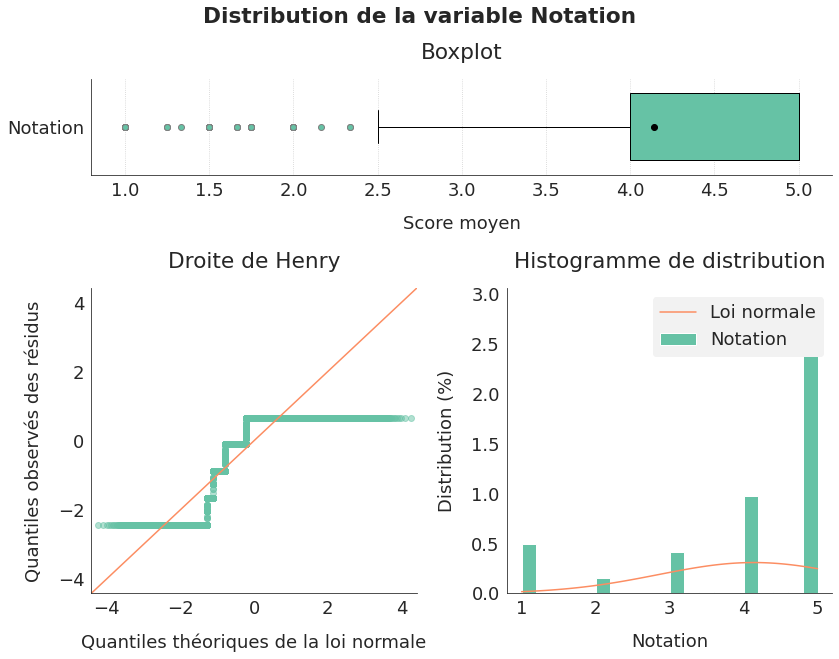

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(data_customers.average_review_score,
                                           "Notation",
                                           "Score moyen")
save_fig("ML04_part1_univarie27_score_moyen")
plt.show()

/content/drive/My Drive/MachineLearning/ML04/sf_graphiques.py:420: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


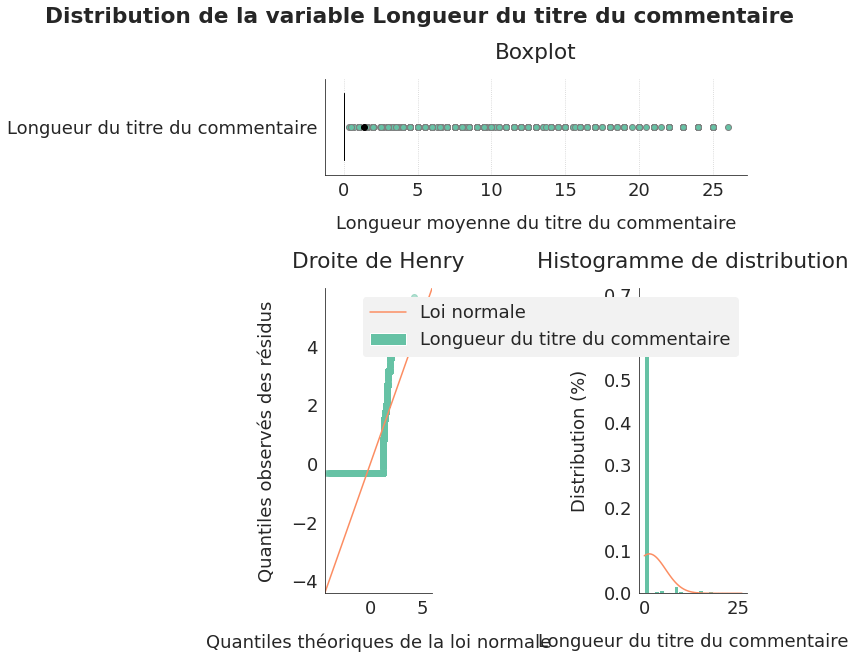

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_comment_title_length,
    "Longueur du titre du commentaire",
    "Longueur moyenne du titre du commentaire")
save_fig("ML04_part1_univarie28_longueur_titre")
plt.show()

/content/drive/My Drive/MachineLearning/ML04/sf_graphiques.py:420: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


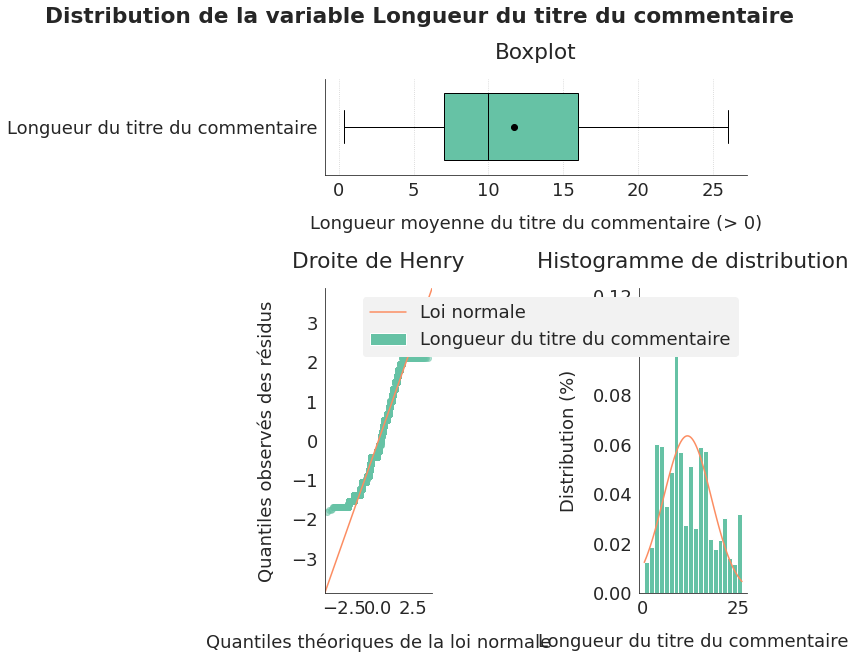

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers[data_customers.average_comment_title_length > 0]
    .average_comment_title_length, "Longueur du titre du commentaire",
    "Longueur moyenne du titre du commentaire (> 0)")
save_fig("ML04_part1_univarie29_longueur_titre_bis")
plt.show()

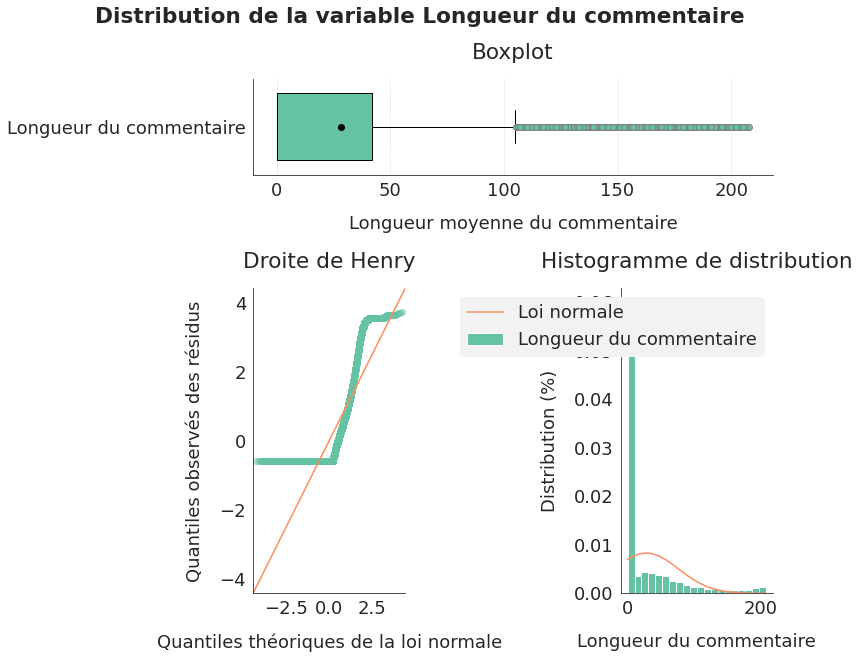

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_comment_message_length,
    "Longueur du commentaire", "Longueur moyenne du commentaire")
save_fig("ML04_part1_univarie30_longueur_commentaire")
plt.show()

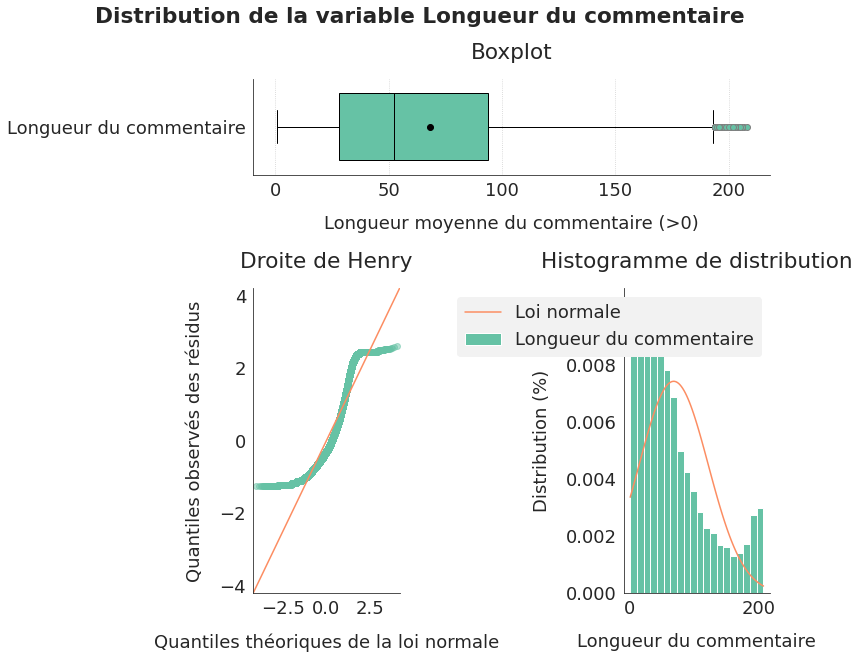

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers[data_customers.average_comment_message_length > 0]
    .average_comment_message_length,
    "Longueur du commentaire", "Longueur moyenne du commentaire (>0)")
save_fig("ML04_part1_univarie31_longueur_commentaire_bis")
plt.show()

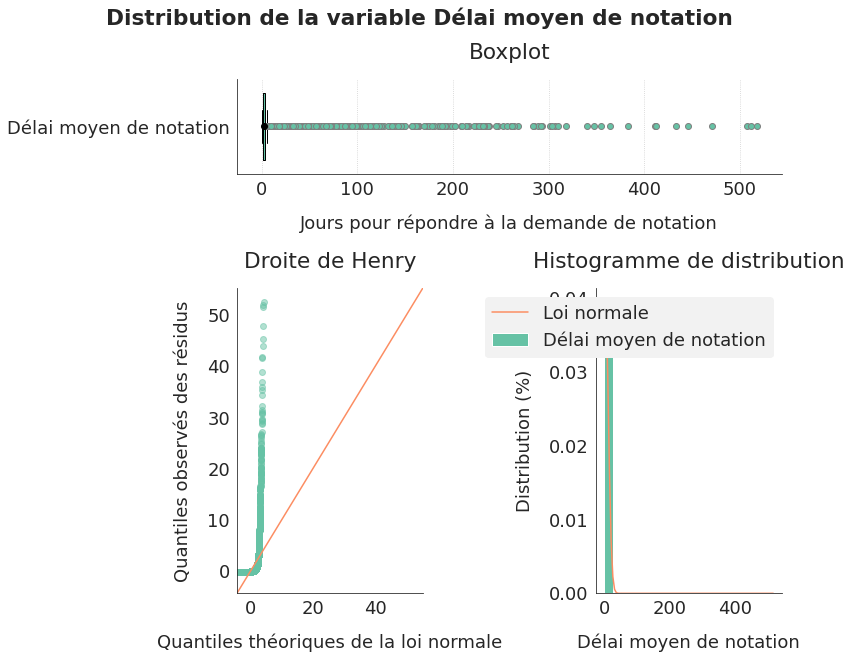

In [ ]:
fig, ax = sfg.graph_analyse_variable_quant(
    data_customers.average_review_response_days,
    "Délai moyen de notation", "Jours pour répondre à la demande de notation")
save_fig("ML04_part1_univarie32_delai_moyen_notation")
plt.show()

**Conclusions de l'analyse univariée**

Beaucoup de variables ont des valeurs très concentrées, qui rendront difficiles la segmentation des clients : orders_number, last_year_orders_frequency, average_items_number, average_products_number, average_sellers_number, average_products_category_number, average_payment_sequential, average_payment_types_number, average_review_response_days.

D'autres variables semblent plus adaptées pour segmenter les clients :
- sur la base du type de dépense : average_total_price, average_order_percent_freight, average_item_price, average_product_expense, average_seller_expense, average_payment_installments, average_payment_value (remarque : les variables average_total_price et average_payment_value devraient être très liées, ainsi que les variables average_item_price et average_product_expense - et sans doute average_seller_expense).
- sur la base du type de produits : average_name_lenght, average_description_lenght, average_photos_qty, average_weight_g, average_volume_cm3, average_distance_customer_seller, average_maximum_shipping_days.
- sur la base du type de la satisfaction et de la rapidité de traitement (qui peuvent être liés) : verage_approbation_time, average_shipping_time, average_delivery_days, average_delivery_lag, average_review_score, average_comment_title_length, average_comment_message_length.

<a id='4_6'></a>

### 4.6. Analyse bivariée des variables agrégées par client

In [ ]:
valeurs = data_customers.corr()
for lin in np.arange(0, valeurs.shape[0]):
    for col in np.arange(0, lin, 1):
        valeurs.iloc[lin, col] = np.nan
annotations = np.round(valeurs, 2)

In [ ]:
valeurs.shape

(30, 30)

Je vais afficher 15 variables par 15 variables pour que la matrice de corrélation soit lisible. Soit 3 matrices de corrélation.

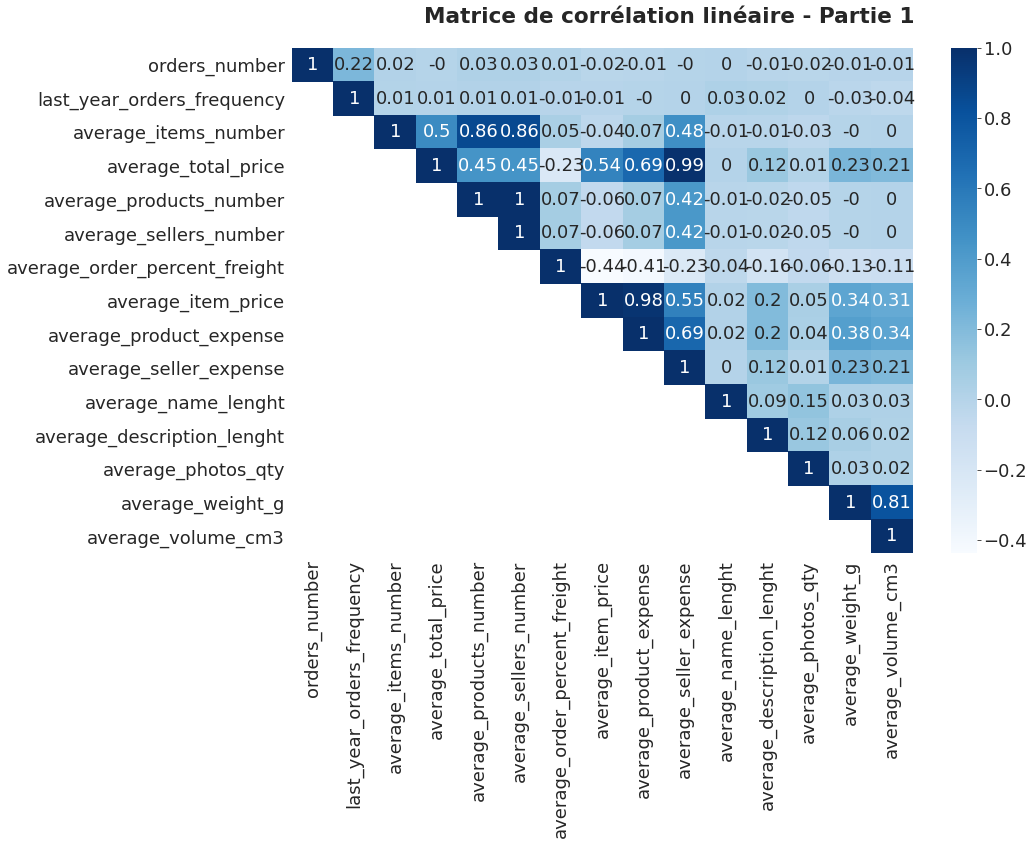

In [ ]:
graph = sfg.MyGraph("Matrice de corrélation linéaire - Partie 1",
                    figsize=(12, 8))
graph.add_sns_heatmap(valeurs.iloc[:15, :15],
                      annotations=annotations.iloc[:15, :15])
fig, ax = graph.fig, graph.ax
save_fig("ML04_part1_bivarie01")
plt.show()

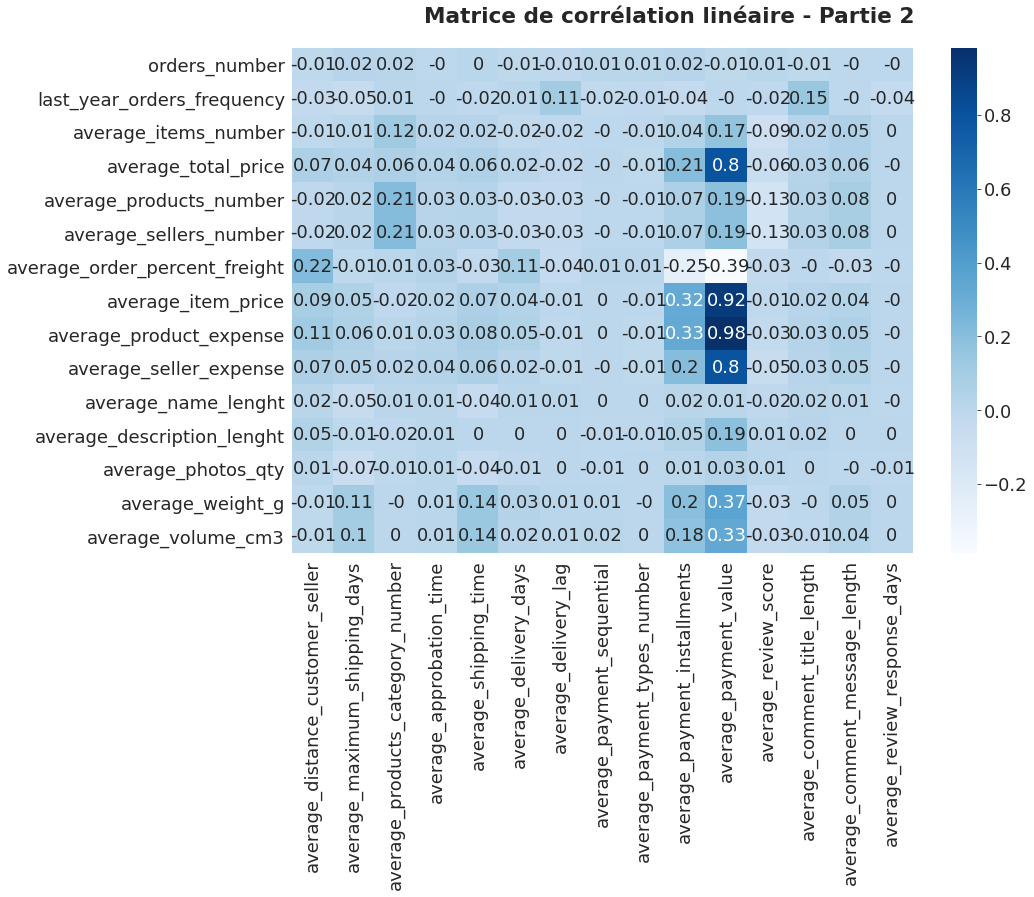

In [ ]:
graph = sfg.MyGraph("Matrice de corrélation linéaire - Partie 2",
                    figsize=(12, 8))
graph.add_sns_heatmap(valeurs.iloc[:15, 15:],
                      annotations=annotations.iloc[:15, 15:])
fig, ax = graph.fig, graph.ax
save_fig("ML04_part1_bivarie02")
plt.show()

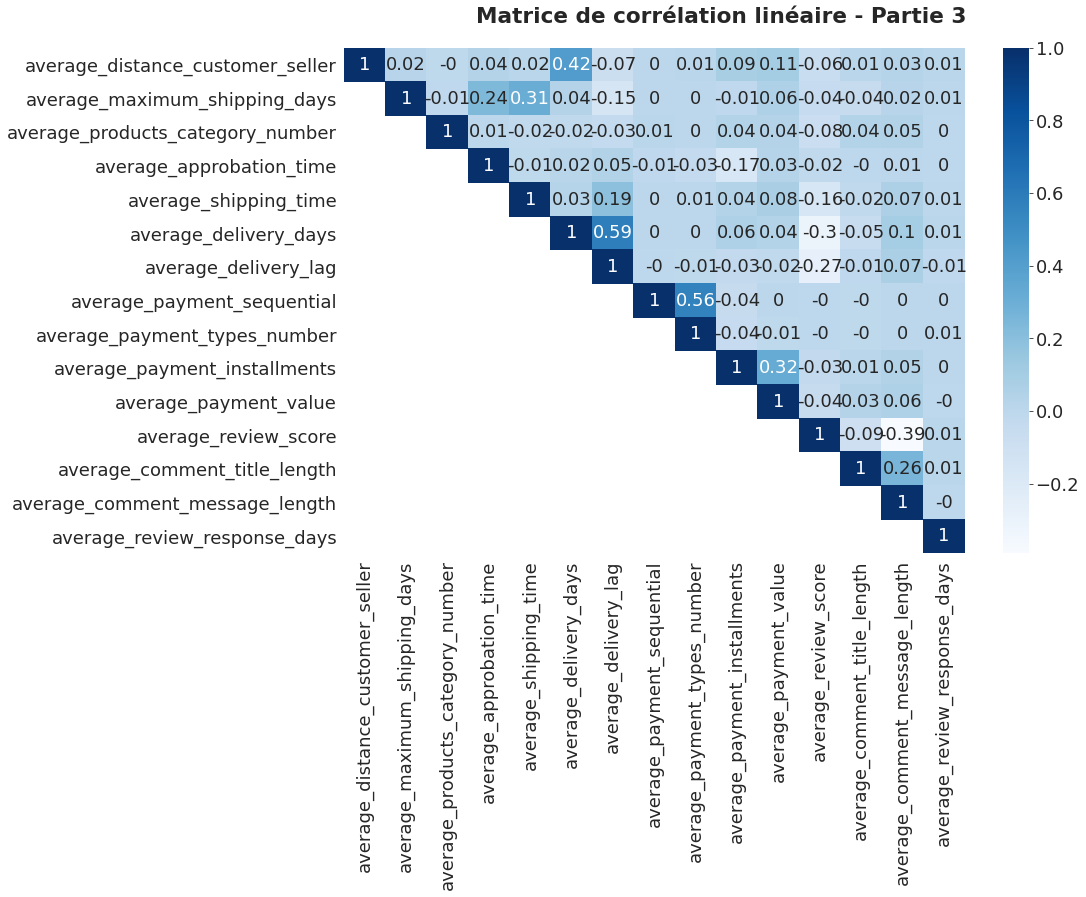

In [ ]:
graph = sfg.MyGraph("Matrice de corrélation linéaire - Partie 3",
                    figsize=(12, 8))
graph.add_sns_heatmap(valeurs.iloc[15:, 15:],
                      annotations=annotations.iloc[15:, 15:])
fig, ax = graph.fig, graph.ax
save_fig("ML04_part1_bivarie03")
plt.show()

**Conclusions des analyses multivariées**

De façon logique : 
- le nombre d'articles, de produits et de vendeurs sont corrélés ;
- le prix total moyen est lié à la dépense moyenne par produit et par vendeur, ainsi qu'au total des paiements et dans une moindre mesure au prix moyen des articles. Ces autres variables sont également liées entre elles ;
- l'importance du coût du fret dans le prix total a tendance à diminuer lorsque le prix moyen des articles ou du panier augmente ;
- le volume et le poids des articles sont liés ;
- les scores les plus faibles ont tendance à correspondre à des commentaires plus longs. Sur internet, les clients mécontents laissent proportionnellement plus de commentaires que les clients satisfaits.
- le retard (ou l'avance) dans la livraison au client par rapport à la date prévue est surtout lié au nombre de jours que le transporteur met pour livrer le colis ;
- les notes ont tendance à être moins bonnes lorsque le délai de préparation et de livraison est plus long. Les clients semblent donc dans la majorité attaché à la rapidité de la livraison.

<a id='5_0'></a>

## <font color=blue>5. Pas de sauvegarde des données</font>

Je ne sauvegarde pas les données car je vais créer un pipeline complet d'agrégation des données dans le notebook de segmentation, afin de pouvoir mettre à jour facilement la segmentation lors de l'ajout de nouvelles données.